  # Get pharmacophore fingerprints

- Using multiparallelism and calling **`getPharmacophoresFromRDKit`**
    - Use Jump CP metadata file as input 
    - Compute Pharmacophores for each compound
    - Save pharmacophore vectors as sparse and dense files
    

# Initialization

In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

import os
import sys
import argparse
import csv
import logging
import json
import time
import types, copy, pprint
from datetime import datetime
for p in ['..','../../..']:
    if p not in sys.path:
        print(f"insert {p}")
        sys.path.insert(0, p)
print(sys.path)
from operator import mod
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

# from KevinsRoutines.utils.utils_general  import  list_namespace 

from itertools import repeat
import more_itertools
from multiprocessing import Pool, process
from os import getpid
from rdkit.Chem import PandasTools

pp = pprint.PrettyPrinter(indent=4)
np.set_printoptions(edgeitems=10, infstr='inf', linewidth=150, nanstr='nan')
pd.options.display.width = 180

# datetime.now().strftime('%X.%f')
# timestamp = time.strftime(' %x%X')
# timestamp = datetime.now().strftime('%X.%f')
# timestamp = time.strftime('%x-%X %Z')
# timestamp = datetime.now().strftime('%D-%X.%f')
timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f' )
print(timestamp)

# logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
# FORMAT = '%(asctime)s - %(levelname)s: - %(message)s'
# logging.basicConfig(level="INFO", format= FORMAT)
# logging.getLogger("imported_module").setLevel(logging.CRITICAL)

logger = logging.getLogger(__name__)
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)
logger.info(f" Excution started : {timestamp} ")
logger.info(f" Python version   : {sys.version}")
logger.info(f" Numpy version    : {np.__version__}")
logger.info(f" Pandas version   : {pd.__version__}  ")

2024-12-25 13:32:08,656 - INFO: -  Excution started : 2024-12-25 13:32:08.656298 
2024-12-25 13:32:08,657 - INFO: -  Python version   : 3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 18:08:17) [GCC 12.2.0]
2024-12-25 13:32:08,657 - INFO: -  Numpy version    : 1.26.2
2024-12-25 13:32:08,658 - INFO: -  Pandas version   : 2.2.2  


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['../../..', '..', '/home/kevin/WSL-shared/cellpainting/cj-datasets/Notebooks-Dataprep', '/home/kevin/miniforge3/envs/cp311/lib/python311.zip', '/home/kevin/miniforge3/envs/cp311/lib/python3.11', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages', '/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/huggingface_hub-0.20.3-py3.8.egg']
2024-12-25 13:32:08.656298


In [2]:
from KevinsRoutines.utils.utils_chem import (appendMolFromRDKit, fingerprint_to_dense_matrix,
                                             getPharmacophoresFromRDKit,  my_enumerator, my_starmap_with_kwargs_async, )

from src.utils.jcp_datasets import project_datasets, display_project_datasets
ds = project_datasets(output_path = '../output_10162024/')
ds = project_datasets(output_path = '../output_11102023/')
display_project_datasets(ds)

/home/kevin/miniforge3/envs/cp311/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


 Path and Prefixes : 
 ------------------- 
 prefix                                      : 
 prefix_lc                                   : 
 metadata path                               : ./metadata/
 input path                                  : ./input/
 output path                                 : ../output_11102023/

 Input & Metadata Datasets : 
 --------------------------- 
 Compound Metadata Input File                : ./metadata/compound.csv
 Plate Metadata Input File                   : ./metadata/plate_new.csv
 Well Metadata Input File                    : ./metadata/well.csv

 Profiles Metadata File                      : ./metadata/profile_metadata.pkl
 Parquet  Metadata File                      : ./metadata/parquet_columns.pkl

 Compound Metadata : 
 ------------------- 
 Metadata + Smiles                           : ../output_11102023/compound_metadata_smiles.csv
          + TPSA                             : ../output_11102023/compound_metadata_tpsa.csv
          + TPSA

# Test fingerprint generation (Adam)

| Number of Bins | Fingerprint Size | Compounds with Zero Fingerprint |
|------------------|--------------------|-----------------------------|
| 1   |   156    | |
| 2   |   1,032    | |
| 3   |   3,348    | |
| 4   |   7,464    | | 
| 5   |   13,740    | 40 |

### Create Pharmacophores definitions 

In [21]:
from rdkit import RDConfig
from rdkit.Chem import ChemicalFeatures
from rdkit.Chem.Pharm2D.SigFactory import SigFactory
fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
print(fdefName)
featFactory = ChemicalFeatures.BuildFeatureFactory(fdefName)
sigFactory = SigFactory(featFactory,minPointCount=2,maxPointCount=3)
# fingerprint_bins = [(0,1),(1,2),(2,3),(3,4),(4,100)]
# fingerprint_bins = [(0,3),(3,6),(6,9),(9,12),(12,100)]
fingerprint_bins = [(0,3),(3,8)]
sigFactory.SetBins(fingerprint_bins)
sigFactory.Init()
FINGERPRINT_LENGTH = sigFactory.GetSigSize()
bit_id = 0


print(f" Bins : {fingerprint_bins}   Size of fingerprint: {FINGERPRINT_LENGTH}")
# print(f" Bins : {bit_id:4d}   description:  {sigFactory.GetBitDescription(bit_id)}")

/home/kevin/miniforge3/envs/cp311/share/RDKit/Data/BaseFeatures.fdef
 Bins : [(0, 3), (3, 8)]   Size of fingerprint: 1032


In [4]:
# Phramacophore bits with a ROC_AUC pver .60
selected_bits_over60   = [23, 17, 53, 21, 509,  9, 52, 49, 163, 797,
                          39, 13, 267, 141, 285,  479, 677, 45, 127, 270,
                          767, 468, 271, 2, 165,  756, 27, 387, 26, 287,
                          390, 48, 231, 183, 383, 8]

# Phramacophore bits with a ROC_AUC between .55 and .60
selected_bits_55_to_60 = [158, 425, 108, 33, 148, 421, 606, 647, 86, 638,
                          433, 111, 94, 246, 91, 87, 430, 80, 110, 198,
                          639, 104, 35, 422, 426, 42, 0, 0, 5, 78,
                          19, 154, 370, 20, 210, 464, 470, 212, 646, 599,
                          247, 633, 437, 245, 595, 250, 30, 439, 371, 34,
                          375, 202, 142, 758, 643, 197, 598, 469, 199, 166,
                          465, 382, 427, 255, 374, 44, 43, 252, 179, 159,
                          31, 167, 254, 143, 438, 641, 162, 366, 379, 478,
                          645, 157, 57, 372, 434, 153, 752, 477, 140, 471,
                          763, 435, 251, 473, 253, 164, 679, 22, 475, 766,
                          378, 155, 152, 16, 759]

# Phramacophore bits with a ROC_AUC between .50 and .55
selected_bits_50_to_55 = [200, 205, 211, 428, 642, 103,  98, 215, 100, 636,
                          150, 149, 144, 102, 207, 151, 206,   6, 147,  79,
                          83,  95, 203, 607, 603, 213, 208, 107,  99,  32,
                          431, 204, 96,  214,   4,   1, 637, 146, 429, 156,
                          417, 18, 244,  423, 84]
print()
print(f"  Bit    ROC_AUC     Description")
print(f"  ----   --------    -------------")
# for bit_id in range(200, 400): # bits 200 to 400
for bit_id in sorted(selected_bits_over60):
    if bit_id in selected_bits_over60: 
        prefix = " > 0.60  "
    elif bit_id in selected_bits_55_to_60:
        prefix = " > 0.55  "
    elif bit_id in selected_bits_50_to_55:
        prefix = " > 0.50  "
    else :
        prefix = "         "
    print(f" {bit_id:4d}   {prefix:9s}    {sigFactory.GetBitDescription(bit_id)}")


  Bit    ROC_AUC     Description
  ----   --------    -------------
    2    > 0.60      Acceptor Acceptor |0 2|2 0|
    8    > 0.60      Acceptor Aromatic |0 3|3 0|
    9    > 0.60      Acceptor Aromatic |0 4|4 0|
   13    > 0.60      Acceptor Donor |0 3|3 0|
   17    > 0.60      Acceptor Hydrophobe |0 2|2 0|
   21    > 0.60      Acceptor LumpedHydrophobe |0 1|1 0|
   23    > 0.60      Acceptor LumpedHydrophobe |0 3|3 0|
   26    > 0.60      Acceptor NegIonizable |0 1|1 0|
   27    > 0.60      Acceptor NegIonizable |0 2|2 0|
   39    > 0.60      Acceptor ZnBinder |0 4|4 0|
   45    > 0.60      Aromatic Donor |0 0|0 0|
   48    > 0.60      Aromatic Donor |0 3|3 0|
   49    > 0.60      Aromatic Donor |0 4|4 0|
   52    > 0.60      Aromatic Hydrophobe |0 2|2 0|
   53    > 0.60      Aromatic Hydrophobe |0 3|3 0|
  127    > 0.60      Hydrophobe ZnBinder |0 2|2 0|
  141    > 0.60      LumpedHydrophobe PosIonizable |0 1|1 0|
  163    > 0.60      NegIonizable ZnBinder |0 3|3 0|
  165    > 0.

In [10]:
fdefName = os.path.join(RDConfig.RDDataDir,'BaseFeatures.fdef')
featFactory = ChemicalFeatures.BuildFeatureFactory(fdefName)
sigFactory = SigFactory(featFactory,minPointCount=2,maxPointCount=3)
sigFactory.SetBins([(0,1),(1,2),(2,3),(3,4),(4,100)])
sigFactory.Init()
sigFactory.GetSigSize()
#     print(f" RDKit BaseFeatures.fdef : {fdefName}")

13740

## Generate fingerprints from Smiles (Smiles --> Mol --> Fingerprint)

In [11]:
from rdkit.Chem.rdmolfiles import MolFromSmiles
from rdkit.Chem.Pharm2D import Generate

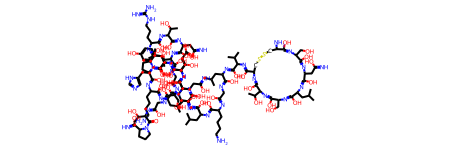

In [12]:
smile = 'c1ccc(Cc2ccccc2)cc1'   ## adam example to decipher fingerprint
smile = 'CN'                    ## Zero fingerprint
smile =  'FC(F)(F)C1CC(=NCCN=1)c2ccccc2'
smile = 'CC(O)C1N=C(O)C(CO)N=C(O)C(CC(C)C)N=C(O)C(CC(=N)O)N=C(O)C(CO)N=C(O)C(N)CSSCC(N=C1O)C(O)=NC(C(C)C)C(O)=NC(CC(C)C)C(O)=NCC(O)=NC(CCCCN)C(O)=NC(CC(C)C)C(O)=NC(CO)C(O)=NC(CCC(=N)O)C(O)=NC(CCC(=O)O)C(O)=NC(CC(C)C)C(O)=NC(CC2=CN=CN2)C(O)=NC(CCCCN)C(O)=NC(CC(C)C)C(O)=NC(CCC(=N)O)C(O)=NC(C(C)O)C(O)=NC(Cc3ccc(O)cc3)C(=O)N4CCCC4C(O)=NC(CCCNC(=N)N)C(O)=NC(C(C)O)C(O)=NC(CC(=N)O)C(O)=NC(C(C)O)C(O)=NCC(O)=NC(CO)C(O)=NCC(O)=NC(C(=O)N5CCCC5C(=N)O)C(C)O'
tmp = MolFromSmiles(smile)
tmp

In [13]:
fp = Generate.Gen2DFingerprint(tmp, sigFactory)

 12/11/24-18:59:17 | my_callback() - ALL RESULTS ARE READY
 12/11/24-18:59:17 | my_callback() - ALL RESULTS ARE READY
 12/11/24-18:59:17 | my_callback() - ALL RESULTS ARE READY


In [14]:
fp.GetNumBits()
fp.GetNumOnBits()
fp.GetNumOffBits()
# int_vector = np.zeros((1032))
# int_vector[:10]

13740

417

13323

In [181]:
int_vector =fp.GetOnBits()
list(int_vector)

[42, 51, 52, 57, 106, 107, 111, 112, 132, 4522, 5765, 5859, 9833, 9927, 10375]

In [15]:
int_vector =fp.GetOnBits()
ind_list= list(int_vector)

In [16]:
for bit_id in  ind_list:
    print(f" bit: {bit_id:5d}    desc: {sigFactory.GetBitDescription(bit_id)} ")

 bit:     2    desc: Acceptor Acceptor |0 2|2 0| 
 bit:     4    desc: Acceptor Acceptor |0 4|4 0| 
 bit:     6    desc: Acceptor Aromatic |0 1|1 0| 
 bit:     9    desc: Acceptor Aromatic |0 4|4 0| 
 bit:    12    desc: Acceptor Donor |0 2|2 0| 
 bit:    13    desc: Acceptor Donor |0 3|3 0| 
 bit:    14    desc: Acceptor Donor |0 4|4 0| 
 bit:    17    desc: Acceptor Hydrophobe |0 2|2 0| 
 bit:    18    desc: Acceptor Hydrophobe |0 3|3 0| 
 bit:    19    desc: Acceptor Hydrophobe |0 4|4 0| 
 bit:    21    desc: Acceptor LumpedHydrophobe |0 1|1 0| 
 bit:    23    desc: Acceptor LumpedHydrophobe |0 3|3 0| 
 bit:    24    desc: Acceptor LumpedHydrophobe |0 4|4 0| 
 bit:    29    desc: Acceptor NegIonizable |0 4|4 0| 
 bit:    33    desc: Acceptor PosIonizable |0 3|3 0| 
 bit:    34    desc: Acceptor PosIonizable |0 4|4 0| 
 bit:    39    desc: Acceptor ZnBinder |0 4|4 0| 
 bit:    44    desc: Aromatic Aromatic |0 4|4 0| 
 bit:    46    desc: Aromatic Donor |0 1|1 0| 
 bit:    49    desc:

# Calculate pharmacophores using multiprocessing 

 #### Read Jump-CP compound metadata (+ smiles) file
 number of rows 116,691

In [4]:
# print(f" Read from {ds.compoundMetadataTPSACleanFile}")
# df = pd.read_csv(ds.compoundMetadataTPSACleanFile,   nrows = 0)
# HEADER_COLS = df.columns
# HEADER_COLS
# df.info()
# df.head(3)
# df.tail(3)
# len(df)
# df_md_zero = df[df['Metadata_Smiles'].isna()]
# print(f" Metadata entries with Smiles == Nan : {len(df_md_zero)}")
# df_md_zero = df[df['Metadata_TPSA'] == 0.0]
# print(f" Metadata entries with TPSA == 0.0   : {len(df_md_zero)}")
# df_md_nan = df[df['Metadata_TPSA'].isna()]
# print(f" Metadata entries with TPSA == Nan   : {len(df_md_nan)}")
# df_md_inv = pd.concat((df_md_zero, df_md_nan))
# print(f" Metadata entries with TPSA == Nan or 0.0: {len(df_md_inv)}")
# df_md_inv

In [6]:
# del my_enumerator, my_callback, my_error_callback, apply_args_and_kwargs, starmap_with_kwargs_async, getPharmacophoresFromRDKit
# from KevinsRoutines.utils.utils_chem import my_callback, my_error_callback
# from KevinsRoutines.utils.utils_chem import my_enumerator, my_callback, my_error_callback, apply_args_and_kwargs, starmap_with_kwargs_async
# del results, results_list

del getPharmacophoresFromRDKit
del my_starmap_with_kwargs_async
from KevinsRoutines.utils.utils_chem import getPharmacophoresFromRDKit
from KevinsRoutines.utils.utils_chem import my_starmap_with_kwargs_async

In [7]:
# nrows = 116_691
# SKIP_ROWS = 0
# NUM_ROWS = 10
CHUNKSIZE = 10000
progress_int = 1000
processes = 10
# fingerprint_bins = [(0,1),(1,2),(2,3),(3,4),(4,100)]
# fingerprint_bins = [(0,3),(3,6),(6,9),(9,12),(12,100)]
fingerprint_bins = [(0,3),(3,8)]

call_function  = getPharmacophoresFromRDKit
kwargs = {'limit' : -1, 'fingerprint_bins' : fingerprint_bins, 'append_pharmacophore' : False, 'progress_int' : progress_int}

print(f"Read metadata file : {ds.compoundMetadataTPSACleanFile}")
df = pd.read_csv(ds.compoundMetadataTPSACleanFile,   nrows = 0)
HEADER_COLS = df.columns
del df 
enumerator = my_enumerator()
# df_iterator  = pd.read_csv(ds.compoundMetadataTPSACleanFile, names = HEADER_COLS, chunksize= CHUNKSIZE, skiprows = SKIP_ROWS, nrows = NUM_ROWS)
df_iterator  = pd.read_csv(ds.compoundMetadataTPSACleanFile,  chunksize= CHUNKSIZE)
df_iterator
args = zip(enumerator, df_iterator)

# dd = next(df_iterator)
# type(dd)
# dd.info()
# dd.head(4)

Read metadata file : ../output_11102023/compound_metadata_tpsa_clean.csv


## Call `utils_chem.my_starmap_with_kwargs_async`
  #### If this is executed, reinitialize enumerator and df_iterator before running 
  #### Parameters:
    processes: Number of processes
    fn:     Function to be called: getPharmacophoresFromRDKit
    args:   Positional arguments:  (idx, df_iterator)
    kwargs: Keyword arguments:     {'append_pharmacophore' : False, 'progress_int' : progress_int}

In [8]:
## starmap_with_kwargs_async
# for arg in args:
#     print(arg[0], len(arg[1]))

In [9]:
# result = pool.starmap_async(get_pharmacophores, enumerate(df_iterator))


results = my_starmap_with_kwargs_async(fn=call_function, args=args, kwargs = kwargs, processes = processes)


2024-12-25 13:33:25,756 - INFO: -  my_starmap_with_kwargs_async() | Started -  processes  : 10
 			 fn         : <function getPharmacophoresFromRDKit at 0x7fdd093131a0>       
 			 args_iter  : <class 'zip'> 
 			 kwargs_iter: <class 'dict'> : {'limit': -1, 'fingerprint_bins': [(0, 3), (3, 8)], 'append_pharmacophore': False, 'progress_int': 1000}



<multiprocessing.pool.Pool state=RUN pool_size=10>


2024-12-25 13:33:26,543 - INFO: -  my_starmap_with_kwargs_async() | all processes submitted, now waiting . . .  
2024-12-25 13:33:26,588 - INFO: -  call_function_with_args_and_kwargs()  for part 0 
  			  fn:      <class 'function'>    - <function getPharmacophoresFromRDKit at 0x7fdd093131a0> 
  			  args:    <class 'tuple'>  - 2:  args[0]: 0   args[1]: <class 'pandas.core.frame.DataFrame'> 
  			  kwargs:  <class 'dict'>- {'limit': -1, 'fingerprint_bins': [(0, 3), (3, 8)], 'append_pharmacophore': False, 'progress_int': 1000} 
2024-12-25 13:33:26,592 - INFO: -  exiting call_function_with_args_and_kwargs() for part 0 
2024-12-25 13:33:26,594 - INFO: -  getPharmacophoresFromRDKit() - chunk_id: 0 - chunk sz: (10000, 10)  limit: 10000 - append_pharmacophore: False
2024-12-25 13:33:26,595 - INFO: -  getPharmacophoresFromRDKit() - chunk_id: 0 - fingerprint_bins: [(0, 3), (3, 8)] 
2024-12-25 13:33:26,622 - INFO: -  call_function_with_args_and_kwargs()  for part 1 
  			  fn:      <class 'func

 13:33:35.439478 | chunk_id: 3 | 1000 rows processed 



[13:33:35] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 13:33:36.237002 | chunk_id: 2 | 1000 rows processed 

 13:33:36.275178 | chunk_id: 7 | 1000 rows processed 

 13:33:36.522991 | chunk_id: 9 | 1000 rows processed 

 13:33:36.843559 | chunk_id: 1 | 1000 rows processed 

 13:33:37.135328 | chunk_id: 5 | 1000 rows processed 

 13:33:37.496508 | chunk_id: 4 | 1000 rows processed 

 13:33:37.650790 | chunk_id: 8 | 1000 rows processed 



2024-12-25 13:33:38,030 - WARNING: -   ctr: 1293  index: 31293  chunk_id: 3  Compound: JCP2022_031312
2024-12-25 13:33:38,032 - WARNING: -   InChIKey: HNJBEVLQSNELDL-UHFFFAOYSA-N  Smile: [OC1CCCN=1]	 Fingerprint Zero returned
2024-12-25 13:33:39,319 - WARNING: -   ctr: 1230  index: 41230  chunk_id: 4  Compound: JCP2022_041253
2024-12-25 13:33:39,320 - WARNING: -   InChIKey: JPGQOUSTVILISH-UHFFFAOYSA-N  Smile: [FC(F)OC(F)(F)C(F)Cl]	 Fingerprint Zero returned
2024-12-25 13:33:40,000 - WARNING: -   ctr: 1309  index: 71309  chunk_id: 7  Compound: JCP2022_071350
2024-12-25 13:33:40,001 - WARNING: -   InChIKey: PWCFCQOJYHVTOL-UHFFFAOYSA-N  Smile: [CC1=CC=C(O1)C2=[N+]([O-])C(C)=[N+]([O-])C2(C)C]	 Fingerprint Zero returned
[13:33:40] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match; Proton balance: Does not match)



 13:33:41.155985 | chunk_id: 0 | 1000 rows processed 



2024-12-25 13:33:41,209 - WARNING: -   ctr: 1169  index: 81169  chunk_id: 8  Compound: JCP2022_081217
2024-12-25 13:33:41,211 - WARNING: -   InChIKey: RWRDLPDLKQPQOW-UHFFFAOYSA-N  Smile: [C1CCNC1]	 Fingerprint Zero returned
[13:33:42] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 13:33:43.284408 | chunk_id: 6 | 1000 rows processed 



2024-12-25 13:33:44,464 - WARNING: -   ctr: 1873  index: 21873  chunk_id: 2  Compound: JCP2022_021886
2024-12-25 13:33:44,465 - WARNING: -   InChIKey: FOCVUCIESVLUNU-UHFFFAOYSA-N  Smile: [S=P(N1CC1)(N2CC2)N3CC3]	 Fingerprint Zero returned
[13:33:45] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 13:33:45.738009 | chunk_id: 2 | 2000 rows processed 

 13:33:46.001036 | chunk_id: 7 | 2000 rows processed 

 13:33:46.954593 | chunk_id: 4 | 2000 rows processed 

 13:33:52.905898 | chunk_id: 8 | 2000 rows processed 

 13:33:53.613366 | chunk_id: 0 | 2000 rows processed 

 13:33:54.197472 | chunk_id: 1 | 2000 rows processed 

 13:33:54.516613 | chunk_id: 2 | 3000 rows processed 

 13:33:55.235031 | chunk_id: 7 | 3000 rows processed 



[13:33:58] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number; Mobile-H groups: One instead of multiple, Attachment points, Number)



 13:33:58.589315 | chunk_id: 4 | 3000 rows processed 



[13:33:59] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)

2024-12-25 13:33:59,947 - WARNING: -   ctr: 2394  index: 82394  chunk_id: 8  Compound: JCP2022_082442
2024-12-25 13:33:59,948 - WARNING: -   InChIKey: SDGKUVSVPIIUCF-UHFFFAOYSA-N  Smile: [CC1CCCC(C)N1]	 Fingerprint Zero returned
[13:34:01] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Charge(s): Do not match)



 13:34:02.967179 | chunk_id: 9 | 2000 rows processed 



2024-12-25 13:34:03,174 - WARNING: -   ctr: 2938  index: 2938  chunk_id: 0  Compound: JCP2022_002940
2024-12-25 13:34:03,175 - WARNING: -   InChIKey: APLHDUWNMGJBFD-UHFFFAOYSA-N  Smile: [SC1CCCCCN=1]	 Fingerprint Zero returned


 13:34:03.683453 | chunk_id: 0 | 3000 rows processed 

 13:34:04.641012 | chunk_id: 1 | 3000 rows processed 

 13:34:05.295575 | chunk_id: 2 | 4000 rows processed 



[13:34:05] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)

2024-12-25 13:34:06,257 - WARNING: -   ctr: 2324  index: 92324  chunk_id: 9  Compound: JCP2022_092375
2024-12-25 13:34:06,258 - WARNING: -   InChIKey: UYPYRKYUKCHHIB-UHFFFAOYSA-N  Smile: [C[N+](C)(C)[O-]]	 Fingerprint Zero returned
2024-12-25 13:34:07,071 - WARNING: -   ctr: 2428  index: 92428  chunk_id: 9  Compound: JCP2022_092479
2024-12-25 13:34:07,073 - WARNING: -   InChIKey: UZFMOKQJFYMBGY-UHFFFAOYSA-N  Smile: [CC1(C)CC(O)CC(C)(C)N1[O]]	 Fingerprint Zero returned
[13:34:09] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 13:34:12.273030 | chunk_id: 8 | 3000 rows processed 

 13:34:12.300783 | chunk_id: 9 | 3000 rows processed 

 13:34:14.009730 | chunk_id: 2 | 5000 rows processed 

 13:34:14.291452 | chunk_id: 1 | 4000 rows processed 

 13:34:14.495318 | chunk_id: 0 | 4000 rows processed 



2024-12-25 13:34:15,222 - WARNING: -   ctr: 4087  index: 4087  chunk_id: 0  Compound: JCP2022_004089
2024-12-25 13:34:15,223 - WARNING: -   InChIKey: AVFZOVWCLRSYKC-UHFFFAOYSA-N  Smile: [CN1CCCC1]	 Fingerprint Zero returned
2024-12-25 13:34:17,320 - WARNING: -   ctr: 3583  index: 93583  chunk_id: 9  Compound: JCP2022_093634
2024-12-25 13:34:17,322 - WARNING: -   InChIKey: VFOJMKRYKVNVGA-UHFFFAOYSA-N  Smile: [CN(C#N)c1ccccc1]	 Fingerprint Zero returned


 13:34:20.931747 | chunk_id: 9 | 4000 rows processed 

 13:34:21.848492 | chunk_id: 8 | 4000 rows processed 



2024-12-25 13:34:22,197 - WARNING: -   ctr: 4154  index: 94154  chunk_id: 9  Compound: JCP2022_094205
2024-12-25 13:34:22,198 - WARNING: -   InChIKey: VIQMKWMHOAWQRG-UHFFFAOYSA-N  Smile: [O=C1CSCSC1]	 Fingerprint Zero returned


 13:34:24.586789 | chunk_id: 1 | 5000 rows processed 

 13:34:27.857179 | chunk_id: 0 | 5000 rows processed 



2024-12-25 13:34:28,668 - WARNING: -   ctr: 5103  index: 5103  chunk_id: 0  Compound: JCP2022_005105
2024-12-25 13:34:28,670 - WARNING: -   InChIKey: BAVYZALUXZFZLV-UHFFFAOYSA-N  Smile: [CN]	 Fingerprint Zero returned


 13:34:31.041137 | chunk_id: 8 | 5000 rows processed 

 13:34:33.652064 | chunk_id: 1 | 6000 rows processed 

 13:34:38.801565 | chunk_id: 9 | 5000 rows processed 

 13:34:39.875937 | chunk_id: 8 | 6000 rows processed 

 13:34:42.302954 | chunk_id: 2 | 6000 rows processed 

 13:34:46.720385 | chunk_id: 1 | 7000 rows processed 

 13:34:48.497921 | chunk_id: 8 | 7000 rows processed 

 13:34:49.167073 | chunk_id: 9 | 6000 rows processed 

 13:34:50.618934 | chunk_id: 2 | 7000 rows processed 



2024-12-25 13:34:52,655 - WARNING: -   ctr: 6427  index: 96427  chunk_id: 9  Compound: JCP2022_096478
2024-12-25 13:34:52,657 - WARNING: -   InChIKey: VUZNLSBZRVZGIK-UHFFFAOYSA-N  Smile: [CC1(C)CCCC(C)(C)N1O]	 Fingerprint Zero returned
[13:34:53] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Multiple instead of one, Number)



 13:34:56.949616 | chunk_id: 8 | 8000 rows processed 



2024-12-25 13:34:58,234 - WARNING: -   ctr: 7633  index: 27633  chunk_id: 2  Compound: JCP2022_027649
2024-12-25 13:34:58,238 - WARNING: -   InChIKey: GTJYCOSSMNZWMW-UHFFFAOYSA-N  Smile: [CSC1NC(C)(C)CCC(C)(C)N=1]	 Fingerprint Zero returned


 13:34:58.310646 | chunk_id: 9 | 7000 rows processed 



[13:34:59] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 13:35:01.326917 | chunk_id: 2 | 8000 rows processed 



2024-12-25 13:35:01,970 - WARNING: -   ctr: 3329  index: 73329  chunk_id: 7  Compound: JCP2022_073374
2024-12-25 13:35:01,971 - WARNING: -   InChIKey: QGZKDVFQNNGYKY-UHFFFAOYSA-N  Smile: [N]	 Fingerprint Zero returned


 13:35:07.242664 | chunk_id: 8 | 9000 rows processed 

 13:35:08.009145 | chunk_id: 9 | 8000 rows processed 



2024-12-25 13:35:08,659 - WARNING: -   ctr: 7445  index: 17445  chunk_id: 1  Compound: JCP2022_017455
2024-12-25 13:35:08,660 - WARNING: -   InChIKey: DPUVICGLBCCTDM-UHFFFAOYSA-N  Smile: [CN1C=NC=C1I]	 Fingerprint Zero returned


 13:35:11.264458 | chunk_id: 7 | 4000 rows processed 



[13:35:12] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 13:35:13.529746 | chunk_id: 2 | 9000 rows processed 

 13:35:15.972221 | chunk_id: 8 | 10000 rows processed 


 ------------------------------------------------------------------------- 
 Results of processing chunk 8 
 ------------------------------------------------------------------------- 
                                          Total Read :  10000
 rows with missing InChiKey in input                 :      0 
 rows with no MOL object returned from RDKit         :      0      
 rows with with valid Mol                            :  10000  
 rows with Nan fingerprint                           :      0       
 rows with Zero fingerprint                          :      2     
 rows with Non-Zero fingerprint                      :   9998         
                                               Total :      0
 ------------------------------------------------------------------------- 
 13:35:15.977490 | chunk_id: 8 | Process end   
 -----------------------------------------------------

2024-12-25 13:35:16,215 - INFO: -  call_function_with_args_and_kwargs()  for part 10 
  			  fn:      <class 'function'>    - <function getPharmacophoresFromRDKit at 0x7fdd093131a0> 
  			  args:    <class 'tuple'>  - 2:  args[0]: 10   args[1]: <class 'pandas.core.frame.DataFrame'> 
  			  kwargs:  <class 'dict'>- {'limit': -1, 'fingerprint_bins': [(0, 3), (3, 8)], 'append_pharmacophore': False, 'progress_int': 1000} 
2024-12-25 13:35:16,217 - INFO: -  exiting call_function_with_args_and_kwargs() for part 10 
2024-12-25 13:35:16,218 - INFO: -  getPharmacophoresFromRDKit() - chunk_id: 10 - chunk sz: (10000, 10)  limit: 10000 - append_pharmacophore: False
2024-12-25 13:35:16,219 - INFO: -  getPharmacophoresFromRDKit() - chunk_id: 10 - fingerprint_bins: [(0, 3), (3, 8)] 


 13:35:24.188942 | chunk_id: 7 | 5000 rows processed 

 13:35:26.146486 | chunk_id: 10 | 1000 rows processed 



[13:35:29] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 13:35:30.737975 | chunk_id: 1 | 9000 rows processed 

 13:35:36.228133 | chunk_id: 10 | 2000 rows processed 

 13:35:37.172786 | chunk_id: 7 | 6000 rows processed 

 13:35:38.469757 | chunk_id: 4 | 4000 rows processed 



[13:35:39] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match; Proton balance: Does not match)



 13:35:39.490965 | chunk_id: 1 | 10000 rows processed 


 ------------------------------------------------------------------------- 
 Results of processing chunk 1 
 ------------------------------------------------------------------------- 
                                          Total Read :  10000
 rows with missing InChiKey in input                 :      0 
 rows with no MOL object returned from RDKit         :      0      
 rows with with valid Mol                            :  10000  
 rows with Nan fingerprint                           :      0       
 rows with Zero fingerprint                          :      2     
 rows with Non-Zero fingerprint                      :   9998         
                                               Total :      0
 ------------------------------------------------------------------------- 
 13:35:39.496346 | chunk_id: 1 | Process end   
 ------------------------------------------------------------------------- 



2024-12-25 13:35:39,771 - INFO: -  call_function_with_args_and_kwargs()  for part 11 
  			  fn:      <class 'function'>    - <function getPharmacophoresFromRDKit at 0x7fdd093131a0> 
  			  args:    <class 'tuple'>  - 2:  args[0]: 11   args[1]: <class 'pandas.core.frame.DataFrame'> 
  			  kwargs:  <class 'dict'>- {'limit': -1, 'fingerprint_bins': [(0, 3), (3, 8)], 'append_pharmacophore': False, 'progress_int': 1000} 
2024-12-25 13:35:39,773 - INFO: -  exiting call_function_with_args_and_kwargs() for part 11 
2024-12-25 13:35:39,774 - INFO: -  getPharmacophoresFromRDKit() - chunk_id: 11 - chunk sz: (6691, 10)  limit: 6691 - append_pharmacophore: False
2024-12-25 13:35:39,775 - INFO: -  getPharmacophoresFromRDKit() - chunk_id: 11 - fingerprint_bins: [(0, 3), (3, 8)] 
[13:35:41] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)

2024-12-25 13:35:42,560 - WARNING: -   ctr: 4472  index: 

 13:35:45.735052 | chunk_id: 7 | 7000 rows processed 



[13:35:46] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 13:35:53.022233 | chunk_id: 11 | 1000 rows processed 

 13:35:56.057888 | chunk_id: 5 | 2000 rows processed 

 13:35:57.733424 | chunk_id: 4 | 5000 rows processed 

 13:36:01.589737 | chunk_id: 11 | 2000 rows processed 

 13:36:01.947880 | chunk_id: 2 | 10000 rows processed 


 ------------------------------------------------------------------------- 
 Results of processing chunk 2 
 ------------------------------------------------------------------------- 
                                          Total Read :  10000
 rows with missing InChiKey in input                 :      0 
 rows with no MOL object returned from RDKit         :      0      
 rows with with valid Mol                            :  10000  
 rows with Nan fingerprint                           :      0       
 rows with Zero fingerprint                          :      2     
 rows with Non-Zero fingerprint                      :   9998         
                                               Total :      0
 ----------

2024-12-25 13:36:04,042 - WARNING: -   ctr: 2925  index: 52925  chunk_id: 5  Compound: JCP2022_052954
2024-12-25 13:36:04,043 - WARNING: -   InChIKey: MAVYKYRWYBBQGY-UHFFFAOYSA-N  Smile: [C1CCN(C1)C2=NC=CS2]	 Fingerprint Zero returned


 13:36:07.205124 | chunk_id: 4 | 6000 rows processed 



[13:36:14] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: Attachment points, Number; Charge(s): Do not match)

2024-12-25 13:36:15,211 - WARNING: -   ctr: 6972  index: 46972  chunk_id: 4  Compound: JCP2022_046998
2024-12-25 13:36:15,213 - WARNING: -   InChIKey: KTZXJXYESSLGBH-UHFFFAOYSA-N  Smile: [CN1N=NN(C)C12N(N=NC2(C)C)c3ccccc3]	 Fingerprint Zero returned


 13:36:15.390675 | chunk_id: 4 | 7000 rows processed 

 13:36:23.046083 | chunk_id: 5 | 3000 rows processed 

 13:36:29.618494 | chunk_id: 4 | 8000 rows processed 



2024-12-25 13:36:35,368 - WARNING: -   ctr: 3381  index: 53381  chunk_id: 5  Compound: JCP2022_053411
2024-12-25 13:36:35,369 - WARNING: -   InChIKey: MDKCFLQDBWCQCV-UHFFFAOYSA-N  Smile: [S=C=NCc1ccccc1]	 Fingerprint Zero returned


 13:36:37.924853 | chunk_id: 7 | 8000 rows processed 

 13:36:38.539019 | chunk_id: 4 | 9000 rows processed 

 13:36:40.911962 | chunk_id: 5 | 4000 rows processed 

 13:36:46.744221 | chunk_id: 4 | 10000 rows processed 


 ------------------------------------------------------------------------- 
 Results of processing chunk 4 
 ------------------------------------------------------------------------- 
                                          Total Read :  10000
 rows with missing InChiKey in input                 :      0 
 rows with no MOL object returned from RDKit         :      0      
 rows with with valid Mol                            :  10000  
 rows with Nan fingerprint                           :      0       
 rows with Zero fingerprint                          :      3     
 rows with Non-Zero fingerprint                      :   9997         
                                               Total :      0
 -------------------------------------------------------------------

[13:37:05] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Locations or number, Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 13:37:06.917427 | chunk_id: 5 | 7000 rows processed 



2024-12-25 13:37:07,202 - WARNING: -   ctr: 9693  index: 79693  chunk_id: 7  Compound: JCP2022_079740
2024-12-25 13:37:07,203 - WARNING: -   InChIKey: ROSDSFDQCJNGOL-UHFFFAOYSA-N  Smile: [CNC]	 Fingerprint Zero returned


 13:37:10.248003 | chunk_id: 7 | 10000 rows processed 


 ------------------------------------------------------------------------- 
 Results of processing chunk 7 
 ------------------------------------------------------------------------- 
                                          Total Read :  10000
 rows with missing InChiKey in input                 :      0 
 rows with no MOL object returned from RDKit         :      0      
 rows with with valid Mol                            :  10000  
 rows with Nan fingerprint                           :      0       
 rows with Zero fingerprint                          :      3     
 rows with Non-Zero fingerprint                      :   9997         
                                               Total :      0
 ------------------------------------------------------------------------- 
 13:37:10.254873 | chunk_id: 7 | Process end   
 ------------------------------------------------------------------------- 

 13:37:17.749643 | chunk_id: 10 

2024-12-25 13:37:30,152 - WARNING: -   ctr: 4413  index: 104413  chunk_id: 10  Compound: JCP2022_104470
2024-12-25 13:37:30,154 - WARNING: -   InChIKey: XLYOFNOQVPJJNP-UHFFFAOYSA-N  Smile: [O]	 Fingerprint Zero returned


 13:37:30.526769 | chunk_id: 5 | 9000 rows processed 

 13:37:35.138593 | chunk_id: 10 | 5000 rows processed 

 13:37:46.120952 | chunk_id: 5 | 10000 rows processed 


 ------------------------------------------------------------------------- 
 Results of processing chunk 5 
 ------------------------------------------------------------------------- 
                                          Total Read :  10000
 rows with missing InChiKey in input                 :      0 
 rows with no MOL object returned from RDKit         :      0      
 rows with with valid Mol                            :  10000  
 rows with Nan fingerprint                           :      0       
 rows with Zero fingerprint                          :      2     
 rows with Non-Zero fingerprint                      :   9998         
                                               Total :      0
 ------------------------------------------------------------------------- 
 13:37:46.127769 | chunk_id: 5 | Process end  

[13:37:48] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: Missing, Attachment points; Charge(s): Do not match; Proton balance: Does not match)

2024-12-25 13:37:53,832 - WARNING: -   ctr: 9919  index: 99919  chunk_id: 9  Compound: JCP2022_099973
2024-12-25 13:37:53,833 - WARNING: -   InChIKey: WNSSZEYRMZVTDV-UHFFFAOYSA-N  Smile: [CSC3=NC(=NC1CCCCC1)C2(CCCCC2)N3c4ccccc4]	 Fingerprint Zero returned


 13:37:54.460953 | chunk_id: 9 | 10000 rows processed 


 ------------------------------------------------------------------------- 
 Results of processing chunk 9 
 ------------------------------------------------------------------------- 
                                          Total Read :  10000
 rows with missing InChiKey in input                 :      0 
 rows with no MOL object returned from RDKit         :      0      
 rows with with valid Mol                            :  10000  
 rows with Nan fingerprint                           :      0       
 rows with Zero fingerprint                          :      6     
 rows with Non-Zero fingerprint                      :   9994         
                                               Total :      0
 ------------------------------------------------------------------------- 
 13:37:54.466715 | chunk_id: 9 | Process end   
 ------------------------------------------------------------------------- 



2024-12-25 13:39:19,584 - WARNING: -   ctr: 1346  index: 31346  chunk_id: 3  Compound: JCP2022_031365
2024-12-25 13:39:19,585 - WARNING: -   InChIKey: HNOQAFMOBRWDKQ-UHFFFAOYSA-N  Smile: [CC1C=C(C)N(C)N=1]	 Fingerprint Zero returned


 13:39:46.152424 | chunk_id: 3 | 2000 rows processed 

 13:39:56.705913 | chunk_id: 3 | 3000 rows processed 



2024-12-25 13:40:04,460 - WARNING: -   ctr: 3820  index: 33820  chunk_id: 3  Compound: JCP2022_033840
2024-12-25 13:40:04,462 - WARNING: -   InChIKey: IANQTJSKSUMEQM-UHFFFAOYSA-N  Smile: [C2=Cc1ccccc1O2]	 Fingerprint Zero returned
2024-12-25 13:40:05,058 - WARNING: -   ctr: 3904  index: 33904  chunk_id: 3  Compound: JCP2022_033924
2024-12-25 13:40:05,060 - WARNING: -   InChIKey: IAZDPXIOMUYVGZ-UHFFFAOYSA-N  Smile: [CS(C)=O]	 Fingerprint Zero returned


 13:40:05.778716 | chunk_id: 3 | 4000 rows processed 

 13:40:13.607823 | chunk_id: 3 | 5000 rows processed 



[13:40:14] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 13:40:31.024879 | chunk_id: 3 | 6000 rows processed 



2024-12-25 13:40:34,195 - WARNING: -   ctr: 6419  index: 36419  chunk_id: 3  Compound: JCP2022_036439
2024-12-25 13:40:34,197 - WARNING: -   InChIKey: IOVCWXUNBOPUCH-UHFFFAOYSA-N  Smile: [ON=O]	 Fingerprint Zero returned
2024-12-25 13:40:38,656 - WARNING: -   ctr: 6937  index: 36937  chunk_id: 3  Compound: JCP2022_036957
2024-12-25 13:40:38,658 - WARNING: -   InChIKey: IRNRNPNZAKHEAW-UHFFFAOYSA-N  Smile: [CN2C(=S)Sc1ccccc12]	 Fingerprint Zero returned


 13:40:39.226719 | chunk_id: 3 | 7000 rows processed 



2024-12-25 13:40:44,043 - WARNING: -   ctr: 7571  index: 37571  chunk_id: 3  Compound: JCP2022_037592
2024-12-25 13:40:44,045 - WARNING: -   InChIKey: IUXFRKMLWJPBRT-UHFFFAOYSA-N  Smile: [N#Cc1ncccc1N2CCCCC2]	 Fingerprint Zero returned


 13:41:14.656356 | chunk_id: 3 | 8000 rows processed 

 13:41:27.556914 | chunk_id: 3 | 9000 rows processed 



2024-12-25 13:42:02,256 - WARNING: -   ctr: 9777  index: 39777  chunk_id: 3  Compound: JCP2022_039799
2024-12-25 13:42:02,258 - WARNING: -   InChIKey: JHIVVAPYMSGYDF-UHFFFAOYSA-N  Smile: [O=C1CCCCC1]	 Fingerprint Zero returned


 13:42:05.120920 | chunk_id: 3 | 10000 rows processed 


 ------------------------------------------------------------------------- 
 Results of processing chunk 3 
 ------------------------------------------------------------------------- 
                                          Total Read :  10000
 rows with missing InChiKey in input                 :      0 
 rows with no MOL object returned from RDKit         :      0      
 rows with with valid Mol                            :  10000  
 rows with Nan fingerprint                           :      0       
 rows with Zero fingerprint                          :      8     
 rows with Non-Zero fingerprint                      :   9992         
                                               Total :      0
 ------------------------------------------------------------------------- 
 13:42:05.126787 | chunk_id: 3 | Process end   
 ------------------------------------------------------------------------- 

 13:42:45.819376 | chunk_id: 6 |

2024-12-25 13:44:40,898 - WARNING: -   ctr: 4789  index: 64789  chunk_id: 6  Compound: JCP2022_064825
2024-12-25 13:44:40,900 - WARNING: -   InChIKey: OMWQUXGVXQELIX-UHFFFAOYSA-N  Smile: [S=C=Nc1ccc(cc1)N=C=S]	 Fingerprint Zero returned


 13:44:42.389229 | chunk_id: 6 | 5000 rows processed 

 13:44:52.538952 | chunk_id: 6 | 6000 rows processed 

 13:45:15.812859 | chunk_id: 6 | 7000 rows processed 

 13:45:24.050466 | chunk_id: 6 | 8000 rows processed 



2024-12-25 13:46:02,927 - WARNING: -   ctr: 8861  index: 68861  chunk_id: 6  Compound: JCP2022_068901
2024-12-25 13:46:02,928 - WARNING: -   InChIKey: PIWKPBJCKXDKJR-UHFFFAOYSA-N  Smile: [FC(F)OC(Cl)C(F)(F)F]	 Fingerprint Zero returned


 13:46:03.896547 | chunk_id: 6 | 9000 rows processed 

 13:46:12.839263 | chunk_id: 6 | 10000 rows processed 


 ------------------------------------------------------------------------- 
 Results of processing chunk 6 
 ------------------------------------------------------------------------- 
                                          Total Read :  10000
 rows with missing InChiKey in input                 :      0 
 rows with no MOL object returned from RDKit         :      0      
 rows with with valid Mol                            :  10000  
 rows with Nan fingerprint                           :      0       
 rows with Zero fingerprint                          :      2     
 rows with Non-Zero fingerprint                      :   9998         
                                               Total :      0
 ------------------------------------------------------------------------- 
 13:46:12.844824 | chunk_id: 6 | Process end   
 -----------------------------------------------------

[13:46:15] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 13:46:20.667740 | chunk_id: 10 | 6000 rows processed 



2024-12-25 13:46:21,432 - WARNING: -   ctr: 6041  index: 106041  chunk_id: 10  Compound: JCP2022_106100
2024-12-25 13:46:21,434 - WARNING: -   InChIKey: XULIXFLCVXWHRF-UHFFFAOYSA-N  Smile: [CN1C(C)(C)CCCC1(C)C]	 Fingerprint Zero returned
2024-12-25 13:46:22,358 - WARNING: -   ctr: 6168  index: 106168  chunk_id: 10  Compound: JCP2022_106227
2024-12-25 13:46:22,359 - WARNING: -   InChIKey: XVBDNTRUFAIPNR-UHFFFAOYSA-N  Smile: [CC2=NN1C(O)=NC(N=C1S2)(C(F)(F)F)C(F)(F)F]	 Fingerprint Zero returned
[13:46:24] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Number; Charge(s): Do not match; Proton balance: Does not match)



 13:46:28.113135 | chunk_id: 10 | 7000 rows processed 



2024-12-25 13:46:32,326 - WARNING: -   ctr: 7141  index: 107141  chunk_id: 10  Compound: JCP2022_107200
2024-12-25 13:46:32,327 - WARNING: -   InChIKey: YAGXFSPQVXSHRR-UHFFFAOYSA-N  Smile: [CC(O)=NCCN1C(C)N1CCN=C(C)O]	 Fingerprint Zero returned


 13:46:38.369816 | chunk_id: 10 | 8000 rows processed 



2024-12-25 13:46:42,562 - WARNING: -   ctr: 8521  index: 108521  chunk_id: 10  Compound: JCP2022_108580
2024-12-25 13:46:42,563 - WARNING: -   InChIKey: YIAPPMPDJXJYFU-UHFFFAOYSA-N  Smile: [CC1CC(C)(C)N=C(S)N=1]	 Fingerprint Zero returned
[13:46:48] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 13:46:48.824925 | chunk_id: 10 | 9000 rows processed 



[13:49:01] WARNING:  Problems/mismatches: Mobile-H( Mobile-H groups: Attachment points, Number)



 13:49:02.315155 | chunk_id: 10 | 10000 rows processed 


 ------------------------------------------------------------------------- 
 Results of processing chunk 10 
 ------------------------------------------------------------------------- 
                                          Total Read :  10000
 rows with missing InChiKey in input                 :      0 
 rows with no MOL object returned from RDKit         :      0      
 rows with with valid Mol                            :  10000  
 rows with Nan fingerprint                           :      0       
 rows with Zero fingerprint                          :      6     
 rows with Non-Zero fingerprint                      :   9994         
                                               Total :      0
 ------------------------------------------------------------------------- 
 13:49:02.321092 | chunk_id: 10 | Process end   
 ------------------------------------------------------------------------- 



[13:50:50] WARNING:  Problems/mismatches: Mobile-H( Hydrogens: Number; Mobile-H groups: One instead of multiple, Attachment points, Number; Charge(s): Do not match)



 13:50:53.537372 | chunk_id: 0 | 6000 rows processed 

 13:51:45.178854 | chunk_id: 0 | 7000 rows processed 

 13:51:56.807325 | chunk_id: 0 | 8000 rows processed 

 13:52:04.136803 | chunk_id: 0 | 9000 rows processed 

 13:52:10.936945 | chunk_id: 0 | 10000 rows processed 


 ------------------------------------------------------------------------- 
 Results of processing chunk 0 
 ------------------------------------------------------------------------- 
                                          Total Read :  10000
 rows with missing InChiKey in input                 :      0 
 rows with no MOL object returned from RDKit         :      0      
 rows with with valid Mol                            :  10000  
 rows with Nan fingerprint                           :      0       
 rows with Zero fingerprint                          :      3     
 rows with Non-Zero fingerprint                      :   9997         
                                               Total :      0
 ------------

2024-12-25 13:53:40,289 - WARNING: -   ctr: 4293  index: 114293  chunk_id: 11  Compound: JCP2022_114355
2024-12-25 13:53:40,290 - WARNING: -   InChIKey: ZMZDMBWJUHKJPS-UHFFFAOYSA-N  Smile: [N#CS]	 Fingerprint Zero returned
2024-12-25 13:53:42,550 - WARNING: -   ctr: 4538  index: 114538  chunk_id: 11  Compound: JCP2022_114600
2024-12-25 13:53:42,551 - WARNING: -   InChIKey: ZOFUHMRPQNGBPG-UHFFFAOYSA-N  Smile: [CC1=CC(Cl)=NN1C]	 Fingerprint Zero returned


 23:05:37.853176 | chunk_id: 11 | 5000 rows processed 

 23:05:52.729568 | chunk_id: 11 | 6000 rows processed 


 ------------------------------------------------------------------------- 
 Results of processing chunk 11 
 ------------------------------------------------------------------------- 
                                          Total Read :   6691
 rows with missing InChiKey in input                 :      0 
 rows with no MOL object returned from RDKit         :      0      
 rows with with valid Mol                            :   6691  
 rows with Nan fingerprint                           :      0       
 rows with Zero fingerprint                          :      2     
 rows with Non-Zero fingerprint                      :   6689         
                                               Total :      0
 ------------------------------------------------------------------------- 
 23:05:58.010217 | chunk_id: 11 | Process end   
 --------------------------------------------------

In [12]:
results.ready()
os.cpu_count()
# os.pro
# os.process_cpu_count()
# pool.

True

40

### Wait for completion of all processes

In [10]:
#     results.wait()
sleep_interval = 60
while not results.ready():
    print(f" {datetime.now().strftime('%X.%f')} | still waiting - - sleep for {sleep_interval} seconds")
    time.sleep(sleep_interval)
else:
    finish_time = time.perf_counter()
    print(f" {datetime.now().strftime('%X.%f')} | starmap_with_kwargs_async() | Results ready. . .  ")
    print(f" {datetime.now().strftime('%X.%f')} | All processes complete")
    # print(f" {datetime.now().strftime('%X.%f')} | Program finished in {finish_time-start_time:5f} seconds")

print(f" {datetime.now().strftime('%X.%f')} | Process Ended ")

 12:26:11.904830 | starmap_with_kwargs_async() | Results ready. . .  
 12:26:11.904984 | All processes complete
 12:26:11.905085 | Process Ended 


### check results 

In [13]:
type(results)
results_list = results.get()
type(results_list)

multiprocessing.pool.MapResult

list

In [14]:
len(results_list), len(results_list[0]), len(results_list[1])
for i in range(len(results_list)):
    print(results_list[i][0], len(results_list[i][1]), len(results_list[i][2]))

(12, 3, 3)

0 10000 10000
1 10000 10000
2 10000 10000
3 10000 10000
4 10000 10000
5 10000 10000
6 10000 10000
7 10000 10000
8 10000 10000
9 10000 10000
10 10000 10000
11 6691 6691


In [15]:
print(results_list[0][0])
# print(results_list[0][1])
print(results_list[0][2])

sbv = results_list[0][2].loc[0].pharmacophore_fp
type(sbv)
list(sbv)[:20]
FINGERPRINT_LENGTH = sbv.GetNumBits()
# print(sbv.ToBitString())  #['pharmacophore_fp'])
print(f" fingerprint_length     : {FINGERPRINT_LENGTH}")
print(f" Fingerprint total bits : {sbv.GetNumBits()}")  #['pharmacophore_fp'])
print(f" Fingerprint bits == 1  : {sbv.GetNumOnBits()}")  #['pharmacophore_fp'])
print(f" Fingerprint bits == 0  : {sbv.GetNumOffBits()}")  #['pharmacophore_fp'])

0
     Metadata_JCP2022                                   pharmacophore_fp
0      JCP2022_000001  [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, ...
1      JCP2022_000002  [0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ...
2      JCP2022_000003  [0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...
3      JCP2022_000004  [1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...
4      JCP2022_000005  [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...
...               ...                                                ...
9995   JCP2022_010000  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
9996   JCP2022_010001  [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, ...
9997   JCP2022_010002  [1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, ...
9998   JCP2022_010003  [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, ...
9999   JCP2022_010004  [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ...

[10000 rows x 2 columns]


rdkit.DataStructs.cDataStructs.SparseBitVect

[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1]

 fingerprint_length     : 1032
 Fingerprint total bits : 1032
 Fingerprint bits == 1  : 90
 Fingerprint bits == 0  : 942


# Write Metadata file with appended phramcophore)
  

### combine metadata files from all processes and write output 

- write file (updated with Pharmacophores) to CSV `./output/cp_compound_metadata_clean.csv`

In [51]:
print(f" compound Metadata + Base64 Pharmacophores   :  {ds.compoundMetadataPharmacophoreFile}")
print(f" compound Pharmacophore File                 :  {ds.compoundPharmacophoreFile}")

 compound Metadata + Base64 Pharmacophores   :  ./output_10162024/compound_metadata_pcfp.csv
 compound Pharmacophore File                 :  ./output_10162024/compound_pharmacophores_sparse.pkl


In [ ]:
# for i, res in enumerate(results):
#     chunk_id, df_chunk ,df_fingerprints = res
#     mode = 'w' if chunk_id == 0 else 'a'
#     header = chunk_id == 0
#     print(f" {datetime.now().strftime('%X.%f')} | chunk_id: {chunk_id} | write to compoundDataOutputFile     | mode : {mode}  header: {header}")
#     df_chunk.to_csv(ds.compoundMetadataPharmacophoreFile,
#                     index=False,
#                     header=header, mode=mode) # Skip index column
#     df_fingerprints.to_csv(ds.compoundPharmacophoreFile,
#                     index=False,
#                     header=header, mode=mode) # Skip index column

In [52]:
df_metadata_all = pd.concat([i[1] for i in results ], axis = 0, ignore_index=True )

In [54]:
# df_metadata_all.drop(columns='index', inplace = True)
df_metadata_all.info()
df_metadata_all.head()


df_temp = df_metadata_all[df_metadata_all['Metadata_Smiles'].isna()]
print(f" Smiles entries == NaN: {len(df_temp)}")
df_temp = df_metadata_all[df_metadata_all['Metadata_InChI'].isna()]
print(f" InChI entries == NaN: {len(df_temp)}")
# df_temp = df_metadata_all[df_metadata_all['pharmacophore_base64'].isna()]
# print(f" Base64 Pharmcophore == NaN: {len(df_temp)}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116691 entries, 0 to 116690
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Metadata_JCP2022     116691 non-null  object 
 1   Metadata_Hash        116691 non-null  int64  
 2   Metadata_Bin         116691 non-null  int64  
 3   Metadata_InChIKey    116691 non-null  object 
 4   Metadata_InChI       116691 non-null  object 
 5   Metadata_Smiles      116691 non-null  object 
 6   Metadata_TPSA        116691 non-null  float64
 7   Metadata_lnTPSA      116691 non-null  float64
 8   Metadata_logTPSA     116691 non-null  float64
 9   Metadata_Permiation  116691 non-null  int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 8.9+ MB


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,Metadata_InChIKey,Metadata_InChI,Metadata_Smiles,Metadata_TPSA,Metadata_lnTPSA,Metadata_logTPSA,Metadata_Permiation
0,JCP2022_000001,-8640665944756343816,4,AAAHWCWPZPSPIW-UHFFFAOYSA-N,InChI=1S/C25H31N5O2/c1-4-23-26-14-16-30(23)24-...,CCC1=NC=CN1c2cccc(n2)C3CCCN3C(=O)c4ccc(cc4)OCC...,63.49,4.150882,1.802705,0
1,JCP2022_000002,-2058530355611931119,1,AAAJHRMBUHXWLD-UHFFFAOYSA-N,InChI=1S/C11H13ClN2O/c12-10-4-2-9(3-5-10)8-14-...,OC1=NCCCN1Cc2ccc(Cl)cc2,35.83,3.578786,1.554247,0
2,JCP2022_000003,8228137599824226564,0,AAALVYBICLMAMA-UHFFFAOYSA-N,InChI=1S/C20H15N3O2/c24-19-15-11-17(21-13-7-3-...,OC2=NC(=O)c3cc(Nc1ccccc1)c(cc23)Nc4ccccc4,73.72,4.300274,1.867585,0
3,JCP2022_000004,2222818783381135156,4,AAANUZMCJQUYNX-UHFFFAOYSA-N,InChI=1S/C13H22N4O2S/c1-2-7-16-13(5-6-15-16)20...,CCCN1N=CC=C1S(=O)(=O)N2CC3CNCC2CC3,67.23,4.208120,1.827563,0
4,JCP2022_000005,-5338746385487734035,9,AAAQFGUYHFJNHI-UHFFFAOYSA-N,InChI=1S/C22H22ClN5O2/c1-4-24-20(29)12-18-22-2...,CCN=C(O)CC3N=C(c1ccc(Cl)cc1)c2cc(ccc2N4C(C)=NN...,84.89,4.441356,1.928857,0


 Smiles entries == NaN: 0
 InChI entries == NaN: 0


In [55]:
print(f" compound Metadata + Base64 Pharmacophores File: {ds.compoundMetadataPharmacophoreFile}")

 compound Metadata + Base64 Pharmacophores File: ./output_10162024/compound_metadata_pcfp.csv


In [56]:
df_metadata_all.to_csv(ds.compoundMetadataPharmacophoreFile, header = True, index = False)

# Combine pharmacophore files from all processes and write output

- write to `./output/cp_compound_pharmacophores.pkl`

In [16]:
#     print(f" {datetime.now().strftime('%X.%f')} | chunk_id: {chunk_id} | write to compoundPharmacophoreFile  | mode : {mode}  header: {header}")
#     df_fingerprints.to_csv(compoundPharmacophoreFile,
#                     index=False,  
#                     header=header, mode=mode)     # Skip index column

# print(hash('JCP2022_000001'))

In [17]:
df_fingerprints_all = pd.concat([i[2] for i in results_list ], axis = 0, ignore_index=True )

In [18]:
df_fingerprints_all.info()
df_fingerprints_all.head()
df_fingerprints_all[df_fingerprints_all['pharmacophore_fp'].isna()]
len(df_fingerprints_all)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116691 entries, 0 to 116690
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Metadata_JCP2022  116691 non-null  object
 1   pharmacophore_fp  116691 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


,Metadata_JCP2022,pharmacophore_fp
0,JCP2022_000001,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, ..."
1,JCP2022_000002,"[0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ..."
2,JCP2022_000003,"[0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
3,JCP2022_000004,"[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
4,JCP2022_000005,"[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."


,Metadata_JCP2022,pharmacophore_fp


116691

# Test Pharmacophore file for all zero fingerprints 

In [22]:
df_fingerprints_all.iloc[0][0]
df_fingerprints_all.iloc[0][1]
df_fingerprints_all.iloc[0]
FINGERPRINT_LENGTH

/tmp/ipykernel_2324868/907949133.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_fingerprints_all.iloc[0][0]


'JCP2022_000001'

/tmp/ipykernel_2324868/907949133.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df_fingerprints_all.iloc[0][1]


Metadata_JCP2022                                       JCP2022_000001
pharmacophore_fp    [0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, ...
Name: 0, dtype: object

13740

In [19]:
import rdkit
i = 0
zero_ctr = 0 
all_zeros = [0] * FINGERPRINT_LENGTH
test = [1]
test.extend([0] *1031)

# print(all_zeros)
# print(test)
# print(all_zeros == test)
bit_counter = np.array(all_zeros)

for comp in df_fingerprints_all.itertuples():
    np_fromSparseBitVector = np.array(rdkit.DataStructs.cDataStructs.SparseBitVect.ToList(comp.pharmacophore_fp))
    # print(comp.pharmacophore_fp)
    # print(type(np_fromSparseBitVector), np_fromSparseBitVector.shape, np_fromSparseBitVector)
    bit_counter += np_fromSparseBitVector
    if np_fromSparseBitVector.sum() == 0:
        print(zero_ctr, i, ' is all zeros ', len(np_fromSparseBitVector))
        zero_ctr += 1
    i += 1
    # if i == 20:
    #     break

print(f" number of records read {i}")
print(f" number of zero fingerprints: {zero_ctr}")
print(f" bit_counter: {bit_counter}")

0 2938  is all zeros  1032
1 4087  is all zeros  1032
2 5103  is all zeros  1032
3 10334  is all zeros  1032
4 17445  is all zeros  1032
5 21873  is all zeros  1032
6 27633  is all zeros  1032
7 31293  is all zeros  1032
8 31346  is all zeros  1032
9 33820  is all zeros  1032
10 33904  is all zeros  1032
11 36419  is all zeros  1032
12 36937  is all zeros  1032
13 37571  is all zeros  1032
14 39777  is all zeros  1032
15 41230  is all zeros  1032
16 44472  is all zeros  1032
17 46972  is all zeros  1032
18 52925  is all zeros  1032
19 53381  is all zeros  1032
20 64789  is all zeros  1032
21 68861  is all zeros  1032
22 71309  is all zeros  1032
23 73329  is all zeros  1032
24 79693  is all zeros  1032
25 81169  is all zeros  1032
26 82394  is all zeros  1032
27 92324  is all zeros  1032
28 92428  is all zeros  1032
29 93583  is all zeros  1032
30 94154  is all zeros  1032
31 96427  is all zeros  1032
32 99919  is all zeros  1032
33 102743  is all zeros  1032
34 104413  is all zeros  1

In [20]:
# df_chunk.info()
# df_fingerprints.info()
# del df_fingerprints_all,   df_metadata_all
bit_counter[500:520]

array([  119,  1036,  1557,  1160,   281,  5513,     0,     0,  1897, 12261,  4212,  4734,     6,   667,   429,   474,     0,   770,   727,   572])

# Write standalone Pharmacophore file

In [22]:

compoundPharmacophoreBitVectorFile = ds.compoundPharmacophoreBitVectorFile.format(pp_length = str(FINGERPRINT_LENGTH)+'-A')
print(f" compound Pharmacophore BitVector File    : {compoundPharmacophoreBitVectorFile}")

 compound Pharmacophore BitVector File    : ../output_11102023/compound_pharmacophores_1032-A_all_BitVector.pkl


In [23]:
df_fingerprints_all.to_pickle(compoundPharmacophoreBitVectorFile)

In [35]:
# del df_fingerprints_all

NameError: name 'df_fingerprints_all' is not defined

## Reread and check pharmacophore fingerprint file 

- `./output/compound_pharmacophores_sparse.pkl`

In [25]:
print(f" compound Pharmacophore File        : {ds.compoundPharmacophoreBitVectorFile}")
print(f" compound Pharmacophore Sparse File : {compoundPharmacophoreBitVectorFile}")

 compound Pharmacophore File        : ../output_11102023/compound_pharmacophores_{pp_length}_all_BitVector.pkl
 compound Pharmacophore Sparse File : ../output_11102023/compound_pharmacophores_1032-A_all_BitVector.pkl


In [30]:
df_fingerprints_all = pd.read_pickle(compoundPharmacophoreSparseFile)
df_fingerprints_all.info()
df_fingerprints_all.head(10)
df_fingerprints_all.tail(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116691 entries, 0 to 116690
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Metadata_JCP2022  116691 non-null  object
 1   pharmacophore_fp  116691 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


,Metadata_JCP2022,pharmacophore_fp
0,JCP2022_000001,"[0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, ..."
1,JCP2022_000002,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, ..."
2,JCP2022_000003,"[0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, ..."
3,JCP2022_000004,"[0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, ..."
4,JCP2022_000005,"[0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, ..."
5,JCP2022_000006,"[0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, ..."
6,JCP2022_000007,"[0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, ..."
7,JCP2022_000008,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, ..."
8,JCP2022_000009,"[0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, ..."
9,JCP2022_000010,"[0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, ..."


,Metadata_JCP2022,pharmacophore_fp
116681,JCP2022_116744,"[0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, ..."
116682,JCP2022_116745,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, ..."
116683,JCP2022_116746,"[0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, ..."
116684,JCP2022_116747,"[0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, ..."
116685,JCP2022_116748,"[0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, ..."
116686,JCP2022_116749,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, ..."
116687,JCP2022_116750,"[0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, ..."
116688,JCP2022_116751,"[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, ..."
116689,JCP2022_116752,"[0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, ..."
116690,JCP2022_116753,"[0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, ..."


In [26]:
print(type(df_fingerprints_all.at[0, 'pharmacophore_fp']), len(df_fingerprints_all.at[0, 'pharmacophore_fp']),  df_fingerprints_all.at[0, 'pharmacophore_fp'])
print(type(df_fingerprints_all.loc[0].pharmacophore_fp)  , len(df_fingerprints_all.loc[0].pharmacophore_fp)  ,  df_fingerprints_all.loc[0].pharmacophore_fp)
print(type(df_fingerprints_all.iloc[0].pharmacophore_fp) , len(df_fingerprints_all.iloc[0].pharmacophore_fp) ,  df_fingerprints_all.iloc[0].pharmacophore_fp)


<class 'rdkit.DataStructs.cDataStructs.SparseBitVect'> 1032 <rdkit.DataStructs.cDataStructs.SparseBitVect object at 0x7fdcebcec720>
<class 'rdkit.DataStructs.cDataStructs.SparseBitVect'> 1032 <rdkit.DataStructs.cDataStructs.SparseBitVect object at 0x7fdcebcec720>
<class 'rdkit.DataStructs.cDataStructs.SparseBitVect'> 1032 <rdkit.DataStructs.cDataStructs.SparseBitVect object at 0x7fdcebcec720>


In [32]:
i = 0
zero_ctr = 0 
all_zeros = [0] * FINGERPRINT_LENGTH
test = [1]
test.extend([0] *1031)

# print(all_zeros)
# print(test)
# print(all_zeros == test)
bit_counter = np.array(all_zeros)

for comp in df_fingerprints_all.itertuples():
    np_fromSparseBitVector = np.array(rdkit.DataStructs.cDataStructs.SparseBitVect.ToList(comp.pharmacophore_fp))
    # print(comp.pharmacophore_fp)
    # print(type(np_fromSparseBitVector), np_fromSparseBitVector.shape, np_fromSparseBitVector)
    bit_counter += np_fromSparseBitVector
    if np_fromSparseBitVector.sum() == 0:
        print(f"{zero_ctr:4d} {i:6d}  is all zeros  {len(np_fromSparseBitVector)}")
        zero_ctr += 1
    i += 1
    # if i == 20:
    #     break

print(f" number of records read {i}")
print(f" number of zero fingerprints: {zero_ctr}")
print(f" bit_counter: {bit_counter}")

0 2938  is all zeros  13740
1 4087  is all zeros  13740
2 5103  is all zeros  13740
3 10334  is all zeros  13740
4 17445  is all zeros  13740
5 21873  is all zeros  13740
6 27633  is all zeros  13740
7 31293  is all zeros  13740
8 31346  is all zeros  13740
9 33820  is all zeros  13740
10 33904  is all zeros  13740
11 36419  is all zeros  13740
12 36937  is all zeros  13740
13 37571  is all zeros  13740
14 39777  is all zeros  13740
15 41230  is all zeros  13740
16 44472  is all zeros  13740
17 46972  is all zeros  13740
18 52925  is all zeros  13740
19 53381  is all zeros  13740
20 64789  is all zeros  13740
21 68861  is all zeros  13740
22 71309  is all zeros  13740
23 73329  is all zeros  13740
24 79693  is all zeros  13740
25 81169  is all zeros  13740
26 82394  is all zeros  13740
27 92324  is all zeros  13740
28 92428  is all zeros  13740
29 93583  is all zeros  13740
30 94154  is all zeros  13740
31 96427  is all zeros  13740
32 99919  is all zeros  13740
33 102743  is all zeros

# Convert RDKit Sparse Bit Vectors to Dense matrix (MOVED to After Joining with Metadata)

In [27]:
# # FINGERPRINT_LENGTH = 13740
# PP_LENGTH = str(FINGERPRINT_LENGTH)+'-A'
# print(f" compound Pharmacophore BitVector File    : {ds.compoundPharmacophoreBitVectorFile}")
# print(f" Selected Pharmacophore CSV    File       : {ds.compoundPharmacophoreCSVFile}")
# print(f" compound Pharmacophore NumPy File        : {ds.compoundPharmacophoreNumPyFile}")
# print(f" compound Pharmacophore NumPy Zipped File : {ds.compoundPharmacophoreNumPyZipFile}")
# print()
# compoundPharmacophoreBitVectorFile = ds.compoundPharmacophoreBitVectorFile.format(pp_length = PP_LENGTH)
# compoundPharmacophoreCSVFile = ds.compoundPharmacophoreCSVFile.format(pp_length = PP_LENGTH)
# compoundPharmacophoreNumPyFile = ds.compoundPharmacophoreNumPyFile.format(pp_length = PP_LENGTH)
# compoundPharmacophoreNumPyZipFile = ds.compoundPharmacophoreNumPyZipFile.format(pp_length = PP_LENGTH)
# print()
# print(f" compound Pharmacophore BitVector File    : {compoundPharmacophoreBitVectorFile}")
# print(f" Selected Pharmacophore CSV    File       : {compoundPharmacophoreCSVFile}")
# print(f" compound Pharmacophore NumPy File        : {compoundPharmacophoreNumPyFile}")
# print(f" compound Pharmacophore NumPy Zipped File : {compoundPharmacophoreNumPyZipFile}")

 compound Pharmacophore BitVector File    : ../output_11102023/compound_pharmacophores_{pp_length}_all_BitVector.pkl
 Selected Pharmacophore CSV    File       : ../output_11102023/compound_pharmacophores_{pp_length}_all.csv
 compound Pharmacophore NumPy File        : ../output_11102023/compound_pharmacophores_{pp_length}_all.npy
 compound Pharmacophore NumPy Zipped File : ../output_11102023/compound_pharmacophores_{pp_length}_all.npz


 compound Pharmacophore BitVector File    : ../output_11102023/compound_pharmacophores_1032-A_all_BitVector.pkl
 Selected Pharmacophore CSV    File       : ../output_11102023/compound_pharmacophores_1032-A_all.csv
 compound Pharmacophore NumPy File        : ../output_11102023/compound_pharmacophores_1032-A_all.npy
 compound Pharmacophore NumPy Zipped File : ../output_11102023/compound_pharmacophores_1032-A_all.npz


In [29]:
del df_fingerprints_all
df_fingerprints_all = pd.read_pickle(compoundPharmacophoreBitVectorFile)

In [30]:
df_fingerprints_all.info()
df_fingerprints_all.head(3)
df_fingerprints_all.tail(3)
# type(df.loc[0][1])

df_nan = df_fingerprints_all[df_fingerprints_all['pharmacophore_fp'].isna()]
print(f" Number of rows with NaN fingerprint: {len(df_nan)}")
 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116691 entries, 0 to 116690
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Metadata_JCP2022  116691 non-null  object
 1   pharmacophore_fp  116691 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


,Metadata_JCP2022,pharmacophore_fp
0,JCP2022_000001,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, ..."
1,JCP2022_000002,"[0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ..."
2,JCP2022_000003,"[0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."


,Metadata_JCP2022,pharmacophore_fp
116688,JCP2022_116751,"[0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116689,JCP2022_116752,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116690,JCP2022_116753,"[0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, ..."


 Number of rows with NaN fingerprint: 0


## Convert rdkit SparseBitVect to CSR Sparse and then Dense Numpy

In [31]:
# start, end  = 0, 0
# chunk_size = 10000
# try:
#     del dense_mat
# except Exception as e:
#     pass
# dense_mat = pd.DataFrame()

# for chunk_index in range(0, 12, 1):
#     dense_chunk, output_ctr, compounds = fingerprint_to_sparse_matrix(df_fingerprints_all, chunk_index, chunk_size = chunk_size,  ncols=FINGERPRINT_LENGTH)
#     print(f" dense_chunk: {dense_chunk.shape}   output_ctr: {output_ctr}  compounds: {len(compounds)}  ")
#     dense_mat = pd.concat([dense_mat, dense_chunk]);
 

NameError: name 'fingerprint_to_sparse_matrix' is not defined

### Look at result

In [41]:
# print(f" {datetime.now().strftime('%X.%f')} | output_ctr: {output_ctr} - csr_out: {type(csr_out)}   {csr_out.shape}" )
# print(f" Dense matrix - shape: {csr_out.shape}  type:  {type(csr_out)}")
print(f" {datetime.now().strftime('%X.%f')} | output_ctr: {output_ctr} - dense_mat: {type(dense_mat)}  dense_mat : {dense_mat.shape}" )
dense_mat.shape
dense_mat.info()
dense_mat.head()
# Resequence index from 0 to 116690
dense_mat.reset_index(drop=True, inplace = True)
# dense_mat_new = dense_mat.set_index(inplace = True)
dense_mat.head()
dense_mat.tail()

 11:49:05.768150 | output_ctr: 6691 - dense_mat: <class 'pandas.core.frame.DataFrame'>  dense_mat : (116691, 13741)


(116691, 13741)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116691 entries, 0 to 116690
Columns: 13741 entries, 0 to Metadata_JCP2022
dtypes: object(1), uint16(13740)
memory usage: 3.0+ GB


,0,1,2,3,4,5,6,7,8,9,...,13731,13732,13733,13734,13735,13736,13737,13738,13739,Metadata_JCP2022
0,0,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,JCP2022_000001
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,JCP2022_000002
2,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,JCP2022_000003
3,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,JCP2022_000004
4,1,1,1,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,JCP2022_000005


,0,1,2,3,4,5,6,7,8,9,...,13731,13732,13733,13734,13735,13736,13737,13738,13739,Metadata_JCP2022
0,0,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,JCP2022_000001
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,JCP2022_000002
2,0,1,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,JCP2022_000003
3,1,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,JCP2022_000004
4,1,1,1,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,JCP2022_000005


,0,1,2,3,4,5,6,7,8,9,...,13731,13732,13733,13734,13735,13736,13737,13738,13739,Metadata_JCP2022
116686,0,1,1,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,JCP2022_116749
116687,1,1,1,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,JCP2022_116750
116688,0,1,1,1,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,JCP2022_116751
116689,1,0,1,1,0,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,JCP2022_116752
116690,0,1,1,1,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,JCP2022_116753


## Reorder columns, move Metadata_JCP2022 to front

In [42]:
# prev_order = dense_mat.columns.to_list()
# # prev_order[:10], prev_ordr[-10:]
# new_order = [dense_mat.columns[-1]]
# new_order += dense_mat.columns[:-1].tolist()
# new_order
# prev_order == new_order

In [45]:
# print(f" Prev order:  [:10]: {prev_order[:10]} \t\t\t [-10:]: {prev_order[-10:]}")
# print(f" New order:   [:10]: {new_order[:10]}  \t\t\t [-10:]: {new_order[-10:]}")

 Prev order:  [:10]: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] 			 [-10:]: [13731, 13732, 13733, 13734, 13735, 13736, 13737, 13738, 13739, 'Metadata_JCP2022']
 New order:   [:10]: ['Metadata_JCP2022', 0, 1, 2, 3, 4, 5, 6, 7, 8]  			 [-10:]: [13730, 13731, 13732, 13733, 13734, 13735, 13736, 13737, 13738, 13739]


In [46]:
# dense_mat = dense_mat[new_order]
# dense_mat.head()

,Metadata_JCP2022,0,1,2,3,4,5,6,7,8,...,13730,13731,13732,13733,13734,13735,13736,13737,13738,13739
0,JCP2022_000001,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,JCP2022_000002,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,JCP2022_000003,0,1,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,JCP2022_000004,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,JCP2022_000005,1,1,1,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
# dense_mat_sum = dense_mat.sum()

In [49]:
# dense_mat_sum.Metadata_JCP2022 = 'Sum'
# len(dense_mat_sum)
# dense_mat_sum[:10]
# dense_mat_sum[-10:]
# dense_mat_sum[500:520]

13741

Metadata_JCP2022      Sum
0                   59721
1                   81801
2                   81429
3                   52203
4                   24548
5                   98115
6                   99715
7                   86321
8                   51590
dtype: object

13730     0
13731     1
13732     3
13733     2
13734     0
13735     3
13736     5
13737    10
13738     3
13739     9
dtype: object

499       0
500       0
501       0
502       0
503       0
504       0
505    5933
506    9876
507       0
508       0
509    3605
510    9865
511    6672
512    1285
513       0
514    5928
515    4660
516    2297
517     991
518     504
dtype: object

## Write Dense Matrix to CSV, NumPy, NumPy Zip

In [53]:
FINGERPRINT_LENGTH = 13740
PP_LENGTH = str(FINGERPRINT_LENGTH)+'-B'
# print(f" Selected Pharmacophore BitVector File    : {ds.compoundPharmacophoreSelectedBitVectorFile}")
print(f" Selected Pharmacophore Pickle File       : {ds.compoundPharmacophorePickleFile}")
print(f" Selected Pharmacophore CSV    File       : {ds.compoundPharmacophoreCSVFile}")
print(f" Selected Pharmacophore CSV    File       : {ds.compoundPharmacophoreCSVZipFile}")
print(f" Selected Pharmacophore NumPy File        : {ds.compoundPharmacophoreNumPyFile}")
print(f" Selected Pharmacophore NumPy Zipped File : {ds.compoundPharmacophoreNumPyZipFile}")
print()
# compoundPharmacophoreBitVectorFile = ds.compoundPharmacophoreBitVectorFile.format(type = TYPE, pp_length = PP_LENGTH)
compoundPharmacophorePickleFile    = ds.compoundPharmacophorePickleFile.format(type = TYPE, pp_length = PP_LENGTH)
compoundPharmacophoreCSVFile       = ds.compoundPharmacophoreCSVFile.format(type = TYPE, pp_length = PP_LENGTH)
compoundPharmacophoreCSVZipFile    = ds.compoundPharmacophoreCSVZipFile.format(type = TYPE, pp_length = PP_LENGTH)
compoundPharmacophoreNumPyFile     = ds.compoundPharmacophoreNumPyFile.format(type = TYPE, pp_length = PP_LENGTH)
compoundPharmacophoreNumPyZipFile  = ds.compoundPharmacophoreNumPyZipFile.format(type = TYPE, pp_length = PP_LENGTH)
print()
# print(f" Selected Pharmacophore BitVector File    : {compoundPharmacophoreBitVectorFile}")
print(f" Selected Pharmacophore Pickle File       : {compoundPharmacophorePickleFile}")
print(f" Selected Pharmacophore CSV    File       : {compoundPharmacophoreCSVFile}")
print(f" Selected Pharmacophore CSVZip File       : {compoundPharmacophoreCSVZipFile}")
print(f" Selected Pharmacophore NumPy File        : {compoundPharmacophoreNumPyFile}")
print(f" Selected Pharmacophore NumPy Zipped File : {compoundPharmacophoreNumPyZipFile}")

 Selected Pharmacophore Pickle File       : ../output_11102023/compound_pharmacophores_{pp_length}_all.pkl
 Selected Pharmacophore CSV    File       : ../output_11102023/compound_pharmacophores_{pp_length}_all.csv
 Selected Pharmacophore CSV    File       : ../output_11102023/compound_pharmacophores_{pp_length}_all.gz
 Selected Pharmacophore NumPy File        : ../output_11102023/compound_pharmacophores_{pp_length}_all.npy
 Selected Pharmacophore NumPy Zipped File : ../output_11102023/compound_pharmacophores_{pp_length}_all.npz


 Selected Pharmacophore Pickle File       : ../output_11102023/compound_pharmacophores_13740-B_all.pkl
 Selected Pharmacophore CSV    File       : ../output_11102023/compound_pharmacophores_13740-B_all.csv
 Selected Pharmacophore CSV    File       : ../output_11102023/compound_pharmacophores_13740-B_all.gz
 Selected Pharmacophore NumPy File        : ../output_11102023/compound_pharmacophores_13740-B_all.npy
 Selected Pharmacophore NumPy Zipped File : ../output

### Write Pickle File (Very Large File ~ 11GB for 13740 bit FP)

In [58]:
dense_mat.to_pickle(compoundPharmacophorePickleFile)

### Write CSV File (Approx ~ 3GB for 13740 bit FP)

In [59]:
dense_mat.to_csv(compoundPharmacophoreCSVFile, header = True, index = False)

### Write CSV Zip File (Approx ~ 55MB for 13740 bit FP)

In [60]:
dense_mat.to_csv(compoundPharmacophoreCSVZipFile, header = True, index = False, compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1})

### Write Numpy File (Approx ~ 3GB for 13740 bit FP)

In [61]:
np.save(compoundPharmacophoreNumPyFile, dense_mat)

IOStream.flush timed out
IOStream.flush timed out


### Write Numpy Zipped File (Approx ~ 33MB for 13740 bit FP)

In [ ]:
np.savez_compressed(compoundPharmacophoreNumPyZipFile, dense_mat = dense_mat)

In [64]:
print("Done")

Done


## Reread and verify zipped dense matrix

In [53]:
FINGERPRINT_LENGTH = 13740
PP_LENGTH = str(FINGERPRINT_LENGTH)+'-B'
print(f" Selected Pharmacophore BitVector File    : {ds.compoundPharmacophoreSelectedBitVectorFile}")
print(f" Selected Pharmacophore Pickle File       : {ds.compoundPharmacophorePickleFile}")
print(f" Selected Pharmacophore CSV    File       : {ds.compoundPharmacophoreCSVFile}")
print(f" Selected Pharmacophore CSV    File       : {ds.compoundPharmacophoreCSVZipFile}")
print(f" Selected Pharmacophore NumPy File        : {ds.compoundPharmacophoreNumPyFile}")
print(f" Selected Pharmacophore NumPy Zipped File : {ds.compoundPharmacophoreNumPyZipFile}")
print()
compoundPharmacophoreBitVectorFile = ds.compoundPharmacophoreBitVectorFile.format(type = TYPE, pp_length = PP_LENGTH)
compoundPharmacophorePickleFile    = ds.compoundPharmacophorePickleFile.format(type = TYPE, pp_length = PP_LENGTH)
compoundPharmacophoreCSVFile       = ds.compoundPharmacophoreCSVFile.format(type = TYPE, pp_length = PP_LENGTH)
compoundPharmacophoreCSVZipFile    = ds.compoundPharmacophoreCSVZipFile.format(type = TYPE, pp_length = PP_LENGTH)
compoundPharmacophoreNumPyFile     = ds.compoundPharmacophoreNumPyFile.format(type = TYPE, pp_length = PP_LENGTH)
compoundPharmacophoreNumPyZipFile  = ds.compoundPharmacophoreNumPyZipFile.format(type = TYPE, pp_length = PP_LENGTH)
print()
print(f" Selected Pharmacophore BitVector File    : {compoundPharmacophoreBitVectorFile}")
print(f" Selected Pharmacophore Pickle File       : {compoundPharmacophorePickleFile}")
print(f" Selected Pharmacophore CSV    File       : {compoundPharmacophoreCSVFile}")
print(f" Selected Pharmacophore CSVZip File       : {compoundPharmacophoreCSVZipFile}")
print(f" Selected Pharmacophore NumPy File        : {compoundPharmacophoreNumPyFile}")
print(f" Selected Pharmacophore NumPy Zipped File : {compoundPharmacophoreNumPyZipFile}")

 Selected Pharmacophore Pickle File       : ../output_11102023/compound_pharmacophores_{pp_length}_all.pkl
 Selected Pharmacophore CSV    File       : ../output_11102023/compound_pharmacophores_{pp_length}_all.csv
 Selected Pharmacophore CSV    File       : ../output_11102023/compound_pharmacophores_{pp_length}_all.gz
 Selected Pharmacophore NumPy File        : ../output_11102023/compound_pharmacophores_{pp_length}_all.npy
 Selected Pharmacophore NumPy Zipped File : ../output_11102023/compound_pharmacophores_{pp_length}_all.npz


 Selected Pharmacophore Pickle File       : ../output_11102023/compound_pharmacophores_13740-B_all.pkl
 Selected Pharmacophore CSV    File       : ../output_11102023/compound_pharmacophores_13740-B_all.csv
 Selected Pharmacophore CSV    File       : ../output_11102023/compound_pharmacophores_13740-B_all.gz
 Selected Pharmacophore NumPy File        : ../output_11102023/compound_pharmacophores_13740-B_all.npy
 Selected Pharmacophore NumPy Zipped File : ../output

In [ ]:
df_fingerprints_all = pd.read_pickle(compoundPharmacophorePickleFile)

# loaded = np.load(ds.compoundPharmacophoreDenseZipFile)
# print(np.array_equal(dense_mat, loaded['dense_mat']))

In [301]:
# print(output_out)
# type(loaded['dense_mat']), loaded['dense_mat'].shape
# loaded['dense_mat']

(numpy.ndarray, (116691, 1032))

In [302]:
# del loaded

# Extract phramacophores for selected compounds  in `Sample_Profiles`

## Read Compound Metadata file

The compounds in followng files match exactly: 

- 3SampleProfiles file `./output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_all.csv`

- Compound Extended Metadata Sample file: `./output_10162024/compound_extended_metadata_3samples.csv`

In [28]:
print(f" compound Extended Metadata Sample File  : {ds.CompoundExtendedMetadata3SampleFile}\n")

 compound Extended Metadata Sample File  : ../output_11102023/compound_extended_metadata_3samples.csv



In [32]:
# df_extMetadata =  pd.read_csv('./output_11102023/compound_extended_metadata_3samples.csv', 
df_extMetadata =  pd.read_csv(ds.CompoundExtendedMetadata3SampleFile,  usecols = ['Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin'])

In [33]:
df_extMetadata.info()
df_extMetadata.head()
df_extMetadata.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346542 entries, 0 to 346541
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Metadata_JCP2022  346542 non-null  object
 1   Metadata_Hash     346542 non-null  int64 
 2   Metadata_Bin      346542 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 7.9+ MB


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin
0,JCP2022_000001,-8640665944756343816,8
1,JCP2022_000001,-8640665944756343816,8
2,JCP2022_000001,-8640665944756343816,8
3,JCP2022_000002,-2058530355611931119,1
4,JCP2022_000002,-2058530355611931119,1


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin
346537,JCP2022_116752,8043583690001075349,5
346538,JCP2022_116752,8043583690001075349,5
346539,JCP2022_116753,-9112886486787329276,4
346540,JCP2022_116753,-9112886486787329276,4
346541,JCP2022_116753,-9112886486787329276,4


In [34]:
df_extMetadata.drop_duplicates(subset=['Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin'], keep='first', inplace=True, ignore_index=True)

In [ ]:
df_extMetadata.reset_index(drop = True, inplace=True)

df_extMetadata.info()
df_extMetadata.head()
df_extMetadata.tail()

## Read pharamcophore file 

In [37]:
FINGERPRINT_SUFFIX = '-A'
# FINGERPRINT_LENGTH = 13740
PP_LENGTH = str(FINGERPRINT_LENGTH) + FINGERPRINT_SUFFIX
print(f" Input: compound Pharmacophore BitVector File : {ds.compoundPharmacophoreBitVectorFile}")
compoundPharmacophoreBitVectorFile = ds.compoundPharmacophoreBitVectorFile.format(num_samples= 3, pp_length = PP_LENGTH)
print()
print(f" Input: compound Pharmacophore BitVector File : {compoundPharmacophoreBitVectorFile}")

# compoundPharmacophorePickleFile    = ds.compoundPharmacophorePickleFile.format(num_samples= 3, pp_length = PP_LENGTH)
# compoundPharmacophoreCSVFile       = ds.compoundPharmacophoreCSVFile.format(num_samples= 3, pp_length = PP_LENGTH)
# compoundPharmacophoreCSVZipFile    = ds.compoundPharmacophoreCSVZipFile.format(num_samples= 3, pp_length = PP_LENGTH)
# compoundPharmacophoreNumPyZipFile  = ds.compoundPharmacophoreNumPyZipFile.format(num_samples= 3, pp_length = PP_LENGTH)
# print(f" Input: compound Pharmacophore Pickle File    : {ds.compoundPharmacophorePickleFile}")
# print(f" Input: compound Pharmacophore CSV File       : {ds.compoundPharmacophoreCSVFile}")
# print(f" Input: compound Pharmacophore CSV Zip File   : {ds.compoundPharmacophoreCSVZipFile}")
# print(f" Input: compound Pharmacophore NumPy Zip File : {ds.compoundPharmacophoreNumPyZipFile}")

# print(f" Input: compound Pharmacophore Pickle File    : {compoundPharmacophorePickleFile}")
# print(f" Input: compound Pharmacophore CSV File       : {compoundPharmacophoreCSVFile}")
# print(f" Input: compound Pharmacophore CSV Zip File   : {compoundPharmacophoreCSVZipFile}")
# print(f" Input: compound Pharmacophore NumPy Zip File : {compoundPharmacophoreNumPyZipFile}")
# print() 


 Input: compound Pharmacophore BitVector File : ../output_11102023/compound_pharmacophores_{pp_length}_all_BitVector.pkl

 Input: compound Pharmacophore BitVector File : ../output_11102023/compound_pharmacophores_1032-A_all_BitVector.pkl


In [38]:
# del df_pharmacophores, df_pharmacophores_3samples
# df_pharmacophores = pd.read_csv(compoundPharmacophoreCSVFile, usecols = ['Metadata_JCP2022']) ## ,compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1})
# df_pharmacophores = pd.read_csv(compoundPharmacophoreCSVFile) ## ,compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1})
df_pharmacophores = pd.read_pickle(compoundPharmacophoreBitVectorFile) ## ,compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1})

In [39]:
df_pharmacophores.info()
df_pharmacophores.head(10)
df_pharmacophores.tail(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116691 entries, 0 to 116690
Data columns (total 2 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Metadata_JCP2022  116691 non-null  object
 1   pharmacophore_fp  116691 non-null  object
dtypes: object(2)
memory usage: 1.8+ MB


,Metadata_JCP2022,pharmacophore_fp
0,JCP2022_000001,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, ..."
1,JCP2022_000002,"[0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ..."
2,JCP2022_000003,"[0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
3,JCP2022_000004,"[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
4,JCP2022_000005,"[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
5,JCP2022_000006,"[1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
6,JCP2022_000007,"[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
7,JCP2022_000008,"[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, ..."
8,JCP2022_000009,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, ..."
9,JCP2022_000010,"[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


,Metadata_JCP2022,pharmacophore_fp
116681,JCP2022_116744,"[0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116682,JCP2022_116745,"[0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116683,JCP2022_116746,"[0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116684,JCP2022_116747,"[0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, ..."
116685,JCP2022_116748,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116686,JCP2022_116749,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, ..."
116687,JCP2022_116750,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, ..."
116688,JCP2022_116751,"[0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116689,JCP2022_116752,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
116690,JCP2022_116753,"[0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, ..."


## Join pharmacophores with `Extended_Metadata` 

In [40]:
# del df_extMetadata, df_pharmacophores

In [41]:
df_pharmacophores = pd.merge(df_extMetadata, df_pharmacophores, how='left', on=['Metadata_JCP2022'], indicator = False)

In [42]:
df_pharmacophores.info()
df_pharmacophores.head()
df_pharmacophores.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115514 entries, 0 to 115513
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Metadata_JCP2022  115514 non-null  object
 1   Metadata_Hash     115514 non-null  int64 
 2   Metadata_Bin      115514 non-null  int64 
 3   pharmacophore_fp  115514 non-null  object
dtypes: int64(2), object(2)
memory usage: 3.5+ MB


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,pharmacophore_fp
0,JCP2022_000001,-8640665944756343816,8,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, ..."
1,JCP2022_000002,-2058530355611931119,1,"[0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ..."
2,JCP2022_000004,2222818783381135156,4,"[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
3,JCP2022_000005,-5338746385487734035,13,"[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
4,JCP2022_000006,-7722642987546231786,6,"[1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,pharmacophore_fp
115509,JCP2022_116749,-2319171568672221400,8,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, ..."
115510,JCP2022_116750,9161564570943414536,8,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, ..."
115511,JCP2022_116751,5024933905542715644,12,"[0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, ..."
115512,JCP2022_116752,8043583690001075349,5,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
115513,JCP2022_116753,-9112886486787329276,4,"[0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, ..."


In [43]:
_tmp = "JCP2022_000001"
_tmp_hash = hash(_tmp)
_tmp, _tmp_hash, type(_tmp_hash)
_tmp = "JCP2022_000002"
_tmp_hash = hash(_tmp)
_tmp, _tmp_hash, type(_tmp_hash)

('JCP2022_000001', 3320078481166782297, int)

('JCP2022_000002', 2379720956229451830, int)

## Write Selected Compound fingerprints (BitVector format) to pickle file

In [44]:
# FINGERPRINT_LENGTH = 13740
PP_LENGTH = str(FINGERPRINT_LENGTH) + FINGERPRINT_SUFFIX
print(f" Input: compound Pharmacophore BitVector File : {ds.compoundPharmacophoreSelectedBitVectorFile}")
compoundPharmacophoreSelectedBitVectorFile = ds.compoundPharmacophoreSelectedBitVectorFile.format(type = 'selcmpnds', pp_length = PP_LENGTH, order = 'cmpnd_order')
print()
print(f" Input: compound Pharmacophore BitVector File : {compoundPharmacophoreSelectedBitVectorFile}")
# print(f" Output: compound Pharmacophore File    : {ds.compoundPharmacophore3SampleCSVZipFile}")
# print(f" Output: compound Pharmacophore File   : {compoundPharmacophore3SampleCSVZipFile}")

 Input: compound Pharmacophore BitVector File : ../output_11102023/compound_pharmacophores_{pp_length}_{type}_{order}_bitvector.pkl

 Input: compound Pharmacophore BitVector File : ../output_11102023/compound_pharmacophores_1032-A_selcmpnds_cmpnd_order_bitvector.pkl


In [45]:
df_pharmacophores.to_pickle(compoundPharmacophoreSelectedBitVectorFile)

## Convert fingerprint from SparseBitVect to Dense Numpy

### Read Selected Compound fingerprints from pickle file

In [46]:
# FINGERPRINT_LENGTH = 13740
PP_LENGTH = str(FINGERPRINT_LENGTH)+FINGERPRINT_SUFFIX
print(f" Input: compound Pharmacophore BitVector File : {ds.compoundPharmacophoreSelectedBitVectorFile}")
compoundPharmacophoreSelectedBitVectorFile = ds.compoundPharmacophoreSelectedBitVectorFile.format(type = 'selcmpnds', pp_length = PP_LENGTH, order = 'cmpnd_order')
print()
print(f" Input: compound Pharmacophore BitVector File : {compoundPharmacophoreSelectedBitVectorFile}")
# print(f" Output: compound Pharmacophore File    : {ds.compoundPharmacophore3SampleCSVZipFile}")
# print(f" Output: compound Pharmacophore File   : {compoundPharmacophore3SampleCSVZipFile}")

 Input: compound Pharmacophore BitVector File : ../output_11102023/compound_pharmacophores_{pp_length}_{type}_{order}_bitvector.pkl

 Input: compound Pharmacophore BitVector File : ../output_11102023/compound_pharmacophores_1032-A_selcmpnds_cmpnd_order_bitvector.pkl


In [47]:
df_pharmacophores = pd.read_pickle(compoundPharmacophoreSelectedBitVectorFile)

In [48]:
df_pharmacophores.info()
df_pharmacophores

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115514 entries, 0 to 115513
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Metadata_JCP2022  115514 non-null  object
 1   Metadata_Hash     115514 non-null  int64 
 2   Metadata_Bin      115514 non-null  int64 
 3   pharmacophore_fp  115514 non-null  object
dtypes: int64(2), object(2)
memory usage: 3.5+ MB


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,pharmacophore_fp
0,JCP2022_000001,-8640665944756343816,8,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, ..."
1,JCP2022_000002,-2058530355611931119,1,"[0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, ..."
2,JCP2022_000004,2222818783381135156,4,"[1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
3,JCP2022_000005,-5338746385487734035,13,"[1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
4,JCP2022_000006,-7722642987546231786,6,"[1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."
...,...,...,...,...
115509,JCP2022_116749,-2319171568672221400,8,"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, ..."
115510,JCP2022_116750,9161564570943414536,8,"[1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, ..."
115511,JCP2022_116751,5024933905542715644,12,"[0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, ..."
115512,JCP2022_116752,8043583690001075349,5,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."


### Convert BitVector to Dense

In [49]:
# for chunk_index in range(0, 12, 1):
#     dense_chunk, compounds, output_ctr = fingerprint_to_dense_matrix(df_pharmacophores, chunk_index, chunk_size = chunk_size,  ncols=FINGERPRINT_LENGTH)
#     print(f" dense_chunk: {dense_chunk.shape}   output_ctr: {output_ctr}  compounds: {len(compounds)}  ")
#     dense_mat = pd.concat([dense_mat, dense_chunk]);

In [50]:
import itertools
del fingerprint_to_dense_matrix
from KevinsRoutines.utils.utils_chem import fingerprint_to_dense_matrix

CHUNKS = 12
processes = 6
chunk_size = 10000

enumerator = my_enumerator()
call_function = fingerprint_to_dense_matrix
args = zip(enumerator, itertools.repeat(df_pharmacophores, CHUNKS))
kwargs = {'chunk_size': chunk_size, 'ncols': FINGERPRINT_LENGTH, 'verbose': 1}

print(f" FINGERPRINT_LENGTH: {FINGERPRINT_LENGTH} , len(df_pharmacophores): {len(df_pharmacophores)}")
# for (a,b) in args:
#     print(f"{a}, {len(b)} {b.iloc[0,0]}")

 FINGERPRINT_LENGTH: 1032 , len(df_pharmacophores): 115514


In [51]:
results = my_starmap_with_kwargs_async(fn=call_function, args=args, kwargs = kwargs, processes = processes)

2024-12-26 09:40:26,772 - INFO: -  my_starmap_with_kwargs_async() | Started -  processes  : 6
 			 fn         : <function fingerprint_to_dense_matrix at 0x7fdd09312c00>       
 			 args_iter  : <class 'zip'> 
 			 kwargs_iter: <class 'dict'> : {'chunk_size': 10000, 'ncols': 1032, 'verbose': 1}

2024-12-26 09:40:27,020 - INFO: -  my_starmap_with_kwargs_async() | all processes submitted, now waiting . . .  


<multiprocessing.pool.Pool state=RUN pool_size=6>


2024-12-26 09:40:30,635 - INFO: -  call_function_with_args_and_kwargs()  for part 0 
  			  fn:      <class 'function'>    - <function fingerprint_to_dense_matrix at 0x7fdd09312c00> 
  			  args:    <class 'tuple'>  - 2:  args[0]: 0   args[1]: <class 'pandas.core.frame.DataFrame'> 
  			  kwargs:  <class 'dict'>- {'chunk_size': 10000, 'ncols': 1032, 'verbose': 1} 
2024-12-26 09:40:30,638 - INFO: -  exiting call_function_with_args_and_kwargs() for part 0 


--------------------------------------------------------------------------------
 09:40:30.641741 | chunk_id: 0 | fingerprint_to_dense_matrix() Process start
--------------------------------------------------------------------------------
 09:40:31.028195 | chunk_id: 0 - start: 0 - end: 10000 | 1000 rows processed | index: 999 | JCP2022_001013
 09:40:31.546003 | chunk_id: 0 - start: 0 - end: 10000 | 2000 rows processed | index: 1999 | JCP2022_002026
 ctr: 2900 index: 2899   Compound: JCP2022_002940 	 phramacophore_fp is all zeros - continue
 09:40:32.297186 | chunk_id: 0 - start: 0 - end: 10000 | 3000 rows processed | index: 2999 | JCP2022_003040


2024-12-26 09:40:32,507 - INFO: -  call_function_with_args_and_kwargs()  for part 1 
  			  fn:      <class 'function'>    - <function fingerprint_to_dense_matrix at 0x7fdd09312c00> 
  			  args:    <class 'tuple'>  - 2:  args[0]: 1   args[1]: <class 'pandas.core.frame.DataFrame'> 
  			  kwargs:  <class 'dict'>- {'chunk_size': 10000, 'ncols': 1032, 'verbose': 1} 
2024-12-26 09:40:32,511 - INFO: -  exiting call_function_with_args_and_kwargs() for part 1 


--------------------------------------------------------------------------------
 09:40:32.514963 | chunk_id: 1 | fingerprint_to_dense_matrix() Process start
--------------------------------------------------------------------------------
 ctr: 225 index: 10224   Compound: JCP2022_010340 	 phramacophore_fp is all zeros - continue
 09:40:32.907913 | chunk_id: 1 - start: 10000 - end: 20000 | 1000 rows processed | index: 10999 | JCP2022_011119
 09:40:33.219797 | chunk_id: 0 - start: 0 - end: 10000 | 4000 rows processed | index: 3999 | JCP2022_004058
 ctr: 4031 index: 4030   Compound: JCP2022_004089 	 phramacophore_fp is all zeros - continue
 09:40:33.424056 | chunk_id: 1 - start: 10000 - end: 20000 | 2000 rows processed | index: 11999 | JCP2022_012133


2024-12-26 09:40:33,718 - INFO: -  call_function_with_args_and_kwargs()  for part 2 
  			  fn:      <class 'function'>    - <function fingerprint_to_dense_matrix at 0x7fdd09312c00> 
  			  args:    <class 'tuple'>  - 2:  args[0]: 2   args[1]: <class 'pandas.core.frame.DataFrame'> 
  			  kwargs:  <class 'dict'>- {'chunk_size': 10000, 'ncols': 1032, 'verbose': 1} 
2024-12-26 09:40:33,721 - INFO: -  exiting call_function_with_args_and_kwargs() for part 2 


--------------------------------------------------------------------------------
 09:40:33.724637 | chunk_id: 2 | fingerprint_to_dense_matrix() Process start
--------------------------------------------------------------------------------
 09:40:34.127557 | chunk_id: 2 - start: 20000 - end: 30000 | 1000 rows processed | index: 20999 | JCP2022_021230
 09:40:34.202858 | chunk_id: 1 - start: 10000 - end: 20000 | 3000 rows processed | index: 12999 | JCP2022_013140
 09:40:34.334660 | chunk_id: 0 - start: 0 - end: 10000 | 5000 rows processed | index: 4999 | JCP2022_005065
 ctr: 5040 index: 5039   Compound: JCP2022_005105 	 phramacophore_fp is all zeros - continue
 ctr: 1646 index: 21645   Compound: JCP2022_021886 	 phramacophore_fp is all zeros - continue
 09:40:34.688981 | chunk_id: 2 - start: 20000 - end: 30000 | 2000 rows processed | index: 21999 | JCP2022_022244
 09:40:35.182263 | chunk_id: 1 - start: 10000 - end: 20000 | 4000 rows processed | index: 13999 | JCP2022_014150


2024-12-26 09:40:35,504 - INFO: -  call_function_with_args_and_kwargs()  for part 3 
  			  fn:      <class 'function'>    - <function fingerprint_to_dense_matrix at 0x7fdd09312c00> 
  			  args:    <class 'tuple'>  - 2:  args[0]: 3   args[1]: <class 'pandas.core.frame.DataFrame'> 
  			  kwargs:  <class 'dict'>- {'chunk_size': 10000, 'ncols': 1032, 'verbose': 1} 
2024-12-26 09:40:35,507 - INFO: -  exiting call_function_with_args_and_kwargs() for part 3 


--------------------------------------------------------------------------------
 09:40:35.510778 | chunk_id: 3 | fingerprint_to_dense_matrix() Process start
--------------------------------------------------------------------------------
 09:40:35.519560 | chunk_id: 2 - start: 20000 - end: 30000 | 3000 rows processed | index: 22999 | JCP2022_023254
 09:40:35.662619 | chunk_id: 0 - start: 0 - end: 10000 | 6000 rows processed | index: 5999 | JCP2022_006074
 ctr: 981 index: 30980   Compound: JCP2022_031312 	 phramacophore_fp is all zeros - continue
 09:40:35.934720 | chunk_id: 3 - start: 30000 - end: 40000 | 1000 rows processed | index: 30999 | JCP2022_031332
 ctr: 1032 index: 31031   Compound: JCP2022_031365 	 phramacophore_fp is all zeros - continue
 09:40:36.310617 | chunk_id: 1 - start: 10000 - end: 20000 | 5000 rows processed | index: 14999 | JCP2022_015169
 09:40:36.517014 | chunk_id: 3 - start: 30000 - end: 40000 | 2000 rows processed | index: 31999 | JCP2022_032345
 09:40:36.5978

2024-12-26 09:40:36,961 - INFO: -  call_function_with_args_and_kwargs()  for part 4 
  			  fn:      <class 'function'>    - <function fingerprint_to_dense_matrix at 0x7fdd09312c00> 
  			  args:    <class 'tuple'>  - 2:  args[0]: 4   args[1]: <class 'pandas.core.frame.DataFrame'> 
  			  kwargs:  <class 'dict'>- {'chunk_size': 10000, 'ncols': 1032, 'verbose': 1} 
2024-12-26 09:40:36,964 - INFO: -  exiting call_function_with_args_and_kwargs() for part 4 


--------------------------------------------------------------------------------
 09:40:36.968040 | chunk_id: 4 | fingerprint_to_dense_matrix() Process start
--------------------------------------------------------------------------------
 09:40:37.156525 | chunk_id: 0 - start: 0 - end: 10000 | 7000 rows processed | index: 6999 | JCP2022_007083
 09:40:37.401915 | chunk_id: 4 - start: 40000 - end: 50000 | 1000 rows processed | index: 40999 | JCP2022_041429
 09:40:37.442198 | chunk_id: 3 - start: 30000 - end: 40000 | 3000 rows processed | index: 32999 | JCP2022_033355
 09:40:37.649837 | chunk_id: 1 - start: 10000 - end: 20000 | 6000 rows processed | index: 15999 | JCP2022_016181
 09:40:37.972014 | chunk_id: 2 - start: 20000 - end: 30000 | 5000 rows processed | index: 24999 | JCP2022_025273
 ctr: 3481 index: 33480   Compound: JCP2022_033840 	 phramacophore_fp is all zeros - continue
 09:40:38.019032 | chunk_id: 4 - start: 40000 - end: 50000 | 2000 rows processed | index: 41999 | JCP2022_0

2024-12-26 09:40:39,291 - INFO: -  call_function_with_args_and_kwargs()  for part 5 
  			  fn:      <class 'function'>    - <function fingerprint_to_dense_matrix at 0x7fdd09312c00> 
  			  args:    <class 'tuple'>  - 2:  args[0]: 5   args[1]: <class 'pandas.core.frame.DataFrame'> 
  			  kwargs:  <class 'dict'>- {'chunk_size': 10000, 'ncols': 1032, 'verbose': 1} 
2024-12-26 09:40:39,296 - INFO: -  exiting call_function_with_args_and_kwargs() for part 5 


--------------------------------------------------------------------------------
 09:40:39.301088 | chunk_id: 5 | fingerprint_to_dense_matrix() Process start
--------------------------------------------------------------------------------
 ctr: 7262 index: 17261   Compound: JCP2022_017455 	 phramacophore_fp is all zeros - continue
 09:40:39.716214 | chunk_id: 5 - start: 50000 - end: 60000 | 1000 rows processed | index: 50999 | JCP2022_051530
 09:40:39.753835 | chunk_id: 2 - start: 20000 - end: 30000 | 6000 rows processed | index: 25999 | JCP2022_026284
 09:40:40.242843 | chunk_id: 3 - start: 30000 - end: 40000 | 5000 rows processed | index: 34999 | JCP2022_035372
 09:40:40.285669 | chunk_id: 5 - start: 50000 - end: 60000 | 2000 rows processed | index: 51999 | JCP2022_052546
 09:40:40.324586 | chunk_id: 4 - start: 40000 - end: 50000 | 4000 rows processed | index: 43999 | JCP2022_044464
 ctr: 2405 index: 52404   Compound: JCP2022_052954 	 phramacophore_fp is all zeros - continue
 09:40:4

2024-12-26 09:40:46,071 - INFO: -  call_function_with_args_and_kwargs()  for part 6 
  			  fn:      <class 'function'>    - <function fingerprint_to_dense_matrix at 0x7fdd09312c00> 
  			  args:    <class 'tuple'>  - 2:  args[0]: 6   args[1]: <class 'pandas.core.frame.DataFrame'> 
  			  kwargs:  <class 'dict'>- {'chunk_size': 10000, 'ncols': 1032, 'verbose': 1} 
2024-12-26 09:40:46,073 - INFO: -  exiting call_function_with_args_and_kwargs() for part 6 


--------------------------------------------------------------------------------
 09:40:46.076551 | chunk_id: 6 | fingerprint_to_dense_matrix() Process start
--------------------------------------------------------------------------------
 09:40:46.154029 | chunk_id: 4 - start: 40000 - end: 50000 | 7000 rows processed | index: 46999 | JCP2022_047492
 09:40:46.472118 | chunk_id: 6 - start: 60000 - end: 70000 | 1000 rows processed | index: 60999 | JCP2022_061638
 09:40:46.476654 | chunk_id: 5 - start: 50000 - end: 60000 | 7000 rows processed | index: 56999 | JCP2022_057593
 09:40:46.855779 | chunk_id: 3 - start: 30000 - end: 40000 | 8000 rows processed | index: 37999 | JCP2022_038406
 09:40:46.992324 | chunk_id: 6 - start: 60000 - end: 70000 | 2000 rows processed | index: 61999 | JCP2022_062650
 09:40:47.395539 | chunk_id: 2 - start: 20000 - end: 30000 | 9000 rows processed | index: 28999 | JCP2022_029315
 09:40:47.802217 | chunk_id: 6 - start: 60000 - end: 70000 | 3000 rows processed | 

2024-12-26 09:40:49,066 - INFO: -  call_function_with_args_and_kwargs()  for part 7 
  			  fn:      <class 'function'>    - <function fingerprint_to_dense_matrix at 0x7fdd09312c00> 
  			  args:    <class 'tuple'>  - 2:  args[0]: 7   args[1]: <class 'pandas.core.frame.DataFrame'> 
  			  kwargs:  <class 'dict'>- {'chunk_size': 10000, 'ncols': 1032, 'verbose': 1} 
2024-12-26 09:40:49,068 - INFO: -  exiting call_function_with_args_and_kwargs() for part 7 


--------------------------------------------------------------------------------
 09:40:49.072270 | chunk_id: 7 | fingerprint_to_dense_matrix() Process start
--------------------------------------------------------------------------------
 ctr: 592 index: 70591   Compound: JCP2022_071350 	 phramacophore_fp is all zeros - continue
 09:40:49.504516 | chunk_id: 7 - start: 70000 - end: 80000 | 1000 rows processed | index: 70999 | JCP2022_071761
 09:40:50.054222 | chunk_id: 3 - start: 30000 - end: 40000 | 9000 rows processed | index: 38999 | JCP2022_039413
 09:40:50.072157 | chunk_id: 6 - start: 60000 - end: 70000 | 5000 rows processed | index: 64999 | JCP2022_065684
 09:40:50.096870 | chunk_id: 7 - start: 70000 - end: 80000 | 2000 rows processed | index: 71999 | JCP2022_072767
 09:40:50.168146 | chunk_id: 5 - start: 50000 - end: 60000 | 9000 rows processed | index: 58999 | JCP2022_059616
 ctr: 2600 index: 72599   Compound: JCP2022_073374 	 phramacophore_fp is all zeros - continue
 09:40:50

2024-12-26 09:40:54,260 - INFO: -  call_function_with_args_and_kwargs()  for part 8 
  			  fn:      <class 'function'>    - <function fingerprint_to_dense_matrix at 0x7fdd09312c00> 
  			  args:    <class 'tuple'>  - 2:  args[0]: 8   args[1]: <class 'pandas.core.frame.DataFrame'> 
  			  kwargs:  <class 'dict'>- {'chunk_size': 10000, 'ncols': 1032, 'verbose': 1} 
2024-12-26 09:40:54,262 - INFO: -  exiting call_function_with_args_and_kwargs() for part 8 


--------------------------------------------------------------------------------
 09:40:54.264995 | chunk_id: 8 | fingerprint_to_dense_matrix() Process start
--------------------------------------------------------------------------------
 ctr: 375 index: 80374   Compound: JCP2022_081217 	 phramacophore_fp is all zeros - continue
 09:40:54.682728 | chunk_id: 8 - start: 80000 - end: 90000 | 1000 rows processed | index: 80999 | JCP2022_081849
 09:40:54.859770 | chunk_id: 7 - start: 70000 - end: 80000 | 6000 rows processed | index: 75999 | JCP2022_076799
 ctr: 1583 index: 81582   Compound: JCP2022_082442 	 phramacophore_fp is all zeros - continue
 09:40:55.128724 | chunk_id: 6 - start: 60000 - end: 70000 | 8000 rows processed | index: 67999 | JCP2022_068723
 09:40:55.231778 | chunk_id: 8 - start: 80000 - end: 90000 | 2000 rows processed | index: 81999 | JCP2022_082864
 09:40:56.053540 | chunk_id: 8 - start: 80000 - end: 90000 | 3000 rows processed | index: 82999 | JCP2022_083874
 09:40:56

2024-12-26 09:40:56,358 - INFO: -  call_function_with_args_and_kwargs()  for part 9 
  			  fn:      <class 'function'>    - <function fingerprint_to_dense_matrix at 0x7fdd09312c00> 
  			  args:    <class 'tuple'>  - 2:  args[0]: 9   args[1]: <class 'pandas.core.frame.DataFrame'> 
  			  kwargs:  <class 'dict'>- {'chunk_size': 10000, 'ncols': 1032, 'verbose': 1} 
2024-12-26 09:40:56,360 - INFO: -  exiting call_function_with_args_and_kwargs() for part 9 


--------------------------------------------------------------------------------
 09:40:56.363065 | chunk_id: 9 | fingerprint_to_dense_matrix() Process start
--------------------------------------------------------------------------------
 09:40:56.765372 | chunk_id: 9 - start: 90000 - end: 100000 | 1000 rows processed | index: 90999 | JCP2022_091961
 ctr: 1410 index: 91409   Compound: JCP2022_092375 	 phramacophore_fp is all zeros - continue 09:40:56.959298 | chunk_id: 6 - start: 60000 - end: 70000 | 9000 rows processed | index: 68999 | JCP2022_069735

 ctr: 1513 index: 91512   Compound: JCP2022_092479 	 phramacophore_fp is all zeros - continue
 09:40:57.061245 | chunk_id: 8 - start: 80000 - end: 90000 | 4000 rows processed | index: 83999 | JCP2022_084887
 09:40:57.335595 | chunk_id: 9 - start: 90000 - end: 100000 | 2000 rows processed | index: 91999 | JCP2022_092976
 ctr: 2648 index: 92647   Compound: JCP2022_093634 	 phramacophore_fp is all zeros - continue
 09:40:58.031706 | chunk_

2024-12-26 09:40:58,459 - INFO: -  call_function_with_args_and_kwargs()  for part 10 
  			  fn:      <class 'function'>    - <function fingerprint_to_dense_matrix at 0x7fdd09312c00> 
  			  args:    <class 'tuple'>  - 2:  args[0]: 10   args[1]: <class 'pandas.core.frame.DataFrame'> 
  			  kwargs:  <class 'dict'>- {'chunk_size': 10000, 'ncols': 1032, 'verbose': 1} 
2024-12-26 09:40:58,461 - INFO: -  exiting call_function_with_args_and_kwargs() for part 10 


--------------------------------------------------------------------------------
 09:40:58.464003 | chunk_id: 10 | fingerprint_to_dense_matrix() Process start
--------------------------------------------------------------------------------
 ctr: 3209 index: 93208   Compound: JCP2022_094205 	 phramacophore_fp is all zeros - continue
 09:40:58.865996 | chunk_id: 10 - start: 100000 - end: 110000 | 1000 rows processed | index: 100999 | JCP2022_102064
 09:40:59.015630 | chunk_id: 6 - start: 60000 - end: 70000 | 10000 rows processed | index: 69999 | JCP2022_070750
--------------------------------------------------------------------------------
                          Total Read :  10000      
 rows with No fingerprint computed   :      0 
 rows with Zero fingerprint computed :      1 
 rows with with valid Fingerprint    :   9999   
                               Total :  10000

 09:40:59.022764 | chunk_id: 6 | fingerprint_to_sparse() end 
--------------------------------------------------

2024-12-26 09:40:59,850 - INFO: -  call_function_with_args_and_kwargs()  for part 11 
  			  fn:      <class 'function'>    - <function fingerprint_to_dense_matrix at 0x7fdd09312c00> 
  			  args:    <class 'tuple'>  - 2:  args[0]: 11   args[1]: <class 'pandas.core.frame.DataFrame'> 
  			  kwargs:  <class 'dict'>- {'chunk_size': 10000, 'ncols': 1032, 'verbose': 1} 
2024-12-26 09:40:59,852 - INFO: -  exiting call_function_with_args_and_kwargs() for part 11 


--------------------------------------------------------------------------------
 09:40:59.855180 | chunk_id: 11 | fingerprint_to_dense_matrix() Process start
--------------------------------------------------------------------------------
 09:41:00.022934 | chunk_id: 8 - start: 80000 - end: 90000 | 6000 rows processed | index: 85999 | JCP2022_086903
 09:41:00.244098 | chunk_id: 11 - start: 110000 - end: 120000 | 1000 rows processed | index: 110999 | JCP2022_112180
 09:41:00.478479 | chunk_id: 10 - start: 100000 - end: 110000 | 3000 rows processed | index: 102999 | JCP2022_104089
 09:41:00.763197 | chunk_id: 11 - start: 110000 - end: 120000 | 2000 rows processed | index: 111999 | JCP2022_113195
 09:41:00.960182 | chunk_id: 9 - start: 90000 - end: 100000 | 5000 rows processed | index: 94999 | JCP2022_096008
 09:41:01.546920 | chunk_id: 11 - start: 110000 - end: 120000 | 3000 rows processed | index: 112999 | JCP2022_114206
 09:41:01.655904 | chunk_id: 7 - start: 70000 - end: 80000 | 1000

In [53]:
results.ready()

True

In [54]:
type(results)
results_list = results.get()
type(results_list), len(results_list)

# len(results_list), len(results_list[0])
for i in range(len(results_list)):
    print(results_list[i][0] )
    # print('-'*40)
    # print(results_list[i][1] )
    # print('-'*40)
    # print(results_list[i][2] )
    # print('-'*40)

multiprocessing.pool.MapResult

(list, 12)

0
1
2
3
4
5
6
7
8
9
10
11


## Prep Dense Fingerprints to write to file

In [55]:
df_selected_fingerprints = pd.concat([i[1] for i in results_list ], axis = 0, ignore_index=True )

In [56]:
df_selected_fingerprints.info()
df_selected_fingerprints.head(10)
df_selected_fingerprints.tail(10)
len(df_selected_fingerprints)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115514 entries, 0 to 115513
Columns: 1035 entries, Metadata_JCP2022 to 1031
dtypes: int64(2), object(1), uint16(1032)
memory usage: 230.0+ MB


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,...,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031
0,JCP2022_000001,-8640665944756343816,8,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,JCP2022_000002,-2058530355611931119,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,JCP2022_000004,2222818783381135156,4,1,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,JCP2022_000005,-5338746385487734035,13,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,JCP2022_000006,-7722642987546231786,6,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,JCP2022_000007,1081873539616321390,14,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
6,JCP2022_000008,3162277074344552609,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
7,JCP2022_000009,-828166821096055602,14,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
8,JCP2022_000010,6470961353078341666,2,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
9,JCP2022_000011,7661421710142544039,7,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,...,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031
115504,JCP2022_116744,2112973121361420041,9,0,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
115505,JCP2022_116745,-4198670232148667644,4,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
115506,JCP2022_116746,2778916733397465288,8,0,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
115507,JCP2022_116747,-4557319525240432555,5,0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
115508,JCP2022_116748,-8259112785077603802,6,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
115509,JCP2022_116749,-2319171568672221400,8,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
115510,JCP2022_116750,9161564570943414536,8,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
115511,JCP2022_116751,5024933905542715644,12,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
115512,JCP2022_116752,8043583690001075349,5,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
115513,JCP2022_116753,-9112886486787329276,4,0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


115514

In [57]:
# del results_list
# del df_fingerprints_all, 
# del df_extMetadata,

#### Reset index 

In [59]:
print(f" {datetime.now().strftime('%X.%f')} |  df_selected_fingerprints: {type(df_selected_fingerprints)}  df_selected_fingerprints : {df_selected_fingerprints.shape} " )
df_selected_fingerprints.shape
df_selected_fingerprints.info()
df_selected_fingerprints.head()


 09:45:11.039139 |  df_selected_fingerprints: <class 'pandas.core.frame.DataFrame'>  df_selected_fingerprints : (115514, 1035) 


(115514, 1035)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115514 entries, 0 to 115513
Columns: 1035 entries, Metadata_JCP2022 to 1031
dtypes: int64(2), object(1), uint16(1032)
memory usage: 230.0+ MB


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,...,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031
0,JCP2022_000001,-8640665944756343816,8,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,JCP2022_000002,-2058530355611931119,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,JCP2022_000004,2222818783381135156,4,1,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,JCP2022_000005,-5338746385487734035,13,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,JCP2022_000006,-7722642987546231786,6,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [60]:
# Resequence index 
df_selected_fingerprints.reset_index(drop=True, inplace = True)
df_selected_fingerprints.head()
df_selected_fingerprints.tail()

,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,...,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031
0,JCP2022_000001,-8640665944756343816,8,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,JCP2022_000002,-2058530355611931119,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,JCP2022_000004,2222818783381135156,4,1,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,JCP2022_000005,-5338746385487734035,13,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,JCP2022_000006,-7722642987546231786,6,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,...,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031
115509,JCP2022_116749,-2319171568672221400,8,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
115510,JCP2022_116750,9161564570943414536,8,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
115511,JCP2022_116751,5024933905542715644,12,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
115512,JCP2022_116752,8043583690001075349,5,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
115513,JCP2022_116753,-9112886486787329276,4,0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


#### Sum bit counts 

In [196]:
# df_selected_fingerprints_sum = df_selected_fingerprints.sum()

# df_selected_fingerprints_sum.Metadata_JCP2022 = 'Sum'
# df_selected_fingerprints_sum[:10]
# df_selected_fingerprints_sum[-10:]
# df_selected_fingerprints_sum[500:520]
# len(df_selected_fingerprints_sum)

In [61]:
df_selected_fingerprints_sum = df_selected_fingerprints.sum()
df_selected_fingerprints_sum.Metadata_JCP2022 = 'Sum'
df_selected_fingerprints_sum[:10]
df_selected_fingerprints_sum[-10:]
df_selected_fingerprints_sum[502:522]
len(df_selected_fingerprints_sum)

Metadata_JCP2022                    Sum
Metadata_Hash       3726785410986082024
Metadata_Bin                     867624
0                                 59063
1                                 97080
2                                 97260
3                                105988
4                                 61272
5                                 94723
6                                 93891
dtype: object

1022    6
1023    7
1024    5
1025    0
1026    0
1027    0
1028    2
1029    0
1030    7
1031    1
dtype: object

499     1288
500      114
501     1012
502     1506
503     1114
504      260
505     5445
506        0
507        0
508     1843
509    12128
510     4146
511     4667
512        6
513      651
514      414
515      453
516        0
517      752
518      705
dtype: object

1035

In [195]:
df_selected_fingerprints_sum = df_selected_fingerprints.sum()

df_selected_fingerprints_sum.Metadata_JCP2022 = 'Sum'
df_selected_fingerprints_sum[:10]
df_selected_fingerprints_sum[-10:]
df_selected_fingerprints_sum[502:522]
len(df_selected_fingerprints_sum)

Metadata_JCP2022                    Sum
Metadata_Hash       3726785410986082024
Metadata_Bin                     867624
0                                 59063
1                                 80919
2                                 80589
3                                 51521
4                                 24025
5                                 97260
6                                 98844
dtype: object

13730    0
13731    0
13732    2
13733    1
13734    0
13735    2
13736    2
13737    7
13738    1
13739    7
dtype: object

499       0
500       0
501       0
502       0
503       0
504       0
505    5847
506    9612
507       0
508       0
509    3499
510    9557
511    6386
512    1117
513       0
514    5639
515    4320
516    2040
517     797
518     374
dtype: object

13743

## Write seleted compounds Pharmacophore file in Compound Order

In [62]:
# FINGERPRINT_LENGTH = 13740
# PP_LENGTH = str(FINGERPRINT_LENGTH)+ FINGERPRINT_SUFFIX
TYPE = 'selcmpnds'
ORDER = 'cmpnd_order'
print(f" Input: compound Pharmacophore Pickle File    : {ds.compoundPharmacophoreSelectedPickleFile}")
print(f" Input: compound Pharmacophore CSV File       : {ds.compoundPharmacophoreSelectedCSVFile}")
print(f" Input: compound Pharmacophore CSV Zip File   : {ds.compoundPharmacophoreSelectedCSVZipFile}")
print()

compoundPharmacophoreSelectedPickleFile    = ds.compoundPharmacophoreSelectedPickleFile.format(pp_length = PP_LENGTH, type = TYPE, order = ORDER)
compoundPharmacophoreSelectedCSVFile       = ds.compoundPharmacophoreSelectedCSVFile.format(pp_length = PP_LENGTH, type = TYPE, order = ORDER)
compoundPharmacophoreSelectedCSVZipFile    = ds.compoundPharmacophoreSelectedCSVZipFile.format(pp_length = PP_LENGTH, type = TYPE, order = ORDER)

print(f" Input: compound Pharmacophore Pickle File    : {compoundPharmacophoreSelectedPickleFile}")
print(f" Input: compound Pharmacophore CSV File       : {compoundPharmacophoreSelectedCSVFile}")
print(f" Input: compound Pharmacophore CSV Zip File   : {compoundPharmacophoreSelectedCSVZipFile}")
# print() 


 Input: compound Pharmacophore Pickle File    : ../output_11102023/compound_pharmacophores_{pp_length}_{type}_{order}.pkl
 Input: compound Pharmacophore CSV File       : ../output_11102023/compound_pharmacophores_{pp_length}_{type}_{order}.csv
 Input: compound Pharmacophore CSV Zip File   : ../output_11102023/compound_pharmacophores_{pp_length}_{type}_{order}.gz

 Input: compound Pharmacophore Pickle File    : ../output_11102023/compound_pharmacophores_1032-A_selcmpnds_cmpnd_order.pkl
 Input: compound Pharmacophore CSV File       : ../output_11102023/compound_pharmacophores_1032-A_selcmpnds_cmpnd_order.csv
 Input: compound Pharmacophore CSV Zip File   : ../output_11102023/compound_pharmacophores_1032-A_selcmpnds_cmpnd_order.gz


 #### Pickle file ( ~ 3GB, 3 seconds)

In [63]:
df_selected_fingerprints.to_pickle(compoundPharmacophoreSelectedPickleFile)

 #### CSV file ( ~ 3GB, ~ 11 mins)

In [65]:
df_selected_fingerprints.to_csv(compoundPharmacophoreSelectedCSVFile, header = True, index = False,)

 #### CSV Zip file ( ~ 56MB ~ 11 mins)

In [64]:
df_selected_fingerprints.to_csv(compoundPharmacophoreSelectedCSVZipFile, header = True, index = False, compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1})

## Write Selected Pharmacophore file in Hash Order

In [66]:
# FINGERPRINT_LENGTH = 13740
# PP_LENGTH = str(FINGERPRINT_LENGTH)+ FINGERPRINT_SUFFIX
TYPE = 'selcmpnds'
ORDER = 'cmpnd_order'

print(f" Input: compound Pharmacophore Pickle File    : {ds.compoundPharmacophoreSelectedPickleFile}")
print(f" Input: compound Pharmacophore CSV File       : {ds.compoundPharmacophoreSelectedCSVFile}")
print(f" Input: compound Pharmacophore CSV Zip File   : {ds.compoundPharmacophoreSelectedCSVZipFile}")
print()

compoundPharmacophoreSelectedPickleFile    = ds.compoundPharmacophoreSelectedPickleFile.format(pp_length = PP_LENGTH, type = TYPE, order = ORDER)
compoundPharmacophoreSelectedCSVFile       = ds.compoundPharmacophoreSelectedCSVFile.format(pp_length = PP_LENGTH, type = TYPE, order = ORDER)
compoundPharmacophoreSelectedCSVZipFile    = ds.compoundPharmacophoreSelectedCSVZipFile.format(pp_length = PP_LENGTH, type = TYPE, order = ORDER)

print(f" Input: compound Pharmacophore Pickle File    : {compoundPharmacophoreSelectedPickleFile}")
print(f" Input: compound Pharmacophore CSV File       : {compoundPharmacophoreSelectedCSVFile}")
print(f" Input: compound Pharmacophore CSV Zip File   : {compoundPharmacophoreSelectedCSVZipFile}")

 Input: compound Pharmacophore Pickle File    : ../output_11102023/compound_pharmacophores_{pp_length}_{type}_{order}.pkl
 Input: compound Pharmacophore CSV File       : ../output_11102023/compound_pharmacophores_{pp_length}_{type}_{order}.csv
 Input: compound Pharmacophore CSV Zip File   : ../output_11102023/compound_pharmacophores_{pp_length}_{type}_{order}.gz

 Input: compound Pharmacophore Pickle File    : ../output_11102023/compound_pharmacophores_1032-A_selcmpnds_cmpnd_order.pkl
 Input: compound Pharmacophore CSV File       : ../output_11102023/compound_pharmacophores_1032-A_selcmpnds_cmpnd_order.csv
 Input: compound Pharmacophore CSV Zip File   : ../output_11102023/compound_pharmacophores_1032-A_selcmpnds_cmpnd_order.gz


In [67]:
# df_selected_fingerprints = pd.read_csv(compoundPharmacophoreSelectedCSVZipFile)
df_selected_fingerprints = pd.read_csv(compoundPharmacophoreSelectedCSVFile)

### Sort Pharmacophore file in Hash Order 

In [68]:
# df_selected_fingerprints.reset_index(drop=True, inplace = True)
df_selected_fingerprints.info()
df_selected_fingerprints.head(4)
df_selected_fingerprints.tail(4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115514 entries, 0 to 115513
Columns: 1035 entries, Metadata_JCP2022 to 1031
dtypes: int64(1034), object(1)
memory usage: 912.1+ MB


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,...,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031
0,JCP2022_000001,-8640665944756343816,8,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,JCP2022_000002,-2058530355611931119,1,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,JCP2022_000004,2222818783381135156,4,1,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,JCP2022_000005,-5338746385487734035,13,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,...,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031
115510,JCP2022_116750,9161564570943414536,8,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
115511,JCP2022_116751,5024933905542715644,12,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
115512,JCP2022_116752,8043583690001075349,5,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
115513,JCP2022_116753,-9112886486787329276,4,0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [69]:
df_selected_fingerprints.set_index(['Metadata_Hash'], drop=False, append = False, inplace = True)

In [70]:
df_selected_fingerprints.sort_index(inplace = True)
df_selected_fingerprints.head(8)
df_selected_fingerprints.tail(8)

# drop the index column, DF remains in hash order 

df_selected_fingerprints.reset_index(drop = True, inplace = True)
df_selected_fingerprints.info()
df_selected_fingerprints.head(10)
df_selected_fingerprints.tail(10)

,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,...,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031
Metadata_Hash,,,,,,,,,,,,,,,,,,,,,
-9223347314827979542,JCP2022_006020,-9223347314827979542,10,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
-9223229703754907651,JCP2022_058905,-9223229703754907651,13,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
-9223005963369866647,JCP2022_051160,-9223005963369866647,9,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
-9222975330808494972,JCP2022_038591,-9222975330808494972,4,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
-9222864758624474277,JCP2022_100039,-9222864758624474277,11,0,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
-9222841245378237678,JCP2022_079228,-9222841245378237678,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
-9222767843993592896,JCP2022_086595,-9222767843993592896,0,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
-9222391334200925965,JCP2022_018822,-9222391334200925965,3,0,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,...,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031
Metadata_Hash,,,,,,,,,,,,,,,,,,,,,
9221783401606620876,JCP2022_025173,9221783401606620876,12,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9222053201753317661,JCP2022_074903,9222053201753317661,13,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9222186318791160018,JCP2022_017743,9222186318791160018,2,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9222285918691659081,JCP2022_060479,9222285918691659081,9,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9222418181275619136,JCP2022_110705,9222418181275619136,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9222499262440709243,JCP2022_017353,9222499262440709243,11,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9222528730267146426,JCP2022_040466,9222528730267146426,10,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9223213570900537648,JCP2022_102583,9223213570900537648,0,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115514 entries, 0 to 115513
Columns: 1035 entries, Metadata_JCP2022 to 1031
dtypes: int64(1034), object(1)
memory usage: 912.1+ MB


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,...,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031
0,JCP2022_006020,-9223347314827979542,10,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,JCP2022_058905,-9223229703754907651,13,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,JCP2022_051160,-9223005963369866647,9,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,JCP2022_038591,-9222975330808494972,4,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,JCP2022_100039,-9222864758624474277,11,0,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
5,JCP2022_079228,-9222841245378237678,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,JCP2022_086595,-9222767843993592896,0,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
7,JCP2022_018822,-9222391334200925965,3,0,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
8,JCP2022_015903,-9221992234820783028,12,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9,JCP2022_072977,-9221819318204735835,5,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,...,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031
115504,JCP2022_080772,9221514245347800212,4,0,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
115505,JCP2022_113137,9221606593339848526,14,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
115506,JCP2022_025173,9221783401606620876,12,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
115507,JCP2022_074903,9222053201753317661,13,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
115508,JCP2022_017743,9222186318791160018,2,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
115509,JCP2022_060479,9222285918691659081,9,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
115510,JCP2022_110705,9222418181275619136,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
115511,JCP2022_017353,9222499262440709243,11,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
115512,JCP2022_040466,9222528730267146426,10,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
115513,JCP2022_102583,9223213570900537648,0,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


### Write Hash Ordered file

In [71]:
# FINGERPRINT_LENGTH = 13740
# PP_LENGTH = str(FINGERPRINT_LENGTH) + FINGERPRINT_SUFFIX
TYPE = 'selcmpnds'
ORDER = 'hash_order'

print(f" compound Pharmacophore Pickle File  : {ds.compoundPharmacophoreSelectedPickleFile}")
print(f" Selected Pharmacophore CSV    File  : {ds.compoundPharmacophoreSelectedCSVFile}")
print(f" Selected Pharmacophore CSV Zip File : {ds.compoundPharmacophoreSelectedCSVZipFile}")
# print(f" compound Pharmacophore NumPy File : {ds.compoundPharmacophoreSelectedNumPyFile}")
# print(f" compound Pharmacophore NumPy Zipped File : {ds.compoundPharmacophoreSelectedNumPyZipFile}")
print()

compoundPharmacophoreSelectedPickleFile  = ds.compoundPharmacophoreSelectedPickleFile.format(pp_length = PP_LENGTH, type = TYPE, order= ORDER)
compoundPharmacophoreSelectedCSVZipFile  = ds.compoundPharmacophoreSelectedCSVZipFile.format(pp_length = PP_LENGTH, type = TYPE, order= ORDER)
# compoundPharmacophoreSelectedCSVFile     = ds.compoundPharmacophoreSelectedCSVFile.format(pp_length = PP_LENGTH, type = TYPE, order= ORDER)
# compoundPharmacophoreSelectedNumPyFile    = ds.compoundPharmacophoreSelectedNumPyFile.format(pp_length = FINGERPRINT_LENGTH, type = TYPE, order= ORDER)
# compoundPharmacophoreSelectedNumPyZipFile = ds.compoundPharmacophoreSelectedNumPyZipFile.format(pp_length = FINGERPRINT_LENGTH, type = TYPE, order= ORDER)
print()
print(f" compound Pharmacophore Pickle File  : {compoundPharmacophoreSelectedPickleFile}")
print(f" Selected Pharmacophore CSV Zip File : {compoundPharmacophoreSelectedCSVZipFile}")
# print(f" Selected Pharmacophore CSV    File  : {compoundPharmacophoreSelectedCSVFile}")
# print(f" compound Pharmacophore NumPy File : {compoundPharmacophoreSelectedNumPyFile}")
# print(f" compound Pharmacophore NumPy Zipped File : {compoundPharmacophoreSelectedNumPyZipFile}")

 compound Pharmacophore Pickle File  : ../output_11102023/compound_pharmacophores_{pp_length}_{type}_{order}.pkl
 Selected Pharmacophore CSV    File  : ../output_11102023/compound_pharmacophores_{pp_length}_{type}_{order}.csv
 Selected Pharmacophore CSV Zip File : ../output_11102023/compound_pharmacophores_{pp_length}_{type}_{order}.gz


 compound Pharmacophore Pickle File  : ../output_11102023/compound_pharmacophores_1032-A_selcmpnds_hash_order.pkl
 Selected Pharmacophore CSV Zip File : ../output_11102023/compound_pharmacophores_1032-A_selcmpnds_hash_order.gz


 #### Pickle file ( ~ 3GB, 3 seconds)

In [72]:
df_selected_fingerprints.to_pickle(compoundPharmacophoreSelectedPickleFile)

 #### CSV file ( ~ 3GB, ~ 11 mins)

In [65]:
# df_selected_fingerprints.to_csv(compoundPharmacophoreSelectedCSVFile, header = True, index = False,)

 #### CSV Zip file ( ~ 56MB ~ 11 mins)

In [73]:
df_selected_fingerprints.to_csv(compoundPharmacophoreSelectedCSVZipFile, header = True, index = False, compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1})

# Pharmacophore Frequency Count and  Historgram

## Read Selected Compounds Pharmacophore File 

In [74]:
# FINGERPRINT_LENGTH = 13740
# PP_LENGTH = str(FINGERPRINT_LENGTH) + FINGERPRINT_SUFFIX
TYPE = 'selcmpnds'
ORDER = 'hash_order'

print(f" compound Pharmacophore Pickle File  : {ds.compoundPharmacophoreSelectedPickleFile}")
print(f" Selected Pharmacophore CSV    File  : {ds.compoundPharmacophoreSelectedCSVFile}")
print(f" Selected Pharmacophore CSV Zip File : {ds.compoundPharmacophoreSelectedCSVZipFile}")
# print(f" compound Pharmacophore NumPy File : {ds.compoundPharmacophoreSelectedNumPyFile}")
# print(f" compound Pharmacophore NumPy Zipped File : {ds.compoundPharmacophoreSelectedNumPyZipFile}")
print()

compoundPharmacophoreSelectedPickleFile  = ds.compoundPharmacophoreSelectedPickleFile.format(pp_length = PP_LENGTH, type = TYPE, order= ORDER)
compoundPharmacophoreSelectedCSVZipFile  = ds.compoundPharmacophoreSelectedCSVZipFile.format(pp_length = PP_LENGTH, type = TYPE, order= ORDER)
# compoundPharmacophoreSelectedCSVFile     = ds.compoundPharmacophoreSelectedCSVFile.format(pp_length = PP_LENGTH, type = TYPE, order= ORDER)
# compoundPharmacophoreSelectedNumPyFile    = ds.compoundPharmacophoreSelectedNumPyFile.format(pp_length = FINGERPRINT_LENGTH, type = TYPE, order= ORDER)
# compoundPharmacophoreSelectedNumPyZipFile = ds.compoundPharmacophoreSelectedNumPyZipFile.format(pp_length = FINGERPRINT_LENGTH, type = TYPE, order= ORDER)
print()
print(f" compound Pharmacophore Pickle File  : {compoundPharmacophoreSelectedPickleFile}")
print(f" Selected Pharmacophore CSV Zip File : {compoundPharmacophoreSelectedCSVZipFile}")
# print(f" Selected Pharmacophore CSV    File  : {compoundPharmacophoreSelectedCSVFile}")
# print(f" compound Pharmacophore NumPy File : {compoundPharmacophoreSelectedNumPyFile}")
# print(f" compound Pharmacophore NumPy Zipped File : {compoundPharmacophoreSelectedNumPyZipFile}")

 compound Pharmacophore Pickle File  : ../output_11102023/compound_pharmacophores_{pp_length}_{type}_{order}.pkl
 Selected Pharmacophore CSV    File  : ../output_11102023/compound_pharmacophores_{pp_length}_{type}_{order}.csv
 Selected Pharmacophore CSV Zip File : ../output_11102023/compound_pharmacophores_{pp_length}_{type}_{order}.gz


 compound Pharmacophore Pickle File  : ../output_11102023/compound_pharmacophores_1032-A_selcmpnds_hash_order.pkl
 Selected Pharmacophore CSV Zip File : ../output_11102023/compound_pharmacophores_1032-A_selcmpnds_hash_order.gz


In [75]:
# del df_fingerprints_all
df_selected_fingerprints = pd.read_pickle(compoundPharmacophoreSelectedPickleFile)
# df_selected_fingerprints = pd.read_csv(compoundPharmacophoreSelectedCSVZipFile)
# df_selected_fingerprints = pd.read_csv(compoundPharmacophoreSelectedCSVZipFile)

In [76]:
df_selected_fingerprints.columns

Index(['Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin', '0', '1', '2', '3', '4', '5', '6',
       ...
       '1022', '1023', '1024', '1025', '1026', '1027', '1028', '1029', '1030', '1031'],
      dtype='object', length=1035)

In [77]:
df_selected_fingerprints.info()
df_selected_fingerprints.head()
ROW_COUNT = len(df_selected_fingerprints)
ROW_COUNT

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115514 entries, 0 to 115513
Columns: 1035 entries, Metadata_JCP2022 to 1031
dtypes: int64(1034), object(1)
memory usage: 912.1+ MB


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,...,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031
0,JCP2022_006020,-9223347314827979542,10,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,JCP2022_058905,-9223229703754907651,13,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,JCP2022_051160,-9223005963369866647,9,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,JCP2022_038591,-9222975330808494972,4,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,JCP2022_100039,-9222864758624474277,11,0,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0


115514

## Sum Bits

In [228]:
bit_counter = np.asarray(df_selected_fingerprints.iloc[:,3:].sum(axis=0)).squeeze()
bit_counter.shape, type(bit_counter), len(bit_counter)


((1032,), numpy.ndarray, 1032)

In [229]:
## 1032-A
bit_counter[:10]
ROW_COUNT = df_selected_fingerprints.shape[0]
ROW_COUNT
bit_counter.shape, type(bit_counter), len(bit_counter)
bit_counter 
bit_counter[500:520]

array([ 59063,  97080,  97260, 105988,  61272,  94723,  93891, 106312,  82725,  96967])

115514

((1032,), numpy.ndarray, 1032)

array([ 59063,  97080,  97260, 105988,  61272,  94723,  93891, 106312,  82725,  96967, ...,      6,      7,      5,      0,      0,      0,      2,
            0,      7,      1])

array([  114,  1012,  1506,  1114,   260,  5445,     0,     0,  1843, 12128,  4146,  4667,     6,   651,   414,   453,     0,   752,   705,   552])

In [72]:
## 13740-A
bit_counter[:10]
ROW_COUNT = df_selected_fingerprints.shape[0]
ROW_COUNT
bit_counter.shape, type(bit_counter), len(bit_counter)
bit_counter 
bit_counter[500:520]

array([     0,  11162,  52624,  35533, 102018,      0,  69135,  76547,  66562, 104860], dtype=uint64)

115514

((13740,), numpy.ndarray, 13740)

array([     0,  11162,  52624,  35533, 102018,      0,  69135,  76547,  66562, 104860, ...,      0,      0,      0,      0,      0,      0,      3,
            6,      0,     21], dtype=uint64)

array([    0,     0,     0,     0,     0,     0,  3370,     0,     0,     0,   216, 11513,  4283,     0,     0,  4319, 53448, 31379, 65329,     0],
      dtype=uint64)

In [215]:
## 13740-B

bit_counter[:10]
ROW_COUNT = df_selected_fingerprints.shape[0]
ROW_COUNT

array([59063, 80919, 80589, 51521, 24025, 97260, 98844, 85551, 51041, 17246], dtype=uint64)

115514

In [216]:
# bit_counter = bit_counter.squeeze()
bit_counter.shape, type(bit_counter), len(bit_counter)
bit_counter 
bit_counter[500:520]

((13740,), numpy.ndarray, 13740)

array([59063, 80919, 80589, 51521, 24025, 97260, 98844, 85551, 51041, 17246, ...,     0,     0,     2,     1,     0,     2,     2,     7,     1,
           7], dtype=uint64)

array([    0,     0,     0,     0,     0,  5847,  9612,     0,     0,  3499,  9557,  6386,  1117,     0,  5639,  4320,  2040,   797,   374, 33489],
      dtype=uint64)

## Get FP Bit == 1 Percentages

In [240]:
bit_counter_pct = (bit_counter / ROW_COUNT)
bit_counter_pct.min(), bit_counter_pct.max()
bit_counter_pct
type(bit_counter_pct)

(0.0, 0.9203386602489741)

array([5.11305989e-01, 8.40417612e-01, 8.41975864e-01, 9.17533805e-01, 5.30429212e-01, 8.20013159e-01, 8.12810568e-01, 9.20338660e-01,
       7.16146961e-01, 8.39439375e-01, ..., 5.19417560e-05, 6.05987153e-05, 4.32847966e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.73139187e-05, 0.00000000e+00, 6.05987153e-05, 8.65695933e-06])

numpy.ndarray

|     Fingerprint                   |   1032       |    13740     |
------------------------------------|:------------:|:------------:|
| num of bits with < %  5 frequency |     787  | 13192        |                                     
| num of bits with < % 10 frequency |     845  |      13423    |                                         
| num of bits with < % 15 frequency |     884  |           13506|                                        
|                                   |            |       |
| num of bits with > %  5 frequency |     245    |  548  |                                         
| num of bits with > % 10 frequency |     187    |  317  |                                          
| num of bits with > % 15 frequency |     148   |  234  |                                        
|                                   |            |       |
| num of bits with > % 85 frequency |     2     |    3  |                                          
| num of bits with > % 90 frequency |     2      |    2  |                                          
| num of bits with > % 95 frequency |     0      |    0  |                                          
| Number of cols with frequency > %10 and < %90 |   182  | 315 |
                                                                      
                                                                      
                                                                      
                                                                      
                                                                                                             
                                                                      
                                                                      
                                                                      
                                                                                                               
                                                                      
                                                                      
                                                                      
                                              

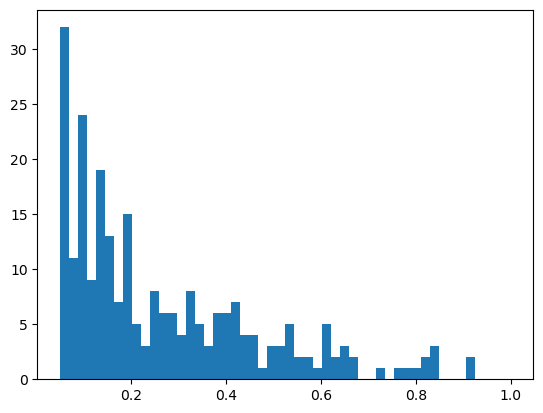

In [82]:
n = plt.hist(bit_counter_pct, bins=50, range = (0.05, 1.0))
 

## Set SELECTED_INDICES dictionary

In [215]:
SELECTION_INDICES_DICT = dict()
SELECTION_INDICES_DICT['1032-A'] = dict()
SELECTION_INDICES_DICT['13740-A'] = dict()
SELECTION_INDICES_DICT['13740-B'] = dict()


In [263]:
def display_frequencies(bit_pct, lower_limit, upper_limit):
    if isinstance(bit_pct, np.ndarray):
        s_bit_pct = pd.Series(bit_counter_pct)
    print(f" {FINGERPRINT_LENGTH} fingerprint")
    print(f"---------------------------------------")
    print()
    print(f" num of bits with < %  5 frequency      : {(s_bit_pct < 0.05).sum()}  ")
    print(f" num of bits with < % 10 frequency      : {(s_bit_pct < 0.10).sum()}  ")
    print(f" num of bits with < % 15 frequency      : {(s_bit_pct < 0.15).sum()}  ")
    print()
    print(f" num of bits with > %  5 frequency      : {(s_bit_pct > 0.05).sum()}  ")
    print(f" num of bits with > % 10 frequency      : {(s_bit_pct > 0.10).sum()}  ")
    print(f" num of bits with > % 15 frequency      : {(s_bit_pct > 0.15).sum()}  ")
    print()
    print(f" num of bits with > % 70 frequency      : {(s_bit_pct > 0.70).sum()}  ")
    print(f" num of bits with > % 75 frequency      : {(s_bit_pct > 0.75).sum()}  ")
    print(f" num of bits with > % 80 frequency      : {(s_bit_pct > 0.80).sum()}  ")
    print(f" num of bits with > % 85 frequency      : {(s_bit_pct > 0.85).sum()}  ")
    print(f" num of bits with > % 90 frequency      : {(s_bit_pct > 0.90).sum()}  ")
    print(f" num of bits with > % 95 frequency      : {(s_bit_pct > 0.95).sum()}  ")
    print()
    print(f" num of bits        F < %  5 frequency  : {s_bit_pct.between(0.00, 0.05, inclusive = 'left').sum()}  ")
    print(f" num of bits  5% <= F < % 10 frequency  : {s_bit_pct.between(0.05, 0.10, inclusive = 'both').sum()}  ")
    print(f" num of bits 10% <= F < % 15 frequency  : {s_bit_pct.between(0.10, 0.15, inclusive = 'left').sum()}  ")
    print()
    print(f" num of bits  5% <= F <= % 70 frequency : {s_bit_pct.between(0.05, 0.70, inclusive = 'both').sum()} ")
    print(f" num of bits  5% <= F <= % 75 frequency : {s_bit_pct.between(0.05, 0.75, inclusive = 'both').sum()} ")
    print(f" num of bits  5% <= F <= % 80 frequency : {s_bit_pct.between(0.05, 0.80, inclusive = 'both').sum()} ")
    print(f" num of bits  5% <= F <= % 85 frequency : {s_bit_pct.between(0.05, 0.85, inclusive = 'both').sum()} ")
    print(f" num of bits  5% <= F <= % 90 frequency : {s_bit_pct.between(0.05, 0.90, inclusive = 'both').sum()} ")
    print(f" num of bits  5% <= F <= % 95 frequency : {s_bit_pct.between(0.05, 0.95, inclusive = 'both').sum()} ")
    print(f" num of bits  5% <= F <= % 95 frequency : {s_bit_pct.between(0.05, 1.00, inclusive = 'both').sum()} ")
    print()

    bit_freq_select = (s_bit_pct >= lower_limit) & (s_bit_pct <= upper_limit)
    select_indices = np.arange(0, len(s_bit_pct))
    indicies_bw_limits = select_indices[bit_freq_select]
    print(f" Number of cols with frequency >=  {lower_limit * 100} % and <= {upper_limit*100} % : { bit_freq_select.sum()}")
    print(f" Indicies - len: {len(indicies_bw_limits)} : \n")
    print(indicies_bw_limits)
    return indicies_bw_limits

## 1032 FP-A between 5% and 70%

In [255]:
display_frequencies(bit_counter_pct, 0.05, 0.70)

 1032 fingerprint
---------------------------------------

 num of bits with < %  5 frequency      : 787  
 num of bits with < % 10 frequency      : 845  
 num of bits with < % 15 frequency      : 884  

 num of bits with > %  5 frequency      : 245  
 num of bits with > % 10 frequency      : 187  
 num of bits with > % 15 frequency      : 148  

 num of bits with > % 85 frequency      : 2  
 num of bits with > % 90 frequency      : 2  
 num of bits with > % 95 frequency      : 0  

 num of bits        F < %  5 frequency  : 787  
 num of bits  5% <= F < % 10 frequency  : 58  
 num of bits 10% <= F < % 15 frequency  : 39  

 num of bits  5% <= F <= % 70 frequency : 234 
 num of bits  5% <= F <= % 75 frequency : 235 
 num of bits  5% <= F <= % 80 frequency : 237 
 num of bits  5% <= F <= % 85 frequency : 243 
 num of bits  5% <= F <= % 90 frequency : 243 
 num of bits  5% <= F <= % 95 frequency : 245 
 num of bits  5% <= F <= % 95 frequency : 245 

 Number of cols with frequency > 5% and

array([  0,   4,  13,  16,  17,  18,  20,  22,  23,  26,  27,  30,  31,  32,  34,  35,  39,  42,  43,  44,  45,  48,  49,  52,  53,  56,  57,  78,
        79,  80,  82,  83,  84,  86,  87,  88,  91,  94,  95,  96,  98,  99, 100, 102, 103, 104, 106, 107, 108, 110, 111, 123, 127, 136, 137, 140,
       141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 178, 179,
       182, 183, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 213, 214, 215, 227, 231, 240, 241, 244, 245, 246, 247,
       248, 249, 250, 251, 252, 253, 254, 255, 266, 267, 270, 271, 284, 285, 287, 299, 302, 303, 364, 366, 370, 371, 372, 374, 375, 378, 379, 380,
       382, 383, 386, 387, 390, 406, 416, 417, 420, 421, 422, 423, 425, 426, 427, 428, 429, 430, 431, 433, 434, 435, 436, 437, 438, 439, 451, 453,
       455, 464, 465, 468, 469, 470, 471, 473, 474, 475, 477, 478, 479, 491, 493, 494, 509, 590, 591, 592, 594, 595, 5

In [217]:
SELECTION_INDICES_DICT['1032-A']['selcols0570'] =  np.array([
         0,   4,  13,  16,  17,  18,  20,  22,  23,  26,  27,  30,  31,  32,  34,  35,  39,  42,  43,  44,  45,  48,  49,  52,  53,  56,  57,  78,
        79,  80,  82,  83,  84,  86,  87,  88,  91,  94,  95,  96,  98,  99, 100, 102, 103, 104, 106, 107, 108, 110, 111, 123, 127, 136, 137, 140,
       141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 178, 179,
       182, 183, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 213, 214, 215, 227, 231, 240, 241, 244, 245, 246, 247,
       248, 249, 250, 251, 252, 253, 254, 255, 266, 267, 270, 271, 284, 285, 287, 299, 302, 303, 364, 366, 370, 371, 372, 374, 375, 378, 379, 380,
       382, 383, 386, 387, 390, 406, 416, 417, 420, 421, 422, 423, 425, 426, 427, 428, 429, 430, 431, 433, 434, 435, 436, 437, 438, 439, 451, 453,
       455, 464, 465, 468, 469, 470, 471, 473, 474, 475, 477, 478, 479, 491, 493, 494, 509, 590, 591, 592, 594, 595, 596, 598, 599, 602, 603, 604,
       606, 607, 632, 633, 636, 637, 638, 639, 641, 642, 643, 644, 645, 646, 647, 659, 662, 663, 673, 677, 679, 691, 695, 752, 756, 758, 759, 760,
       762, 763, 766, 767, 778, 779, 782, 797, 799, 813])
len(SELECTION_INDICES_DICT['1032-A']['selcols0570'])

234

## 1032 FP between 10% and 90%

In [264]:
display_frequencies(bit_counter_pct, 0.10, 0.90)

 1032 fingerprint
---------------------------------------

 num of bits with < %  5 frequency      : 787  
 num of bits with < % 10 frequency      : 845  
 num of bits with < % 15 frequency      : 884  

 num of bits with > %  5 frequency      : 245  
 num of bits with > % 10 frequency      : 187  
 num of bits with > % 15 frequency      : 148  

 num of bits with > % 70 frequency      : 11  
 num of bits with > % 75 frequency      : 10  
 num of bits with > % 80 frequency      : 8  
 num of bits with > % 85 frequency      : 2  
 num of bits with > % 90 frequency      : 2  
 num of bits with > % 95 frequency      : 0  

 num of bits        F < %  5 frequency  : 787  
 num of bits  5% <= F < % 10 frequency  : 58  
 num of bits 10% <= F < % 15 frequency  : 39  

 num of bits  5% <= F <= % 70 frequency : 234 
 num of bits  5% <= F <= % 75 frequency : 235 
 num of bits  5% <= F <= % 80 frequency : 237 
 num of bits  5% <= F <= % 85 frequency : 243 
 num of bits  5% <= F <= % 90 frequency :

array([  0,   1,   2,   4,   5,   6,   8,   9,  13,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  30,  31,  32,  33,  34,  35,  39,  42,  43,
        44,  45,  48,  49,  52,  53,  57,  78,  79,  80,  83,  84,  86,  87,  91,  94,  95,  96,  98,  99, 100, 102, 103, 104, 107, 108, 110, 111,
       127, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 162, 163, 164, 165, 166, 167, 179, 183,
       197, 198, 199, 200, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 213, 214, 215, 231, 244, 245, 246, 247, 250, 251, 252, 253, 254, 255,
       267, 270, 271, 285, 287, 366, 370, 371, 372, 374, 375, 378, 379, 382, 383, 387, 390, 417, 421, 422, 423, 425, 426, 427, 428, 429, 430, 431,
       433, 434, 435, 437, 438, 439, 464, 465, 468, 469, 470, 471, 473, 475, 477, 478, 479, 509, 595, 598, 599, 603, 606, 607, 633, 636, 637, 638,
       639, 641, 642, 643, 645, 646, 647, 677, 679, 752, 756, 758, 759, 763, 766, 767, 797])

In [218]:
SELECTION_INDICES_DICT['1032-A']['selcols1090'] =  np.array([    
         0,   1,   2,   4,   5,   6,   8,   9,  13,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  30,  31,  32,  33,  34,  35,  39,  42,  43,
        44,  45,  48,  49,  52,  53,  57,  78,  79,  80,  83,  84,  86,  87,  91,  94,  95,  96,  98,  99, 100, 102, 103, 104, 107, 108, 110, 111,
       127, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 162, 163, 164, 165, 166, 167, 179, 183,
       197, 198, 199, 200, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 213, 214, 215, 231, 244, 245, 246, 247, 250, 251, 252, 253, 254, 255,
       267, 270, 271, 285, 287, 366, 370, 371, 372, 374, 375, 378, 379, 382, 383, 387, 390, 417, 421, 422, 423, 425, 426, 427, 428, 429, 430, 431,
       433, 434, 435, 437, 438, 439, 464, 465, 468, 469, 470, 471, 473, 475, 477, 478, 479, 509, 595, 598, 599, 603, 606, 607, 633, 636, 637, 638,
       639, 641, 642, 643, 645, 646, 647, 677, 679, 752, 756, 758, 759, 763, 766, 767, 797])
len(SELECTION_INDICES_DICT['1032-A']['selcols1090'])

185

## 13740 FP-A between 10% and 90%

In [93]:
print(f" {FINGERPRINT_LENGTH} fingerprint")
print(f"---------------------------------------")
print(f" num of bits with < %  5 frequency : {(bit_counter_pct < 0.05).sum()}  ")
print(f" num of bits with < % 10 frequency : {(bit_counter_pct < 0.10).sum()}  ")
print(f" num of bits with < % 15 frequency : {(bit_counter_pct < 0.15).sum()}  ")
print()
print(f" num of bits with > %  5 frequency : {(bit_counter_pct > 0.05).sum()}  ")
print(f" num of bits with > % 10 frequency : {(bit_counter_pct > 0.10).sum()}  ")
print(f" num of bits with > % 15 frequency : {(bit_counter_pct > 0.15).sum()}  ")
print()
print(f" num of bits with > % 85 frequency : {(bit_counter_pct > 0.85).sum()}  ")
print(f" num of bits with > % 90 frequency : {(bit_counter_pct > 0.90).sum()}  ")
print(f" num of bits with > % 95 frequency : {(bit_counter_pct > 0.95).sum()}  ")
bit_counter_select = (bit_counter_pct > 0.10) & (bit_counter_pct < 0.90)
pct_bw_10_90 = bit_counter_select.sum()
print(f" Number of cols with frequency > %10 and < %90 : {pct_bw_10_90}")
select_indices = np.arange(0,FINGERPRINT_LENGTH)
indices_pct_bw_10_90 = select_indices[bit_counter_select]
print(f" Indicies corresponding to bits with a frequency between 10 and 90 percent - len: {len(indices_pct_bw_10_90)} :")
indices_pct_bw_10_90

 1032 fingerprint
---------------------------------------
 num of bits with < %  5 frequency : 787  
 num of bits with < % 10 frequency : 845  
 num of bits with < % 15 frequency : 884  

 num of bits with > %  5 frequency : 245  
 num of bits with > % 10 frequency : 187  
 num of bits with > % 15 frequency : 148  

 num of bits with > % 85 frequency : 2  
 num of bits with > % 90 frequency : 2  
 num of bits with > % 95 frequency : 0  
 Number of cols with frequency > %10 and < %90 : 185
 Indicies corresponding to bits with a frequency between 10 and 90 percent - len: 185 :


array([  0,   1,   2,   4,   5,   6,   8,   9,  13,  16,  17,  18,  19,  20,  21,  22,  23,  26,  27,  30,  31,  32,  33,  34,  35,  39,  42,  43,
        44,  45,  48,  49,  52,  53,  57,  78,  79,  80,  83,  84,  86,  87,  91,  94,  95,  96,  98,  99, 100, 102, 103, 104, 107, 108, 110, 111,
       127, 140, 141, 142, 143, 144, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 162, 163, 164, 165, 166, 167, 179, 183,
       197, 198, 199, 200, 202, 203, 204, 205, 206, 207, 208, 210, 211, 212, 213, 214, 215, 231, 244, 245, 246, 247, 250, 251, 252, 253, 254, 255,
       267, 270, 271, 285, 287, 366, 370, 371, 372, 374, 375, 378, 379, 382, 383, 387, 390, 417, 421, 422, 423, 425, 426, 427, 428, 429, 430, 431,
       433, 434, 435, 437, 438, 439, 464, 465, 468, 469, 470, 471, 473, 475, 477, 478, 479, 509, 595, 598, 599, 603, 606, 607, 633, 636, 637, 638,
       639, 641, 642, 643, 645, 646, 647, 677, 679, 752, 756, 758, 759, 763, 766, 767, 797])

In [219]:
SELECTION_INDICES_DICT['13740-A']['selcols1090'] = np.array(
      [    2,     3,     4,     6,     7,     8,    12,    13,    14,    17,    18,    21,    22,    23,    24,    33,    34,    41,    42,    43,
          44,    46,    47,    48,    49,    51,    52,    53,    54,    56,    57,    58,    59,    67,    69,    77,    78,    79,    82,    83,
          84,    86,    87,    88,    89,    99,   106,   107,   108,   109,   111,   112,   113,   114,   122,   124,   133,   134,   144,   290,
         291,   292,   347,   359,   383,   392,   397,   398,   402,   403,   404,   405,   472,   496,   511,   516,   517,   518,   573,   579,
         585,   608,   609,   619,   624,   629,   630,   631,   686,   698,   722,   731,   736,   741,   742,   743,   744,   970,  1163,  1180,
        1181,  1183,  1186,  1191,  1193,  1195,  1196,  1236,  1237,  1238,  1251,  1263,  1274,  1287,  1299,  1304,  1306,  1307,  1308,  1309,
        1348,  1349,  1350,  1351,  1373,  1375,  1376,  1387,  1389,  1400,  1410,  1411,  1412,  1414,  1416,  1417,  1419,  1420,  1421,  1422,
        1464,  1483,  1489,  1502,  1513,  1520,  1525,  1530,  1532,  1534,  1535,  1761,  1977,  1982,  1985,  1986,  1987,  2042,  2048,  2052,
        2053,  2054,  2076,  2078,  2088,  2089,  2090,  2093,  2095,  2098,  2099,  2100,  2155,  2159,  2167,  2191,  2196,  2198,  2203,  2208,
        2210,  2211,  2212,  2213,  2439,  2630,  2653,  2654,  2655,  2657,  2658,  2660,  2662,  2663,  2664,  2665,  2726,  2732,  2756,  2763,
        2768,  2773,  2775,  2776,  2777,  2778,  2958,  3002,  3004,  3215,  3220,  3225,  3230,  3456,  4357,  4402,  4470,  4471,  4472,  4473,
        4515,  4583,  4584,  4585,  4586,  4628,  4696,  5136,  5141,  5146,  5149,  5151,  5193,  5216,  5218,  5225,  5242,  5249,  5252,  5254,
        5259,  5262,  5263,  5264,  5306,  5331,  5355,  5362,  5374,  5375,  5376,  5377,  5765,  5814,  5819,  5821,  5824,  5826,  5827,  5828,
        5829,  5871,  5896,  5920,  5927,  5939,  5940,  5941,  5942,  6379,  7591,  7615,  7635,  7636,  7637,  7748,  7749,  7750,  8167,  8190,
        8191,  8192,  8194,  8197,  8199,  8200,  8201,  8202,  8269,  8293,  8300,  8305,  8310,  8312,  8314,  8315,  8757,  8762,  8767,  9833,
        9862,  9894,  9895,  9896,  9897,  9939,  9964,  9988, 10007, 10008, 10009, 10010, 10447, 10457, 10462])
len(SELECTION_INDICES_DICT['13740-A']['selcols1090'])

315

## 13740 FP-A between 5% and 70%

In [77]:
display_frequencies(bit_counter_pct, 0.05, 0.70)

0        0.000000
1        0.096629
2        0.455564
3        0.307608
4        0.883166
           ...   
13735    0.000000
13736    0.000026
13737    0.000052
13738    0.000000
13739    0.000182
Length: 13740, dtype: float64

In [42]:
print(f" {FINGERPRINT_LENGTH} fingerprint")
print(f"---------------------------------------")
print(f" num of bits        F < %  5 frequency : {s_bit_counter_pct.between(0.00, 0.05, inclusive = 'left').sum()}  ")
print(f" num of bits  5% <= F < % 10 frequency : {s_bit_counter_pct.between(0.05, 0.10, inclusive = 'both').sum()}  ")
print(f" num of bits 10% <= F < % 15 frequency : {s_bit_counter_pct.between(0.10, 0.15, inclusive = 'left').sum()}  ")
print()
print(f" num of bits with > %  5 frequency : {(s_bit_counter_pct > 0.05).sum()}  ")
print(f" num of bits with > % 10 frequency : {(s_bit_counter_pct > 0.10).sum()}  ")
print(f" num of bits with > % 15 frequency : {(s_bit_counter_pct > 0.15).sum()}  ")
print()
print(f" num of bits  5% <= F <= % 70 frequency : {s_bit_counter_pct.between(0.05, 0.70, inclusive = 'both').sum()} ")
print(f" num of bits  5% <= F <= % 75 frequency : {s_bit_counter_pct.between(0.05, 0.75, inclusive = 'both').sum()} ")
print(f" num of bits  5% <= F <= % 80 frequency : {s_bit_counter_pct.between(0.05, 0.80, inclusive = 'both').sum()} ")
print(f" num of bits  5% <= F <= % 85 frequency : {s_bit_counter_pct.between(0.05, 0.85, inclusive = 'both').sum()} ")
print(f" num of bits  5% <= F <= % 90 frequency : {s_bit_counter_pct.between(0.05, 0.90, inclusive = 'both').sum()} ")
print(f" num of bits  5% <= F <= % 95 frequency : {s_bit_counter_pct.between(0.05, 0.95, inclusive = 'both').sum()} ")
print(f" num of bits  5% <= F <= % 95 frequency : {s_bit_counter_pct.between(0.05, 1.00, inclusive = 'both').sum()} ")
# bit_counter_select = (bit_counter_pct > 0.10) & (bit_counter_pct < 0.90)
# pct_bw_10_90 = bit_counter_select.sum()
# print(f" Number of cols with frequency > %10 and < %90 : {pct_bw_10_90}")
bit_counter_select = (bit_counter_pct >= 0.05) & (bit_counter_pct <= 0.70)
pct_bw_05_70 = bit_counter_select.sum()
print(f" Number of cols with frequency > 5% and < %70 : {pct_bw_05_70}")
# bit_counter_select[:20]
# bit_counter_select.shape
select_indices = np.arange(0,FINGERPRINT_LENGTH)
indices_pct_bw_05_70 = select_indices[bit_counter_select]
print(f" Indicies corresponding to bits with a frequency between 5% and 70% - len: {len(indices_pct_bw_05_70)} :")
indices_pct_bw_05_70

 13740 fingerprint
---------------------------------------
 num of bits        F < %  5 frequency : 13196  
 num of bits  5% <= F < % 10 frequency : 230  
 num of bits 10% <= F < % 15 frequency : 81  

 num of bits with > %  5 frequency : 544  
 num of bits with > % 10 frequency : 314  
 num of bits with > % 15 frequency : 233  

 num of bits  5% <= F <= % 70 frequency : 533 
 num of bits  5% <= F <= % 75 frequency : 536 
 num of bits  5% <= F <= % 80 frequency : 537 
 num of bits  5% <= F <= % 85 frequency : 541 
 num of bits  5% <= F <= % 90 frequency : 542 
 num of bits  5% <= F <= % 95 frequency : 544 
 num of bits  5% <= F <= % 95 frequency : 544 
 Number of cols with frequency > 5% and < %70 : 533
 Indicies corresponding to bits with a frequency between 5% and 70% - len: 533 :


array([    1,     2,     3,     6,     7,     8,    12,    13,    18,    21,    22,    23,    33,    34,    41,    42,    43,    44,    46,    47,
          48,    51,    52,    53,    56,    57,    58,    59,    67,    69,    76,    77,    78,    79,    82,    83,    86,    87,    88,    89,
          98,    99,   106,   107,   108,   109,   111,   112,   113,   114,   122,   123,   124,   131,   133,   134,   142,   144,   286,   289,
         290,   291,   292,   334,   347,   353,   359,   365,   380,   381,   382,   383,   387,   392,   393,   397,   398,   399,   402,   403,
         404,   405,   447,   460,   472,   489,   495,   496,   511,   516,   517,   518,   560,   573,   579,   583,   584,   585,   602,   607,
         608,   609,   619,   624,   625,   630,   673,   686,   692,   698,   704,   721,   722,   726,   731,   732,   736,   737,   741,   742,
         743,   744,   924,   969,   970,  1134,  1156,  1163,  1169,  1178,  1179,  1180,  1181,  1183,  1185,  1186,

In [221]:
SELECTION_INDICES_DICT['13740-A']['selcols0570']  = np.array([
           1,     2,     3,     6,     7,     8,    12,    13,    18,    21,    22,    23,    33,    34,    41,    42,    43,    44,    46,    47,
          48,    51,    52,    53,    56,    57,    58,    59,    67,    69,    76,    77,    78,    79,    82,    83,    86,    87,    88,    89,
          98,    99,   106,   107,   108,   109,   111,   112,   113,   114,   122,   123,   124,   131,   133,   134,   142,   144,   286,   289,
         290,   291,   292,   334,   347,   353,   359,   365,   380,   381,   382,   383,   387,   392,   393,   397,   398,   399,   402,   403,
         404,   405,   447,   460,   472,   489,   495,   496,   511,   516,   517,   518,   560,   573,   579,   583,   584,   585,   602,   607,
         608,   609,   619,   624,   625,   630,   673,   686,   692,   698,   704,   721,   722,   726,   731,   732,   736,   737,   741,   742,
         743,   744,   924,   969,   970,  1134,  1156,  1163,  1169,  1178,  1179,  1180,  1181,  1183,  1185,  1186,  1188,  1190,  1191,  1193,
        1194,  1195,  1196,  1234,  1235,  1236,  1237,  1238,  1251,  1260,  1261,  1262,  1263,  1274,  1276,  1282,  1284,  1285,  1287,  1297,
        1298,  1299,  1302,  1303,  1304,  1306,  1307,  1308,  1309,  1341,  1344,  1348,  1349,  1350,  1351,  1364,  1366,  1373,  1374,  1375,
        1376,  1387,  1389,  1395,  1397,  1398,  1399,  1400,  1410,  1411,  1412,  1414,  1415,  1416,  1417,  1419,  1420,  1421,  1422,  1461,
        1463,  1464,  1483,  1486,  1488,  1489,  1502,  1508,  1510,  1512,  1513,  1517,  1519,  1520,  1524,  1525,  1529,  1530,  1532,  1533,
        1534,  1535,  1690,  1715,  1739,  1756,  1759,  1761,  1976,  1977,  1982,  1984,  1985,  1986,  1987,  2042,  2048,  2052,  2053,  2054,
        2073,  2076,  2077,  2078,  2088,  2089,  2090,  2093,  2094,  2095,  2098,  2099,  2100,  2155,  2159,  2161,  2165,  2167,  2189,  2191,
        2196,  2197,  2198,  2200,  2203,  2206,  2208,  2210,  2211,  2212,  2213,  2393,  2438,  2439,  2607,  2609,  2630,  2632,  2633,  2653,
        2654,  2655,  2657,  2658,  2659,  2660,  2662,  2663,  2664,  2665,  2720,  2724,  2726,  2730,  2731,  2732,  2751,  2753,  2755,  2756,
        2760,  2761,  2762,  2763,  2767,  2768,  2772,  2773,  2775,  2776,  2777,  2778,  2956,  2958,  2982,  2999,  3002,  3003,  3004,  3197,
        3214,  3215,  3220,  3225,  3229,  3230,  3385,  3410,  3434,  3451,  3454,  3456,  4352,  4357,  4359,  4400,  4401,  4402,  4438,  4444,
        4451,  4461,  4466,  4470,  4471,  4472,  4473,  4512,  4513,  4514,  4515,  4540,  4561,  4564,  4579,  4583,  4584,  4585,  4586,  4628,
        4674,  4696,  4697,  4698,  4923,  5090,  5136,  5140,  5141,  5146,  5149,  5150,  5151,  5184,  5187,  5193,  5203,  5208,  5213,  5216,
        5217,  5218,  5225,  5227,  5235,  5240,  5241,  5242,  5248,  5249,  5252,  5254,  5257,  5259,  5262,  5263,  5264,  5306,  5316,  5323,
        5331,  5355,  5362,  5367,  5372,  5374,  5375,  5376,  5377,  5557,  5602,  5603,  5765,  5768,  5790,  5792,  5794,  5813,  5814,  5817,
        5819,  5821,  5822,  5823,  5824,  5826,  5827,  5828,  5829,  5871,  5881,  5896,  5920,  5927,  5932,  5937,  5939,  5940,  5941,  5942,
        6097,  6158,  6166,  6168,  6379,  6389,  6610,  7522,  7523,  7524,  7591,  7613,  7615,  7625,  7630,  7635,  7636,  7637,  7704,  7728,
        7747,  7748,  7749,  7750,  8146,  8167,  8170,  8190,  8191,  8192,  8194,  8195,  8196,  8197,  8199,  8200,  8201,  8202,  8253,  8259,
        8261,  8263,  8267,  8268,  8269,  8283,  8290,  8293,  8300,  8305,  8310,  8312,  8313,  8314,  8315,  8495,  8536,  8539,  8541,  8752,
        8757,  8762,  8767,  8993,  9833,  9862,  9885,  9889,  9890,  9894,  9895,  9896,  9897,  9927,  9938,  9939,  9963,  9964,  9988, 10007,
       10008, 10009, 10010, 10165, 10190, 10234, 10236, 10447, 10452, 10457, 10462, 10678, 10688])

len(SELECTION_INDICES_DICT['13740-A']['selcols0570'])

533

## 13740 FP-B between 5% and 70%

In [219]:
display_frequencies(bit_counter_pct, 0.05, 0.70)

0        0.511306
1        0.700512
2        0.697656
3        0.446015
4        0.207983
           ...   
13735    0.000017
13736    0.000017
13737    0.000061
13738    0.000009
13739    0.000061
Length: 13740, dtype: float64

In [222]:
SELECTION_INDICES_DICT['13740-B']['selcols0570'] = np.array([
           0,     2,     3,     4,     8,     9,    10,    12,    13,    14,    18,    19,    22,    23,    24,    31,    32,    33,    40,    41,
          42,    43,    45,    47,    48,    50,    52,    53,    54,    55,    56,    57,    58,    65,    66,    67,    75,    76,    77,    78,
          80,    82,    83,    84,    85,    86,    87,    88,    96,    97,   105,   106,   107,   108,   109,   110,   111,   112,   113,   114,
         120,   121,   122,   123,   130,   131,   132,   133,   140,   141,   142,   203,   204,   227,   228,   232,   233,   256,   257,   258,
         261,   262,   280,   284,   285,   288,   289,   293,   296,   297,   301,   302,   307,   312,   316,   317,   321,   322,   323,   328,
         329,   333,   335,   340,   341,   345,   346,   350,   351,   352,   357,   364,   365,   369,   370,   374,   375,   380,   391,   392,
         396,   401,   406,   410,   414,   415,   420,   429,   430,   435,   436,   441,   453,   454,   458,   459,   464,   465,   470,   478,
         482,   483,   484,   487,   488,   505,   506,   510,   511,   519,   522,   523,   527,   528,   532,   533,   538,   542,   543,   547,
         548,   549,   553,   554,   555,   559,   566,   567,   571,   572,   576,   577,   578,   583,   584,   591,   595,   596,   600,   601,
         606,   607,   618,   619,   622,   623,   627,   628,   632,   635,   636,   641,   646,   651,   655,   656,   660,   661,   662,   667,
         668,   672,   674,   679,   680,   684,   685,   689,   690,   691,   696,   703,   704,   708,   713,   714,   719,   730,   731,   735,
         740,   887,   906,   935,  1084,  1085,  1103,  1104,  1105,  1108,  1109,  1126,  1127,  1128,  1131,  1132,  1133,  1134,  1151,  1152,
        1153,  1156,  1160,  1176,  1197,  1200,  1201,  1202,  1204,  1205,  1206,  1209,  1210,  1211,  1214,  1216,  1217,  1220,  1221,  1222,
        1225,  1226,  1227,  1228,  1230,  1231,  1240,  1241,  1244,  1245,  1246,  1247,  1249,  1250,  1254,  1266,  1269,  1270,  1273,  1274,
        1278,  1279,  1297,  1301,  1310,  1311,  1313,  1314,  1315,  1317,  1318,  1319,  1320,  1322,  1323,  1324,  1326,  1327,  1329,  1330,
        1331,  1333,  1334,  1335,  1338,  1339,  1340,  1341,  1344,  1346,  1349,  1353,  1354,  1357,  1358,  1359,  1360,  1362,  1363,  1365,
        1367,  1373,  1378,  1379,  1382,  1383,  1384,  1386,  1387,  1391,  1396,  1406,  1423,  1424,  1426,  1427,  1428,  1431,  1432,  1435,
        1436,  1437,  1440,  1442,  1443,  1444,  1447,  1448,  1451,  1452,  1453,  1454,  1457,  1466,  1467,  1471,  1472,  1473,  1480,  1490,
        1491,  1492,  1495,  1653,  1657,  1673,  1696,  1697,  1895,  1898,  1899,  1900,  1918,  1919,  1923,  1924,  1927,  1928,  1948,  1952,
        1988,  1989,  1991,  1992,  1996,  1997,  2001,  2002,  2007,  2008,  2009,  2011,  2012,  2013,  2016,  2017,  2018,  2019,  2022,  2023,
        2028,  2031,  2032,  2035,  2036,  2037,  2038,  2040,  2041,  2043,  2045,  2046,  2047,  2052,  2056,  2057,  2060,  2061,  2062,  2064,
        2065,  2069,  2070,  2075,  2084,  2101,  2104,  2105,  2109,  2110,  2115,  2120,  2121,  2122,  2124,  2125,  2126,  2129,  2130,  2131,
        2132,  2135,  2136,  2143,  2144,  2145,  2148,  2149,  2150,  2151,  2153,  2154,  2158,  2159,  2165,  2168,  2169,  2170,  2182,  2183,
        2331,  2356,  2375,  2553,  2554,  2572,  2573,  2574,  2576,  2577,  2578,  2596,  2597,  2598,  2600,  2601,  2602,  2603,  2605,  2606,
        2608,  2621,  2622,  2625,  2626,  2627,  2628,  2629,  2630,  2634,  2645,  2648,  2649,  2652,  2653,  2656,  2657,  2661,  2666,  2667,
        2669,  2670,  2671,  2674,  2675,  2679,  2680,  2685,  2686,  2687,  2689,  2690,  2691,  2694,  2695,  2696,  2697,  2700,  2701,  2702,
        2706,  2708,  2709,  2710,  2713,  2714,  2715,  2716,  2718,  2721,  2723,  2724,  2733,  2734,  2735,  2738,  2740,  2747,  2758,  2895,
        2896,  2901,  2915,  2917,  2920,  2921,  2939,  2940,  2944,  3138,  3142,  3143,  3161,  3162,  3166,  3167,  3168,  3186,  3187,  3190,
        4267,  4295,  4324,  4364,  4369,  4380,  4384,  4385,  4389,  4395,  4408,  4409,  4413,  4414,  4438,  4477,  4482,  4487,  4493,  4497,
        4502,  4503,  4508,  4521,  4522,  4526,  4531,  4551,  4590,  4595,  4615,  4644,  5039,  5040,  5058,  5059,  5060,  5062,  5063,  5082,
        5083,  5087,  5088,  5091,  5112,  5116,  5153,  5154,  5155,  5156,  5157,  5160,  5161,  5162,  5165,  5171,  5172,  5173,  5175,  5176,
        5177,  5178,  5180,  5181,  5182,  5186,  5187,  5195,  5196,  5197,  5199,  5200,  5204,  5205,  5210,  5225,  5228,  5229,  5266,  5268,
        5269,  5270,  5273,  5274,  5286,  5288,  5289,  5293,  5294,  5295,  5300,  5312,  5317,  5318,  5323,  5717,  5718,  5736,  5737,  5738,
        5740,  5741,  5743,  5760,  5761,  5762,  5764,  5765,  5769,  5785,  5789,  5790,  5793,  5794,  5798,  5831,  5833,  5834,  5835,  5838,
        5839,  5840,  5851,  5853,  5856,  5858,  5859,  5865,  5875,  5882,  5888,  6303,  7435,  7525,  7528,  7529,  7534,  7544,  7548,  7549,
        7553,  7554,  7560,  7572,  7573,  7577,  7578,  7583,  7641,  7642,  7661,  7662,  7666,  7667,  7685,  7690,  7696,  8090,  8091,  8109,
        8110,  8111,  8113,  8114,  8115,  8133,  8134,  8135,  8137,  8138,  8139,  8140,  8142,  8158,  8159,  8162,  8163,  8166,  8167,  8171,
        8204,  8206,  8207,  8208,  8211,  8212,  8216,  8222,  8223,  8224,  8226,  8227,  8228,  8231,  8232,  8233,  8234,  8238,  8246,  8247,
        8252,  8253,  8255,  8261,  8433,  8452,  8454,  8656,  8675,  8676,  8679,  8680,  8698,  8699,  8704,  8705,  9785,  9804,  9808,  9832,
        9833,  9837,  9857,  9861,  9862,  9866,  9898,  9901,  9902,  9906,  9907,  9911,  9912,  9921,  9926,  9927,  9932,  9933,  9950,  9956,
       10127, 10370, 10375])
len(SELECTION_INDICES_DICT['13740-B']['selcols0570'])

803

In [223]:
del dense_mat

## Pharmacophore frequency histogram

In [101]:
# the histogram of the data
def box_plot(array,start = 0, end = 0, upper = 120000, highline = None, lowline = None, width = 0.4):
    
    _= plt.figure(figsize=(20, 5))
    # _= plt.bar(np.arange((end - start)), array[start:end], width = 0.4 ) 
    _= plt.bar(np.arange(len(array)), array, width = width ) 
    # _= plt.bar(bit_counter, tick_label=df_well_use_counts.index, width = 0.4 ) 
    ##  , facecolor='g', alpha=0.75, rwidth=1.0, orientation='horizontal')
    y_max = array.max()
    ylow, yhigh = plt.ylim()
    y_highline = y_max*highline
    y_lowline  = y_max*lowline
    _= plt.ylim(0, upper)
    if highline is not None and y_highline < upper:
        _= plt.axhline(y= y_highline, color="red", linestyle="--")
        _= plt.text(start + 25, y_highline + ((yhigh-ylow)*0.03), f'{highline} line - {y_highline:.2f}') ##  r'$\mu=100,\ \sigma=15$')
    if lowline is not None:
        _= plt.axhline(y=y_lowline, color="red", linestyle="--")
        _= plt.text(end - 25, y_lowline + ((yhigh-ylow)*0.03), f'{lowline} line - {y_lowline:.2f}') ##  r''$\mu=lowline,\ \sigma=15$')
    _= plt.xlabel('pharmacophore bit')
    _= plt.ylabel('# of Compounds with bit = 1')
    _= plt.title('Pharmacophore bit frequency ')
    _= plt.xlim(start-1, end+0.75)
    _= plt.grid(True)
    plt.show()

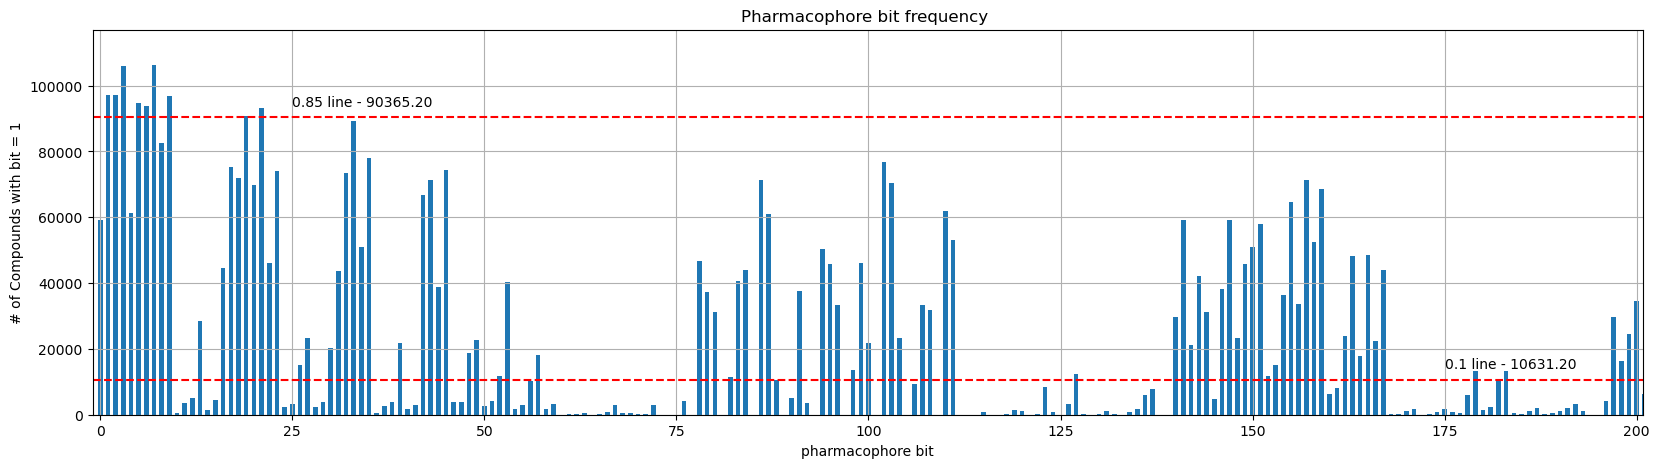

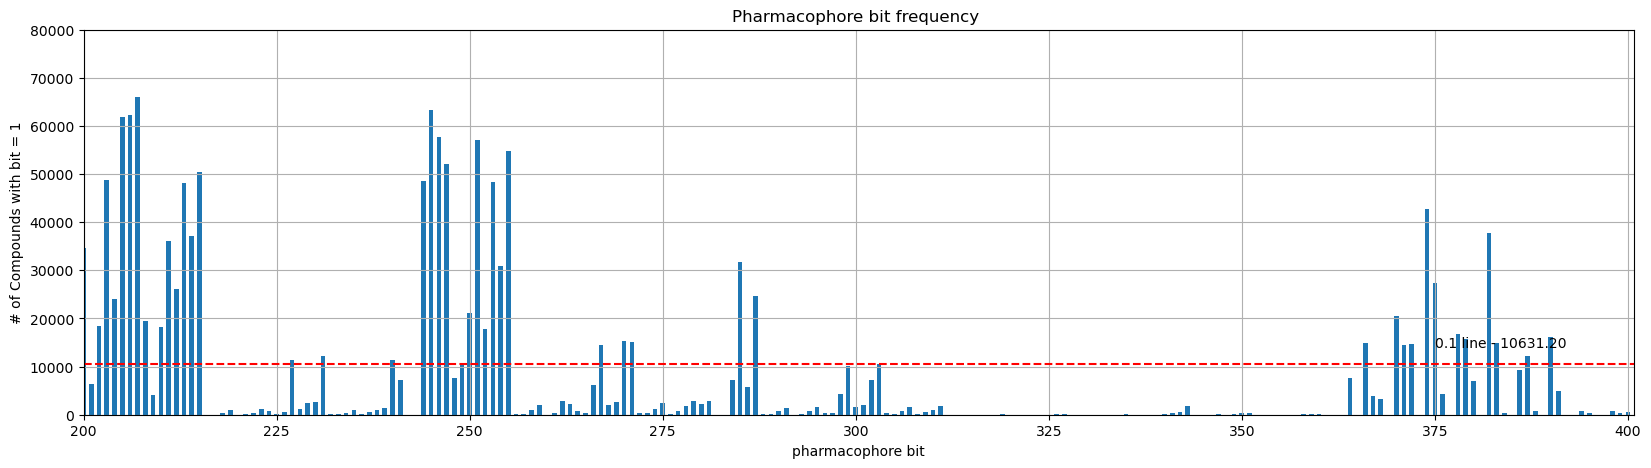

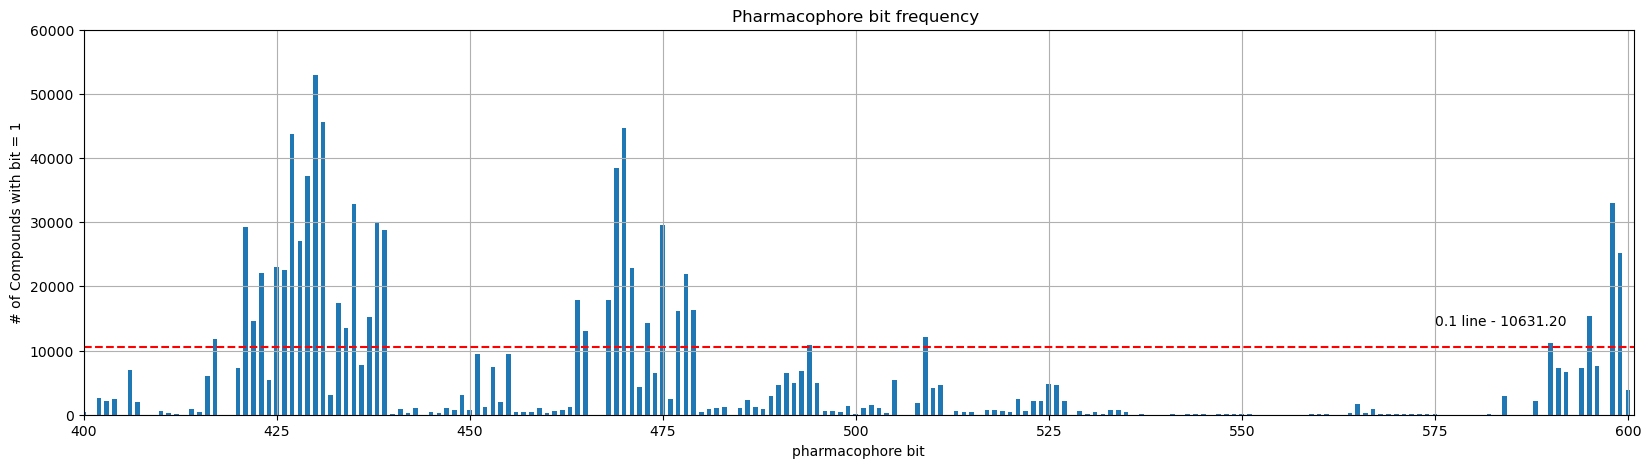

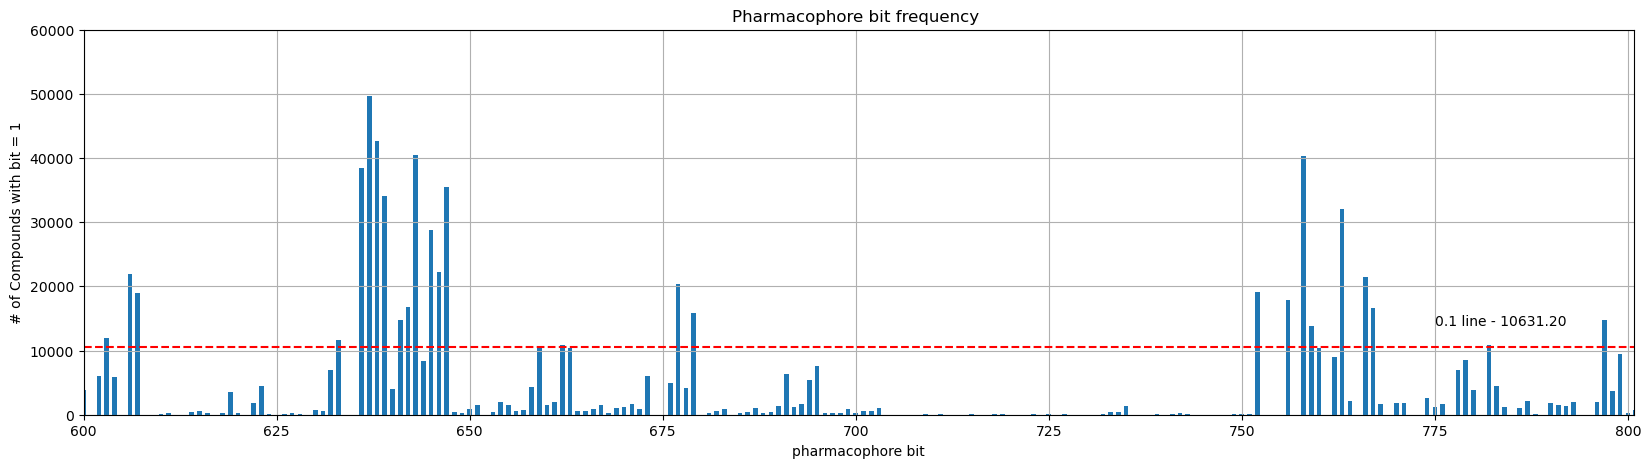

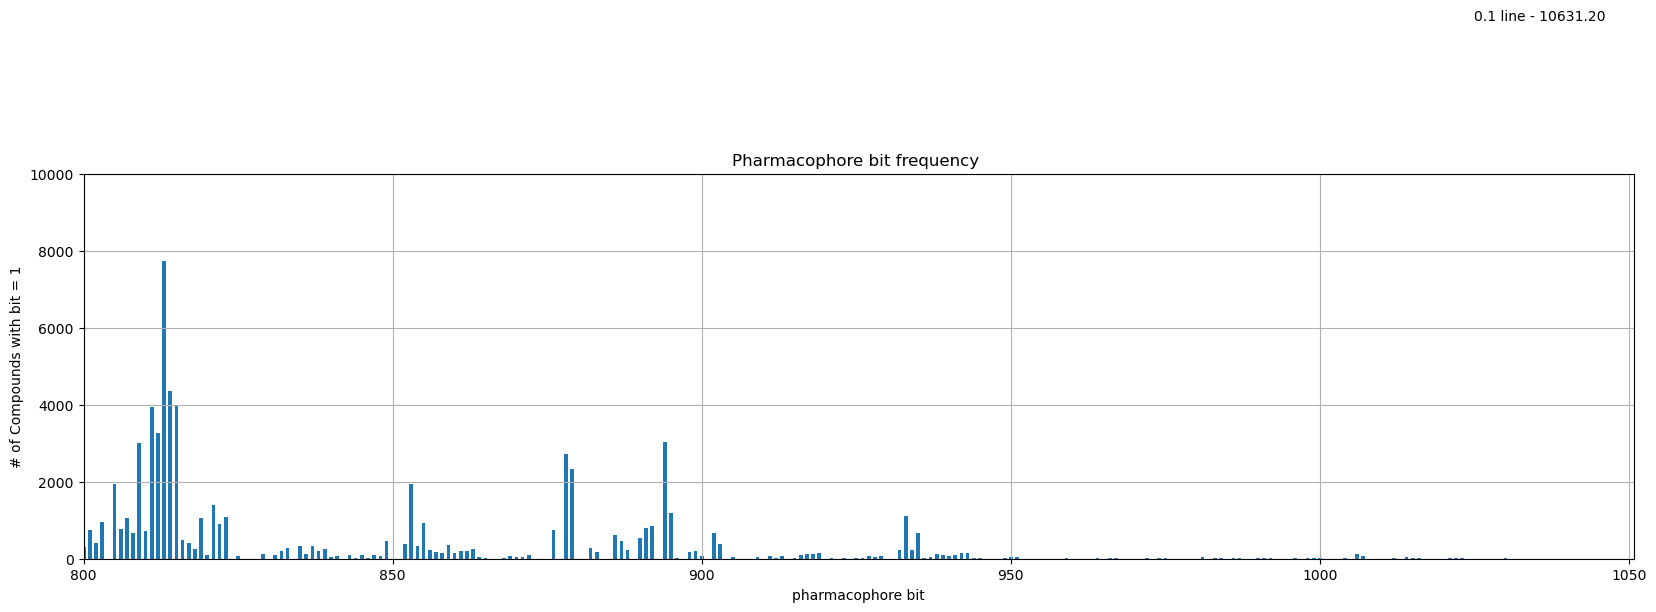

In [102]:
highline =  0.90
lowline =   0.10
box_plot(bit_counter,   0,  200, upper = 117000, highline = 0.85, lowline = 0.10, width = 0.6)
box_plot(bit_counter, 201,  400, upper =  80000, highline = highline, lowline = lowline, width = 0.6)
box_plot(bit_counter, 401,  600, upper =  60000, highline = highline, lowline = lowline, width = 0.6)
box_plot(bit_counter, 601,  800, upper =  60000, highline = highline, lowline = lowline, width = 0.6)
box_plot(bit_counter, 801, 1050, upper =  10000, highline = highline, lowline = lowline, width = 0.6)

In [103]:
# box_plot(bit_counter_pct,   0,  200, upper = 0.10, highline = highline, lowline = lowline, width = 0.6)
# box_plot(bit_counter_pct, 201,  400, upper = 0.10, highline = highline, lowline = lowline, width = 0.6)
# box_plot(bit_counter_pct, 401,  600, upper = 0.10, highline = highline, lowline = lowline, width = 0.6)
# box_plot(bit_counter_pct, 601,  800, upper = 0.10, highline = highline, lowline = lowline, width = 0.6)
# box_plot(bit_counter_pct, 801, 1050, upper = 0.10, highline = highline, lowline = lowline, width = 0.6)

# Keep Pharmacohpore columns within a predefined frequency (e.g.  10%< F < 90%)
  #### Read pharmacophores of selected compounds in Hash or Compound order

In [107]:
# FINGERPRINT_LENGTH = 13740
# PP_LENGTH = str(FINGERPRINT_LENGTH) + FINGERPRINT_SUFFIX
TYPE = 'selcmpnds'
# TYPE = 'selcmpnds'
ORDER = 'hash_order'
print(f" compound Pharmacophore Pickle File  : {ds.compoundPharmacophoreSelectedPickleFile}")
print(f" Selected Pharmacophore CSV    File  : {ds.compoundPharmacophoreSelectedCSVFile}")
print(f" Selected Pharmacophore CSV Zip File : {ds.compoundPharmacophoreSelectedCSVZipFile}")
# print(f" compound Pharmacophore NumPy File : {ds.compoundPharmacophoreSelectedNumPyFile}")
# print(f" compound Pharmacophore NumPy Zipped File : {ds.compoundPharmacophoreSelectedNumPyZipFile}")
print()
compoundPharmacophoreSelectedPickleFile  = ds.compoundPharmacophoreSelectedPickleFile.format(pp_length = PP_LENGTH, type = TYPE, order= ORDER)
compoundPharmacophoreSelectedCSVFile     = ds.compoundPharmacophoreSelectedCSVFile.format(pp_length = PP_LENGTH, type = TYPE, order= ORDER)
compoundPharmacophoreSelectedCSVZipFile  = ds.compoundPharmacophoreSelectedCSVZipFile.format(pp_length = PP_LENGTH, type = TYPE, order= ORDER)
# compoundPharmacophoreSelectedNumPyFile    = ds.compoundPharmacophoreSelectedNumPyFile.format(pp_length = FINGERPRINT_LENGTH, type = TYPE, order= ORDER)
# compoundPharmacophoreSelectedNumPyZipFile = ds.compoundPharmacophoreSelectedNumPyZipFile.format(pp_length = FINGERPRINT_LENGTH, type = TYPE, order= ORDER)
print()
print(f" compound Pharmacophore Pickle File  : {compoundPharmacophoreSelectedPickleFile}")
print(f" Selected Pharmacophore CSV    File  : {compoundPharmacophoreSelectedCSVFile}")
print(f" Selected Pharmacophore CSV Zip File : {compoundPharmacophoreSelectedCSVZipFile}")
# print(f" compound Pharmacophore NumPy File : {compoundPharmacophoreSelectedNumPyFile}")
# print(f" compound Pharmacophore NumPy Zipped File : {compoundPharmacophoreSelectedNumPyZipFile}")

 compound Pharmacophore Pickle File  : ../output_11102023/compound_pharmacophores_{pp_length}_{type}_{order}.pkl
 Selected Pharmacophore CSV    File  : ../output_11102023/compound_pharmacophores_{pp_length}_{type}_{order}.csv
 Selected Pharmacophore CSV Zip File : ../output_11102023/compound_pharmacophores_{pp_length}_{type}_{order}.gz


 compound Pharmacophore Pickle File  : ../output_11102023/compound_pharmacophores_1032-A_selcmpnds_hash_order.pkl
 Selected Pharmacophore CSV    File  : ../output_11102023/compound_pharmacophores_1032-A_selcmpnds_hash_order.csv
 Selected Pharmacophore CSV Zip File : ../output_11102023/compound_pharmacophores_1032-A_selcmpnds_hash_order.gz


In [108]:
# try:
#     del df_selected_fingerprints
# except:
#     pass
df_selected_fingerprints= pd.read_pickle(compoundPharmacophoreSelectedPickleFile)
# df_selected_fingerprints= pd.read_pickle(inputFile)
# df_selected_fingerprints= pd.read_csv(inputFile)
# df_selected_fingerprints= pd.read_csv(compoundPharmacophoreSelectedCSVZipFile)
 

In [109]:
df_selected_fingerprints.shape
df_selected_fingerprints.info()
df_selected_fingerprints.head(4)
df_selected_fingerprints.tail(4)
ROW_COUNT = len(df_selected_fingerprints)
ROW_COUNT

(115514, 1035)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115514 entries, 0 to 115513
Columns: 1035 entries, Metadata_JCP2022 to 1031
dtypes: int64(1034), object(1)
memory usage: 912.1+ MB


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,...,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031
0,JCP2022_006020,-9223347314827979542,10,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,JCP2022_058905,-9223229703754907651,13,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,JCP2022_051160,-9223005963369866647,9,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,JCP2022_038591,-9222975330808494972,4,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,...,1022,1023,1024,1025,1026,1027,1028,1029,1030,1031
115510,JCP2022_110705,9222418181275619136,0,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
115511,JCP2022_017353,9222499262440709243,11,1,1,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
115512,JCP2022_040466,9222528730267146426,10,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
115513,JCP2022_102583,9223213570900537648,0,0,1,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


115514

## Select columns between intended frequency

In [265]:
PP_LENGTH
SELCOMPNDS
SELECTED_INDICIES = SELECTION_INDICES_DICT[pp_length][selcols]
STR_SELECTED_INDICIES = [str(x) for x in SELECTED_INDICIES]
len(SELECTED_INDICIES), SELECTED_INDICIES[:10]
len(STR_SELECTED_INDICIES), STR_SELECTED_INDICIES[:10]

'1032-A'

NameError: name 'SELCOMPNDS' is not defined

In [157]:
SELECTED_COLUMNS = ['Metadata_JCP2022',	'Metadata_Hash', 'Metadata_Bin']
SELECTED_COLUMNS.extend(SELECTED_INDICIES)
len(SELECTED_COLUMNS), SELECTED_COLUMNS[:10]

STR_SELECTED_COLUMNS = ['Metadata_JCP2022',	'Metadata_Hash', 'Metadata_Bin']
STR_SELECTED_COLUMNS.extend(STR_SELECTED_INDICIES)
len(STR_SELECTED_COLUMNS), STR_SELECTED_COLUMNS[:10]

(237,
 ['Metadata_JCP2022',
  'Metadata_Hash',
  'Metadata_Bin',
  0,
  4,
  13,
  16,
  17,
  18,
  20])

(237,
 ['Metadata_JCP2022',
  'Metadata_Hash',
  'Metadata_Bin',
  '0',
  '4',
  '13',
  '16',
  '17',
  '18',
  '20'])

In [158]:
df_selected_fingerprints[STR_SELECTED_COLUMNS]

,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,4,13,16,17,18,20,...,762,763,766,767,778,779,782,797,799,813
0,JCP2022_006020,-9223347314827979542,10,1,0,1,1,0,1,1,...,0,0,0,0,0,0,1,0,0,1
1,JCP2022_058905,-9223229703754907651,13,1,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,JCP2022_051160,-9223005963369866647,9,0,1,0,0,1,1,1,...,1,0,0,0,0,0,0,0,0,0
3,JCP2022_038591,-9222975330808494972,4,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,JCP2022_100039,-9222864758624474277,11,0,0,0,0,1,1,1,...,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115509,JCP2022_060479,9222285918691659081,9,0,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
115510,JCP2022_110705,9222418181275619136,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
115511,JCP2022_017353,9222499262440709243,11,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0
115512,JCP2022_040466,9222528730267146426,10,1,1,0,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0


## Write selected compound and selected columns of pharmacophore

In [159]:
# FINGERPRINT_LENGTH = 13740
# PP_LENGTH = str(FINGERPRINT_LENGTH) + FINGERPRINT_SUFFIX
TYPE = 'selcols0570'
# TYPE = 'selcols1090'
ORDER = 'hash_order'
print(f" compound Pharmacophore Pickle File  : {ds.compoundPharmacophoreSelectedPickleFile}")
print(f" Selected Pharmacophore CSV    File  : {ds.compoundPharmacophoreSelectedCSVFile}")
print(f" Selected Pharmacophore CSV Zip File : {ds.compoundPharmacophoreSelectedCSVZipFile}")
# print(f" compound Pharmacophore NumPy File : {ds.compoundPharmacophoreSelectedNumPyFile}")
# print(f" compound Pharmacophore NumPy Zipped File : {ds.compoundPharmacophoreSelectedNumPyZipFile}")
print()
compoundPharmacophoreSelectedPickleFile  = ds.compoundPharmacophoreSelectedPickleFile.format(pp_length = PP_LENGTH, type = TYPE, order= ORDER)
compoundPharmacophoreSelectedCSVFile     = ds.compoundPharmacophoreSelectedCSVFile.format(pp_length = PP_LENGTH, type = TYPE, order= ORDER)
compoundPharmacophoreSelectedCSVZipFile  = ds.compoundPharmacophoreSelectedCSVZipFile.format(pp_length = PP_LENGTH, type = TYPE, order= ORDER)
# compoundPharmacophoreSelectedNumPyFile    = ds.compoundPharmacophoreSelectedNumPyFile.format(pp_length = FINGERPRINT_LENGTH, type = TYPE, order= ORDER)
# compoundPharmacophoreSelectedNumPyZipFile = ds.compoundPharmacophoreSelectedNumPyZipFile.format(pp_length = FINGERPRINT_LENGTH, type = TYPE, order= ORDER)
print()
print(f" compound Pharmacophore Pickle File  : {compoundPharmacophoreSelectedPickleFile}")
print(f" Selected Pharmacophore CSV    File  : {compoundPharmacophoreSelectedCSVFile}")
print(f" Selected Pharmacophore CSV Zip File : {compoundPharmacophoreSelectedCSVZipFile}")
# print(f" compound Pharmacophore NumPy File : {compoundPharmacophoreSelectedNumPyFile}")
# print(f" compound Pharmacophore NumPy Zipped File : {compoundPharmacophoreSelectedNumPyZipFile}")

 compound Pharmacophore Pickle File  : ../output_11102023/compound_pharmacophores_{pp_length}_{type}_{order}.pkl
 Selected Pharmacophore CSV    File  : ../output_11102023/compound_pharmacophores_{pp_length}_{type}_{order}.csv
 Selected Pharmacophore CSV Zip File : ../output_11102023/compound_pharmacophores_{pp_length}_{type}_{order}.gz


 compound Pharmacophore Pickle File  : ../output_11102023/compound_pharmacophores_1032-A_selcols0570_hash_order.pkl
 Selected Pharmacophore CSV    File  : ../output_11102023/compound_pharmacophores_1032-A_selcols0570_hash_order.csv
 Selected Pharmacophore CSV Zip File : ../output_11102023/compound_pharmacophores_1032-A_selcols0570_hash_order.gz


  ### Pickle File (121 mb ~ 1 sec)

In [160]:
df_selected_fingerprints[STR_SELECTED_INDICIES].to_pickle(compoundPharmacophoreSelectedPickleFile)

  ### CSV File  (121 mb ~ 14 sec)

In [161]:
# df_selected_fingerprints[STR_SELECTED_INDICIES].to_csv(compoundPharmacophoreSelectedCSVFile, header = True, index = False)

  ### CSV zip File  (15 mb ~ 15 sec)

In [162]:
df_selected_fingerprints[STR_SELECTED_INDICIES].to_csv(compoundPharmacophoreSelectedCSVZipFile, header = True, index = False, compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1})

In [80]:
# del df_extMetadata, df_pharmacophores_all, df_3sample_pharmacophores, df_3sample_sorted, df_fingerprints_all
# del df_fprints, df_md_nan, df_md_zero, df_metadata_all, df_nan, df_iterator, df_pfp, df_md_inv, df_pharmacophores
# del df_profiles, df_profiles_sorted, df_samples, df_samples_dedupe, df_samples_flags, df_temp, df_test 
# del df_selected_fingerprints

In [66]:
# del df_selected_fingerprints

## Read file and check/verify

In [96]:
print()
print(f" compound Pharmacophore Pickle File  : {compoundPharmacophoreSelectedPickleFile}")
print(f" Selected Pharmacophore CSV    File  : {compoundPharmacophoreSelectedCSVFile}")
print(f" Selected Pharmacophore CSV Zip File : {compoundPharmacophoreSelectedCSVZipFile}")
# print(f" compound Pharmacophore NumPy File : {compoundPharmacophoreSelectedNumPyFile}")
# print(f" compound Pharmacophore NumPy Zipped File : {compoundPharmacophoreSelectedNumPyZipFile}")


 compound Pharmacophore Pickle File  : ../output_11102023/compound_pharmacophores_13740-A_selcols0570_hash_order.pkl
 Selected Pharmacophore CSV    File  : ../output_11102023/compound_pharmacophores_13740-A_selcols0570_hash_order.csv
 Selected Pharmacophore CSV Zip File : ../output_11102023/compound_pharmacophores_13740-A_selcols0570_hash_order.gz


In [97]:
df_selected_fingerprints = pd.read_pickle(compoundPharmacophoreSelectedPickleFile)
# df_selected_fingerprints = pd.read_csv(compoundPharmacophoreSelectedCSVFile)
# df_selected_fingerprints = pd.read_csv(compoundPharmacophoreSelectedCSVZipFile)

In [98]:
df_selected_fingerprints.info()
df_selected_fingerprints.head(4)
df_selected_fingerprints.tail(4)
ROW_COUNT = len(df_selected_fingerprints)
ROW_COUNT

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115514 entries, 0 to 115513
Columns: 536 entries, Metadata_JCP2022 to 10688
dtypes: int64(2), object(1), uint16(533)
memory usage: 120.1+ MB


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,1,2,3,6,7,8,12,...,10165,10190,10234,10236,10447,10452,10457,10462,10678,10688
0,JCP2022_006020,-9223347314827979542,10,0,1,1,1,1,0,0,...,0,0,1,0,0,0,0,0,1,0
1,JCP2022_058905,-9223229703754907651,13,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,JCP2022_051160,-9223005963369866647,9,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,JCP2022_038591,-9222975330808494972,4,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,1,2,3,6,7,8,12,...,10165,10190,10234,10236,10447,10452,10457,10462,10678,10688
115510,JCP2022_110705,9222418181275619136,0,0,0,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
115511,JCP2022_017353,9222499262440709243,11,1,1,0,1,1,1,0,...,0,0,0,0,0,0,1,0,0,0
115512,JCP2022_040466,9222528730267146426,10,0,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
115513,JCP2022_102583,9223213570900537648,0,0,0,0,0,0,1,1,...,0,0,0,0,1,0,0,1,0,0


115514

In [246]:
# del df_selected_fingerprints

# Selected pharmacophores : Repeat each row (sample size) times

In [192]:
SELECTED_INDICIES = indicies_pct_bw_05_70
# SELECTED_INDICIES = indicies_pct_bw_10_90
STR_SELECTED_INDICIES = [str(x) for x in SELECTED_INDICIES]
len(SELECTED_INDICIES), SELECTED_INDICIES[:10]
len(STR_SELECTED_INDICIES), STR_SELECTED_INDICIES[:10]

(234, array([ 0,  4, 13, 16, 17, 18, 20, 22, 23, 26]))

(234, ['0', '4', '13', '16', '17', '18', '20', '22', '23', '26'])

In [193]:
SELECTED_COLUMNS = ['Metadata_JCP2022',	'Metadata_Hash', 'Metadata_Bin']
SELECTED_COLUMNS.extend(SELECTED_INDICIES)
len(SELECTED_COLUMNS), SELECTED_COLUMNS[:10]

STR_SELECTED_COLUMNS = ['Metadata_JCP2022',	'Metadata_Hash', 'Metadata_Bin']
STR_SELECTED_COLUMNS.extend(STR_SELECTED_INDICIES)
len(STR_SELECTED_COLUMNS), STR_SELECTED_COLUMNS[:10]

(237,
 ['Metadata_JCP2022',
  'Metadata_Hash',
  'Metadata_Bin',
  0,
  4,
  13,
  16,
  17,
  18,
  20])

(237,
 ['Metadata_JCP2022',
  'Metadata_Hash',
  'Metadata_Bin',
  '0',
  '4',
  '13',
  '16',
  '17',
  '18',
  '20'])

## Repeat each entry 3 times 

In [194]:
df_selected_fingerprints[STR_SELECTED_COLUMNS]

,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,4,13,16,17,18,20,...,762,763,766,767,778,779,782,797,799,813
0,JCP2022_006020,-9223347314827979542,10,1,0,1,1,0,1,1,...,0,0,0,0,0,0,1,0,0,1
1,JCP2022_058905,-9223229703754907651,13,1,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,JCP2022_051160,-9223005963369866647,9,0,1,0,0,1,1,1,...,1,0,0,0,0,0,0,0,0,0
3,JCP2022_038591,-9222975330808494972,4,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,JCP2022_100039,-9222864758624474277,11,0,0,0,0,1,1,1,...,0,1,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115509,JCP2022_060479,9222285918691659081,9,0,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
115510,JCP2022_110705,9222418181275619136,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
115511,JCP2022_017353,9222499262440709243,11,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0
115512,JCP2022_040466,9222528730267146426,10,1,1,0,0,0,1,1,...,0,1,0,0,0,0,0,0,0,0


In [195]:
df_3sample_fingerprints = df_selected_fingerprints[STR_SELECTED_COLUMNS].loc[df_selected_fingerprints.index.repeat(3)]

In [196]:
df_3sample_fingerprints.reset_index(drop = True, inplace = True)

In [197]:
df_3sample_fingerprints.info()
df_3sample_fingerprints.head(17)
df_3sample_fingerprints.tail(17)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346542 entries, 0 to 346541
Columns: 237 entries, Metadata_JCP2022 to 813
dtypes: int64(236), object(1)
memory usage: 626.6+ MB


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,4,13,16,17,18,20,...,762,763,766,767,778,779,782,797,799,813
0,JCP2022_006020,-9223347314827979542,10,1,0,1,1,0,1,1,...,0,0,0,0,0,0,1,0,0,1
1,JCP2022_006020,-9223347314827979542,10,1,0,1,1,0,1,1,...,0,0,0,0,0,0,1,0,0,1
2,JCP2022_006020,-9223347314827979542,10,1,0,1,1,0,1,1,...,0,0,0,0,0,0,1,0,0,1
3,JCP2022_058905,-9223229703754907651,13,1,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,JCP2022_058905,-9223229703754907651,13,1,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
5,JCP2022_058905,-9223229703754907651,13,1,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
6,JCP2022_051160,-9223005963369866647,9,0,1,0,0,1,1,1,...,1,0,0,0,0,0,0,0,0,0
7,JCP2022_051160,-9223005963369866647,9,0,1,0,0,1,1,1,...,1,0,0,0,0,0,0,0,0,0
8,JCP2022_051160,-9223005963369866647,9,0,1,0,0,1,1,1,...,1,0,0,0,0,0,0,0,0,0
9,JCP2022_038591,-9222975330808494972,4,0,1,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,4,13,16,17,18,20,...,762,763,766,767,778,779,782,797,799,813
346525,JCP2022_017743,9222186318791160018,2,0,1,1,1,0,1,1,...,0,0,0,0,0,1,0,0,0,0
346526,JCP2022_017743,9222186318791160018,2,0,1,1,1,0,1,1,...,0,0,0,0,0,1,0,0,0,0
346527,JCP2022_060479,9222285918691659081,9,0,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
346528,JCP2022_060479,9222285918691659081,9,0,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
346529,JCP2022_060479,9222285918691659081,9,0,1,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
346530,JCP2022_110705,9222418181275619136,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
346531,JCP2022_110705,9222418181275619136,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
346532,JCP2022_110705,9222418181275619136,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
346533,JCP2022_017353,9222499262440709243,11,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0
346534,JCP2022_017353,9222499262440709243,11,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,1,0


## Write 3sample sorted pharmacophore fp file 

In [198]:
# FINGERPRINT_LENGTH = 13740
NUM_SAMPLES = 3
PP_LENGTH = str(FINGERPRINT_LENGTH)+ FINGERPRINT_SUFFIX
TYPE = 'selcols0570'
# TYPE = 'selcols1090'
ORDER='HashOrder_all'

compoundPharmacophoreSamplePickleFile = ds.compoundPharmacophoreSamplePickleFile.format(num_samples=NUM_SAMPLES,pp_length = PP_LENGTH, type = TYPE, order = ORDER )
compoundPharmacophoreSampleCSVFile    = ds.compoundPharmacophoreSampleCSVFile.format(num_samples=NUM_SAMPLES,   pp_length = PP_LENGTH, type = TYPE, order = ORDER )
compoundPharmacophoreSampleCSVZipFile = ds.compoundPharmacophoreSampleCSVZipFile.format(num_samples=NUM_SAMPLES,pp_length = PP_LENGTH, type = TYPE, order = ORDER )

print(f" compound Pharmacophore File    : {ds.compoundPharmacophoreSamplePickleFile}")
print()
print(f" compoundPharmacophoreSamplePickleFile : {compoundPharmacophoreSamplePickleFile}")
print(f" compoundPharmacophoreSampleCSVFile    : {compoundPharmacophoreSampleCSVFile}")
print(f" compoundPharmacophoreSampleCSVZipFile : {compoundPharmacophoreSampleCSVZipFile}")

 compound Pharmacophore File    : ../output_11102023/{num_samples}sample_pharmacophores_{pp_length}_{type}_{order}.pkl

 compoundPharmacophoreSamplePickleFile : ../output_11102023/3sample_pharmacophores_1032-A_selcols0570_HashOrder_all.pkl
 compoundPharmacophoreSampleCSVFile    : ../output_11102023/3sample_pharmacophores_1032-A_selcols0570_HashOrder_all.csv
 compoundPharmacophoreSampleCSVZipFile : ../output_11102023/3sample_pharmacophores_1032-A_selcols0570_HashOrder_all.gz


  ### Pickle File ( 360 MB ~ > 1 secs)

In [199]:
df_3sample_fingerprints.to_pickle(compoundPharmacophoreSamplePickleFile)

  ### CSV File ( 348 MB ~ 43 secs)

In [200]:
df_3sample_fingerprints.to_csv(compoundPharmacophoreSampleCSVFile, index = False)

  ### CSV Zip File ( 35 MB ~ 46 secs )

In [106]:
# df_3sample_fingerprints.to_csv(compoundPharmacophoreSampleCSVZipFile, header = True, index = False, compression={'method': 'gzip', 'compresslevel': 1, 'mtime': 1})

### addl stuff

In [59]:
# df_3sample_pharmacophores.drop_duplicates(subset=['Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin'], keep='first', inplace=True, ignore_index=True)


In [108]:
# df_selected_fingerprints.info()
# df_selected_fingerprints.head(7)
# df_selected_fingerprints.tail(7)

In [109]:
# df_3sample_pharmacophores.reset_index(drop=True, inplace = True)
# df_3sample_pharmacophores.info()
# df_3sample_pharmacophores.head(4)
# df_3sample_pharmacophores.tail(4)

In [111]:
# compoundPharmacophoreSparseFile = ds.compoundPharmacophoreSparseFile.format(num_samples=3, pp_length = FINGERPRINT_LENGTH)
# compoundPharmacophoreCSVZipFile = ds.compoundPharmacophoreCSVZipFile.format(num_samples=3, pp_length = FINGERPRINT_LENGTH)
# compoundPharmacophoreNumPyFile  = ds.compoundPharmacophoreNumPyFile.format(num_samples=3, pp_length = FINGERPRINT_LENGTH)

# print(f" compound Pharmacophore File    : {ds.compoundPharmacophoreSparseFile}")
# print(f" compound Pharmacophore File    : {compoundPharmacophoreSparseFile}")
# print(f" compound Pharmacophore File    : {compoundPharmacophoreCSVZipFile}")
# print(f" compound Pharmacophore File    : {compoundPharmacophoreNumPyFile}")
# print(f" compound Pharmacophore File    : {outputFile}")

In [112]:
del df_selected_fingerprints

# Match sample `profile` and `pharmacophore` files on key fields 

 ### (Make sure they matchup)

In [919]:
# del file_reader_1

In [290]:
df_profiles = pd.read_csv('../output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_346542.csv',
                          header = 0, skiprows = 0,
                          usecols = ['Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin',],)

In [1017]:
# df_profiles.drop_duplicates(subset=['Metadata_JCP2022'], keep='first', inplace=True, ignore_index=True)

In [291]:
df_profiles.info()
df_profiles.head(5)
df_profiles.tail(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346542 entries, 0 to 346541
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Metadata_JCP2022  346542 non-null  object
 1   Metadata_Hash     346542 non-null  int64 
 2   Metadata_Bin      346542 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 7.9+ MB


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin
0,JCP2022_006020,-9223347314827979542,10
1,JCP2022_006020,-9223347314827979542,10
2,JCP2022_006020,-9223347314827979542,10
3,JCP2022_058905,-9223229703754907651,13
4,JCP2022_058905,-9223229703754907651,13


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin
346537,JCP2022_040466,9222528730267146426,10
346538,JCP2022_040466,9222528730267146426,10
346539,JCP2022_102583,9223213570900537648,0
346540,JCP2022_102583,9223213570900537648,0
346541,JCP2022_102583,9223213570900537648,0


In [294]:
# df_pfp1 = pd.read_pickle('../output_11102023/3_sample_pharmacophores/3sample_pharmacophores_13740_HashOrder_all.pkl')
# df_pfp = pd.read_csv('../output_11102023/output_11102023/3sample_pharmacophores_13740_csv.gz',
df_pfp = pd.read_csv('../output_11102023/3_sample_pharmacophores/3sample_pharmacophores_13740-B_selcols0570_HashOrder_all.csv',
                        skiprows = 0,
                        header = 0,
                        usecols = ['Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin' ])
df_pfp.info()
df_pfp.head(10)
df_pfp.tail(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346542 entries, 0 to 346541
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Metadata_JCP2022  346542 non-null  object
 1   Metadata_Hash     346542 non-null  int64 
 2   Metadata_Bin      346542 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 7.9+ MB


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin
0,JCP2022_006020,-9223347314827979542,10
1,JCP2022_006020,-9223347314827979542,10
2,JCP2022_006020,-9223347314827979542,10
3,JCP2022_058905,-9223229703754907651,13
4,JCP2022_058905,-9223229703754907651,13
5,JCP2022_058905,-9223229703754907651,13
6,JCP2022_051160,-9223005963369866647,9
7,JCP2022_051160,-9223005963369866647,9
8,JCP2022_051160,-9223005963369866647,9
9,JCP2022_038591,-9222975330808494972,4


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin
346532,JCP2022_110705,9222418181275619136,0
346533,JCP2022_017353,9222499262440709243,11
346534,JCP2022_017353,9222499262440709243,11
346535,JCP2022_017353,9222499262440709243,11
346536,JCP2022_040466,9222528730267146426,10
346537,JCP2022_040466,9222528730267146426,10
346538,JCP2022_040466,9222528730267146426,10
346539,JCP2022_102583,9223213570900537648,0
346540,JCP2022_102583,9223213570900537648,0
346541,JCP2022_102583,9223213570900537648,0


In [295]:
# df_profiles.info()
df_pfp.info()
# df_pfp1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 346542 entries, 0 to 346541
Data columns (total 3 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Metadata_JCP2022  346542 non-null  object
 1   Metadata_Hash     346542 non-null  int64 
 2   Metadata_Bin      346542 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 7.9+ MB


In [297]:
idx1 =  0
ttl_mismatch = 0
len(df_pfp)

for idx1 in range(0, 346_542):
    if idx1 % 10000 == 0:
        print(f" {idx1} rows read . . . ")
    for j in range(3):
        if (df_profiles.iloc[idx1, j ] !=  df_pfp.iloc[idx1,j]):
            print(f" row: {idx1} col {j} - values differ:  {df_profiles.iloc[idx1, j ]} !=  {df_pfp.iloc[idx1,j]} ")
            ttl_mismatch += 1
            break
print(f" {idx1+1} rows read")
print(f" {ttl_mismatch} mismatched rowscv")

346542

 0 rows read . . . 
 10000 rows read . . . 
 20000 rows read . . . 
 30000 rows read . . . 
 40000 rows read . . . 
 50000 rows read . . . 
 60000 rows read . . . 
 70000 rows read . . . 
 80000 rows read . . . 
 90000 rows read . . . 
 100000 rows read . . . 
 110000 rows read . . . 
 120000 rows read . . . 
 130000 rows read . . . 
 140000 rows read . . . 
 150000 rows read . . . 
 160000 rows read . . . 
 170000 rows read . . . 
 180000 rows read . . . 
 190000 rows read . . . 
 200000 rows read . . . 
 210000 rows read . . . 
 220000 rows read . . . 
 230000 rows read . . . 
 240000 rows read . . . 
 250000 rows read . . . 
 260000 rows read . . . 
 270000 rows read . . . 
 280000 rows read . . . 
 290000 rows read . . . 
 300000 rows read . . . 
 310000 rows read . . . 
 320000 rows read . . . 
 330000 rows read . . . 
 340000 rows read . . . 
 346542 rows read
 0 mismatched rowscv


In [299]:
df_profiles.equals(df_pfp)

True

In [ ]:
# df_pfp.to_pickle('../output_11102023/3_sample_pharmacophores/3sample_pharmacophores_13740_HashOrder_all.pkl')

In [300]:
del df_profiles
del df_pfp

# Match two `pharmacophore` files on key fields (Make sure they matchup)

In [27]:
del df_selected_fingerprints, df_pfp2

In [4]:
FINGERPRINT_LENGTH = 13740
PP_LENGTH = str(FINGERPRINT_LENGTH) 
TYPE = 'selcmpnds'
ORDER = 'cmpnd_order'
print(f" Input: compound Pharmacophore Pickle File    : {ds.compoundPharmacophoreSelectedPickleFile}")
print(f" Input: compound Pharmacophore CSV File       : {ds.compoundPharmacophoreSelectedCSVFile}")
print(f" Input: compound Pharmacophore CSV Zip File   : {ds.compoundPharmacophoreSelectedCSVZipFile}")
print()

compoundPharmacophoreSelectedPickleFile    = ds.compoundPharmacophoreSelectedPickleFile.format(pp_length = PP_LENGTH, type = TYPE, order = ORDER)
compoundPharmacophoreSelectedCSVFile       = ds.compoundPharmacophoreSelectedCSVFile.format(pp_length = PP_LENGTH, type = TYPE, order = ORDER)
compoundPharmacophoreSelectedCSVZipFile    = ds.compoundPharmacophoreSelectedCSVZipFile.format(pp_length = PP_LENGTH, type = TYPE, order = ORDER)

print(f" Input: compound Pharmacophore Pickle File    : {compoundPharmacophoreSelectedPickleFile}")
print(f" Input: compound Pharmacophore CSV File       : {compoundPharmacophoreSelectedCSVFile}")
print(f" Input: compound Pharmacophore CSV Zip File   : {compoundPharmacophoreSelectedCSVZipFile}")
# print() 


 Input: compound Pharmacophore Pickle File    : ../output_11102023/compound_pharmacophores_{pp_length}_{type}_{order}.pkl
 Input: compound Pharmacophore CSV File       : ../output_11102023/compound_pharmacophores_{pp_length}_{type}_{order}.csv
 Input: compound Pharmacophore CSV Zip File   : ../output_11102023/compound_pharmacophores_{pp_length}_{type}_{order}.gz

 Input: compound Pharmacophore Pickle File    : ../output_11102023/compound_pharmacophores_13740_selcmpnds_cmpnd_order.pkl
 Input: compound Pharmacophore CSV File       : ../output_11102023/compound_pharmacophores_13740_selcmpnds_cmpnd_order.csv
 Input: compound Pharmacophore CSV Zip File   : ../output_11102023/compound_pharmacophores_13740_selcmpnds_cmpnd_order.gz


In [7]:
df_pfp1 = pd.read_csv(compoundPharmacophoreSelectedCSVZipFile)

In [8]:
df_pfp1.info()
df_pfp1.head(5)
df_pfp1.tail(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115514 entries, 0 to 115513
Columns: 13743 entries, Metadata_JCP2022 to 13739
dtypes: int64(13742), object(1)
memory usage: 11.8+ GB


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,...,13730,13731,13732,13733,13734,13735,13736,13737,13738,13739
0,JCP2022_000001,-8640665944756343816,8,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,JCP2022_000002,-2058530355611931119,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,JCP2022_000004,2222818783381135156,4,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,JCP2022_000005,-5338746385487734035,13,0,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,JCP2022_000006,-7722642987546231786,6,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,...,13730,13731,13732,13733,13734,13735,13736,13737,13738,13739
115509,JCP2022_116749,-2319171568672221400,8,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
115510,JCP2022_116750,9161564570943414536,8,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
115511,JCP2022_116751,5024933905542715644,12,0,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
115512,JCP2022_116752,8043583690001075349,5,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
115513,JCP2022_116753,-9112886486787329276,4,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0


In [9]:
# df_php1 = pd.read_csv('../output_11102023/3_sample_profiles/3sample_profiles_1482_HashOrder_346542.csv',
#                       header = 0, skiprows = 0,
#                       usecols = ['Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin',],)

In [1017]:
# df_profiles.drop_duplicates(subset=['Metadata_JCP2022'], keep='first', inplace=True, ignore_index=True)

In [10]:
# df_profiles.info()
# df_profiles.head(5)
# df_profiles.tail(5)

In [16]:
# df_pfp2 = pd.read_pickle('../output_11102023/3_sample_pharmacophores/3sample_pharmacophores_13740_HashOrder_all.pkl')
# df_pfp2 = pd.read_csv('../output_11102023/3_sample_pharmacophores/3sample_pharmacophores_13740-B_selcols0570_HashOrder_all.csv',
# df_pfp2 = pd.read_csv('../output_11102023/output_11102023/compound_pharmacophores_13740-B_selcmpnds_cmpnd_order_csv.gz',
#                         skiprows = 0,
#                         header = 0,
#                         usecols = ['Metadata_JCP2022', 'Metadata_Hash', 'Metadata_Bin' ])
df_pfp2 = pd.read_pickle('../output_11102023/compound_pharmacophores_13740-B_selcmpnds_cmpnd_order.pkl')

In [17]:
df_pfp2.info()
df_pfp2.head(10)
df_pfp2.tail(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115514 entries, 0 to 115513
Columns: 13743 entries, Metadata_JCP2022 to 13739
dtypes: int64(2), object(1), uint16(13740)
memory usage: 3.0+ GB


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,...,13730,13731,13732,13733,13734,13735,13736,13737,13738,13739
0,JCP2022_000001,-8640665944756343816,8,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,JCP2022_000002,-2058530355611931119,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,JCP2022_000004,2222818783381135156,4,1,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,JCP2022_000005,-5338746385487734035,13,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
4,JCP2022_000006,-7722642987546231786,6,1,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
5,JCP2022_000007,1081873539616321390,14,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
6,JCP2022_000008,3162277074344552609,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
7,JCP2022_000009,-828166821096055602,14,1,0,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
8,JCP2022_000010,6470961353078341666,2,1,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
9,JCP2022_000011,7661421710142544039,7,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0


,Metadata_JCP2022,Metadata_Hash,Metadata_Bin,0,1,2,3,4,5,6,...,13730,13731,13732,13733,13734,13735,13736,13737,13738,13739
115504,JCP2022_116744,2112973121361420041,9,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
115505,JCP2022_116745,-4198670232148667644,4,0,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
115506,JCP2022_116746,2778916733397465288,8,0,1,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
115507,JCP2022_116747,-4557319525240432555,5,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
115508,JCP2022_116748,-8259112785077603802,6,0,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
115509,JCP2022_116749,-2319171568672221400,8,0,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
115510,JCP2022_116750,9161564570943414536,8,1,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
115511,JCP2022_116751,5024933905542715644,12,0,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
115512,JCP2022_116752,8043583690001075349,5,1,0,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
115513,JCP2022_116753,-9112886486787329276,4,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
df_pfp1.info()
df_pfp2.info()
TTL_ROWS = len(df_selected_fingerprints) 
TTL_ROWS == len(df_pfp2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115514 entries, 0 to 115513
Columns: 13743 entries, Metadata_JCP2022 to 13739
dtypes: int64(13742), object(1)
memory usage: 11.8+ GB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115514 entries, 0 to 115513
Columns: 13743 entries, Metadata_JCP2022 to 13739
dtypes: int64(2), object(1), uint16(13740)
memory usage: 3.0+ GB


True

In [26]:
idx1 =  0
ttl_key_mismatch = 0
ttl_bit_mismatch = 0

for idx1 in range(0, TTL_ROWS):
    if idx1 % 10000 == 0:
        print(f" {idx1} rows read . . . ")
    # for j in range(3):
    #     if (df_selected_fingerprints.iloc[idx1, j ] !=  df_pfp2.iloc[idx1,j]):
    #         print(f" row: {idx1} col {j} - values differ:  {df_selected_fingerprints.iloc[idx1, j ]} !=  {df_pfp2.iloc[idx1,j]} ")
    #         ttl_key_mismatch += 1
    #         break
    if (df_selected_fingerprints.iloc[idx1, 3: ].sum() !=  df_pfp2.iloc[idx1,3:].sum()):
        print(f" row: {idx1} col {j} - bit sums differ:  {df_selected_fingerprints.iloc[idx1, 3: ].sum()} !=  {df_pfp2.iloc[idx1,3:].sum()} ")
        ttl_bit_mismatch += 1
        break
            
print(f" {idx1+1} rows read")
print(f" {ttl_key_mismatch} mismatched rows")
print(f" {ttl_bit_mismatch} mismatched bit sums")

 0 rows read . . . 
 row: 0 col 2 - bit sums differ:  203 !=  323 
 1 rows read
 0 mismatched rows
 1 mismatched bit sums


In [299]:
df_selected_fingerprints.equals(df_pfp)

True

In [300]:
del df_pfp1, df_pfp2